# Table of Contents

* [Imports](#imports)
* [System/HCM](#systemhcm)
  * [Emissions](#emissions)
  * [Rgap](#rgap)
* [Section](#section-data)
  * [Functional class](#functional-class)
  * [Route analysis](#route-analysis)
  * [Multiple comparison](#sect-multiple-comparison)
    * [Fundamental diagrams](#fundamental-diagram)
    * [Specific road](#specific-road)
    * [Scenario ratios](#scenario-ratios)
* [OD](#od-data)

<a id='imports'></a>
# Imports

In [1]:
import datetime
import functools as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import svgutils.compose as sc
import tabulate
from copy import deepcopy
from IPython.display import SVG
from scipy import stats

from tqdm import tqdm
sns.set_theme()
pd.options.mode.chained_assignment = None
np.random.seed(42)

import postprocessing_util
import postprocessing_plot_util
import simulation_config_utils

module_path = os.path.abspath(os.path.join('..', 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

import aimsun_config_utils
import aimsun_folder_utils
import aimsun_input_utils
import metadata_settings

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():
    """https://stackoverflow.com/a/47664533"""

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [3]:
# Get time intervals of study.
TIME_INTERVALS = metadata_settings.get_time_intervals()
TIME_INTERVALS_STRING = [str(time)[:-3] for time in TIME_INTERVALS]
eps = 1e-9

In [4]:
# 'remote_aimsun' is only a personal reference, and does not have any impact on the plots below
# despite the filename, 4 nodes were altered in the mission blvd case

# unspecified run numbers used random seed 1046409607
# run_two = 1845330897
# run_three = 1253324985

databases = {
    # 'fully_uncoordinated_rep1': {
    #     'desc': "System Fully Uncoordinated (Rep. 1)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220914/uncoordinated.sqlite",
    #     'remote_aimsun': "network_no_offsets_working.ang"
    # },
    # 'fully_uncoordinated_rep2': {
    #     'desc': "System Fully Uncoordinated (Rep. 2)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/uncoordinated_1845330897.sqlite",
    #     'remote_aimsun': "network_no_offsets_working.ang"
    # },
    # 'fully_uncoordinated_rep3': {
    #     'desc': "System Fully Uncoordinated (Rep. 3)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/uncoordinated_1253324985.sqlite",
    #     'remote_aimsun': "network_no_offsets_working.ang"
    # },
    # 'fully_uncoordinated_averaged': {  # filler to prevent errors later on
    #     'desc': "System Fully Uncoordinated",
    #     'color': '#38bdf8'
    # },
    'fully_coordinated_rep1': {
        'desc': "System Fully Coordinated (Rep. 1)",
        'abbrev_desc': 'Status Quo (Rep. 1)',
        'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220914/coordinated.sqlite",
        'remote_aimsun': "network_calibrated.ang"
    },
    'fully_coordinated_rep2': {
        'desc': "System Fully Coordinated (Rep. 2)",
        'abbrev_desc': 'Status Quo (Rep. 2)',
        'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/coordinated_1845330897.sqlite",
        'remote_aimsun': "network_calibrated.ang",
    },
    'fully_coordinated_rep3': {
        'desc': "System Fully Coordinated (Rep. 3)",
        'abbrev_desc': 'Status Quo (Rep. 3)',
        'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/uncoordinated_1253324985.sqlite",
        'remote_aimsun': "network_calibrated.ang"
    },
    'fully_coordinated_averaged': {  # filler to prevent errors later on
        'desc': "System Fully Coordinated",
        'abbrev_desc': 'Status Quo',
        'color': '#38bdf8'
    },
    # 'mission_fully_uncoordinated': {
    #     'desc': 'Mission Blvd Fully Uncoordinated',
    #     'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_230128/mission_all_uncoordinated.sqlite',
    #     'remote_aimsun': 'mission_all_uncoordinated.ang',
    #     'color': '#8b5cf6'
    # },
    # 'mission_partially_uncoordinated_rep1': {
    #     'desc': "Mission Blvd Partially Uncoordinated (Rep. 1)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221001/mission3uncoordinated.sqlite",
    #     'remote_aimsun': "network_with_3_changed.ang"
    # },
    # 'mission_partially_uncoordinated_rep2': {
    #     'desc': "Mission Blvd Partially Uncoordinated (Rep. 2)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/mission_1845330897.sqlite",
    #     'remote_aimsun': "network_with_3_changed.ang"
    # },
    # 'mission_partially_uncoordinated_rep3': {
    #     'desc': "Mission Blvd Partially Uncoordinated (Rep. 3)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/uncoordinated_1253324985.sqlite",
    #     'remote_aimsun': "network_with_3_changed.ang"
    # },
    # 'mission_partially_uncoordinated_averaged': {  # filler to prevent errors later on
    #     'desc': "Mission Blvd Partially Uncoordinated",
    #     'color': '#5b21b6'
    # },
    # 'osgood_fully_uncoordinated': {
    #     'desc': 'Osgood Road Fully Uncoordinated',
    #     'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_230128/osgood_all_uncoordinated.sqlite',
    #     'remote_aimsun': 'osgood_all_uncoordinated.ang',
    #     'color': '#10b981'
    # },
    # 'osgood_partially_uncoordinated_rep1': {
    #     'desc': "Osgood Road Partially Uncoordinated (Rep. 1)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221001/osgood4uncoordinated.sqlite",
    #     'remote_aimsun': "network_calibrated_besides_osgood.ang"
    # },
    # 'osgood_partially_uncoordinated_rep2': {
    #     'desc': "Osgood Road Partially Uncoordinated (Rep. 2)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/osgood_1845330897.sqlite",
    #     'remote_aimsun': "network_calibrated_besides_osgood.ang"
    # },
    # 'osgood_partially_uncoordinated_rep3': {
    #     'desc': "Osgood Road Partially Uncoordinated (Rep. 3)",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/uncoordinated_1253324985.sqlite",
    #     'remote_aimsun': "network_calibrated_besides_osgood.ang"
    # },
    # 'osgood_partially_uncoordinated_averaged': {  # filler to prevent errors later on
    #     'desc': "Osgood Road Partially Uncoordinated",
    #     'color': '#065f46'
    # },
    'lv_mission_nb_rep1': {
        'desc': 'Mission Blvd L/V Coordinated Northbound (Rep. 1)',
        'abbrev_desc': 'L/V (Rep. 1)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_230303/lv_mission_nb.sqlite',
        'remote_aimsun': 'lv_mission_nb.ang',
    },
    'lv_mission_nb_rep2': {
        'desc': 'Mission Blvd L/V Coordinated Northbound (Rep. 2)',
        'abbrev_desc': 'L/V (Rep. 2)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/for_alex_230407/mission_lv_nb_rep2.sqlite',
        'remote_aimsun': 'lv_mission_nb.ang'
    },
    'lv_mission_nb_rep3': {
        'desc': 'Mission Blvd L/V Coordinated Northbound (Rep. 3)',
        'abbrev_desc': 'L/V (Rep. 3)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/for_alex_230407/mission_lv_nb_rep3.sqlite',
        'remote_aimsun': 'lv_mission_nb.ang'
    },
    'lv_mission_nb_averaged': {  # filler to prevent errors later on
        'abbrev_desc': 'L/V',
        'desc': "Mission Blvd L/V Coordinated Northbound",
        'color': '#a21caf'
    },
    'nooffset_mission_nb_rep1': {
        'desc': 'Mission Blvd Zero Offset Northbound (Rep. 1)',
        'abbrev_desc': 'Offset 0 (Rep. 1)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/for_alex_230407/mission_nb_nooffset_rep1.sqlite',
        'remote_aimsun': 'network_lv_mission_nb_zeroffset.ang',    
    },
    'nooffset_mission_nb_rep2': {
        'desc': 'Mission Blvd Zero Offset Northbound (Rep. 2)',
        'abbrev_desc': 'Offset 0 (Rep. 2)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/for_alex_230407/mission_nb_nooffset_rep2.sqlite',
        'remote_aimsun': 'network_lv_mission_nb_zeroffset.ang',    
    },
    'nooffset_mission_nb_averaged': {  # filler to prevent errors later on
        'desc': "Mission Blvd Zero Offset Northbound",
        'abbrev_desc': 'Offset 0',
        'color': '#1e3a8a'
    },
    # 'nooffset_mission_nb_rep3': {
    #     'desc': 'Mission Blvd Zero Offset Northbound (Rep. 3)',
    #     'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_230303/lv_mission_nb.sqlite',
    #     'remote_aimsun': 'network_lv_mission_nb_zeroffset.ang',    
    # },
    # 'lv_mission_sb': {
    #     'desc': 'Attempted Improved Mission Blvd',
    #     'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221114/lv_mission.sqlite',
    #     'remote_aimsun': 'network_lv_mission.ang'
    # },
    # 'fully_uncoordinated_200': {
    #     'desc': "Uncoordinated @ 200 Demand",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220926/uncoordinated_200demand.sqlite",
    #     'remote_aimsun': "network_uncoordinated_200demand.ang"
    # },
    # 'fully_coordinated_200': {
    #     'desc': "Fully Coordinated @ 200 Demand",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220925/coordinated_200demand.sqlite",
    #     'remote_aimsun': "network_calibrated_200demand.ang"
    # },
    # 'mission_partially_uncoordinated_200': {
    #     'desc': "Coordinated but Mission Blvd @ 200 Demand",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220925/coordinated_3_changed_200demand.sqlite",
    #     'remote_aimsun': "network_with_3_changed_200demand.ang"
    # },
    # 'osgood_partially_uncoordinated_200': {
    #     'desc': "Coordinated but Osgood Road @ 200 Demand",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221107/osgood200.sqlite",
    #     'remote_aimsun': "network_with_3_changed_200demand.ang"
    # },

    ###########################################

    # 'mission_partially_uncoordinated_old': {
    #     # same as mission_partially_uncoordinated, except no fuel/emissions. aimsun was overwritten.
    #     'desc': "Coordinated but Mission Blvd",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220919/mission3uncoordinated.sqlite",
    #     'remote_aimsun': "network_with_3_changed.ang"
    # },
    # 'attempted_improved': {
    #     'desc': "Attempted Improved Coordination",
    #     'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220921/coordinated3improved.sqlite",
    #     'remote_aimsun': "network_with_3_improved.ang"
    # },
    'meso_2019_rep1': {
        'desc': "Status Quo (Rep. 1)",
        'abbrev_desc': 'Status Quo (Rep. 1)',
        'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_2019_0510_rep1.sqlite",
        'remote_aimsun': "network_calibrated.ang"
    },
    'meso_2019_rep2': {
        'desc': "Status Quo (Rep. 2)",
        'abbrev_desc': 'Status Quo (Rep. 2)',
        'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_2019_0510_rep3.sqlite",
        'remote_aimsun': "network_calibrated.ang"
    },
    'meso_2019_rep3': {
        'desc': "Status Quo (Rep. 3)",
        'abbrev_desc': 'Status Quo (Rep. 3)',
        'path': "C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_2019_0510_rep5.sqlite",
        'remote_aimsun': "network_calibrated.ang"
    },
    'meso_2019_averaged': {  # filler to prevent errors later on
        'desc': "Status Quo",
        'abbrev_desc': 'Status Quo',
        'color': '#38bdf8'
    },
    'meso_lv_mission_nb_rep1': {
        'desc': 'Mission Blvd L/V Coordinated Northbound (Rep. 1)',
        'abbrev_desc': 'L/V (Rep. 1)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_lv_0510_rep1.sqlite',
        'remote_aimsun': 'lv_mission_nb.ang'
    },
    'meso_lv_mission_nb_rep2': {
        'desc': 'Mission Blvd L/V Coordinated Northbound (Rep. 2)',
        'abbrev_desc': 'L/V (Rep. 2)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_lv_0510_rep3.sqlite',
        'remote_aimsun': 'lv_mission_nb.ang'
    },
    'meso_lv_mission_nb_rep3': {
        'desc': 'Mission Blvd L/V Coordinated Northbound (Rep. 3)',
        'abbrev_desc': 'L/V (Rep. 3)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_lv_0510_rep4.sqlite',
        'remote_aimsun': 'lv_mission_nb.ang'
    },
    'meso_lv_mission_nb_averaged': {  # filler to prevent errors later on
        'desc': 'Mission Blvd L/V Coordinated Northbound',
        'abbrev_desc': 'L/V',
        'desc': "Mission Blvd L/V Coordinated Northbound",
        'color': '#a21caf'
    },
    'meso_mission_nooffset_rep1': {
        'desc': 'Mission Blvd Zero Offset (Rep. 1)',
        'abbrev_desc': 'Zero Offset (Rep. 1)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_lv0_0510_rep1.sqlite',
        'remote_aimsun': 'network_lv_mission_nb_zeroffset.ang'
    },
    'meso_mission_nooffset_rep2': {
        'desc': 'Mission Blvd Zero Offset (Rep. 2)',
        'abbrev_desc': 'Zero Offset (Rep. 2)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_lv0_0510_rep3.sqlite',
        'remote_aimsun': 'network_lv_mission_nb_zeroffset.ang'
    },
    'meso_mission_nooffset_rep3': {
        'desc': 'Mission Blvd Zero Offset (Rep. 3)',
        'abbrev_desc': 'Zero Offset (Rep. 3)',
        'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_lv0_0510_rep5.sqlite',
        'remote_aimsun': 'network_lv_mission_nb_zeroffset.ang'
    },
    'meso_mission_nooffset_averaged': {  # filler to prevent errors later on
        'desc': "Mission Blvd Zero Offset",
        'abbrev_desc': 'Zero Offset',
        'color': '#1e3a8a'
    },
}

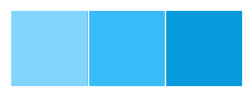

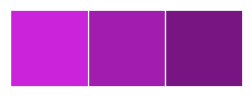

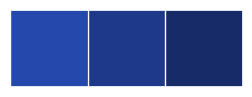

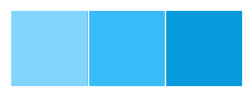

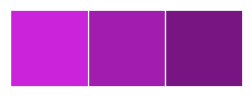

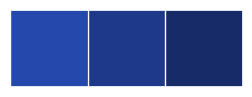

In [5]:
import colorsys
import matplotlib
import seaborn as sns

def scale_lightness(rgb, scale_l):
    rgb = matplotlib.colors.ColorConverter.to_rgb(rgb)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

plot_colors = {k: {
    'light': scale_lightness(v['color'], 1.25),
    'default': scale_lightness(v['color'], 1),
    'dark': scale_lightness(v['color'], 0.75)
} for k, v in databases.items() if 'color' in v}

for k in plot_colors:
    sns.palplot(plot_colors[k].values())

### Set comparison mode

Most plots compare data for only 2 scenarios, where one is "more coordinated" than the other; this cell determines which 2, based on keys in `databases`

In [6]:
# this only affects the file path where images are saved

COMPARISON_MODE = 'meso_lv'           # SET THIS!

if COMPARISON_MODE == 'two':
    raise NotImplementedError()
    uncoordinated_name = 'fully_uncoordinated'            # SET THIS!
    coordinated_name = 'fully_coordinated'              # SET THIS!

    uncoordinated_description = databases[uncoordinated_name]['desc']
    uncoordinated_simulation_database_path = databases[uncoordinated_name]['path']
    uncoordinated_simulation_database_aimsun = databases[uncoordinated_name]['remote_aimsun']
    uncoordinated_simulation_results_database = postprocessing_util.AimsunMicroOutputDatabase(uncoordinated_simulation_database_path)
    uncoordinated_con = uncoordinated_simulation_results_database.database

    coordinated_description = databases['fully_coordinated']['desc']
    coordinated_simulation_database_path = databases['fully_coordinated']['path']
    coordinated_simulation_results_database = postprocessing_util.AimsunMicroOutputDatabase(coordinated_simulation_database_path)
    coordinated_con = coordinated_simulation_results_database.database

    to_plot = [uncoordinated_name, coordinated_name]
    database_names = [uncoordinated_name, coordinated_name]

try:
    to_plot = {
        '100': [
            'fully_uncoordinated_averaged', 'mission_fully_uncoordinated', 
            'mission_partially_uncoordinated_averaged', 'osgood_fully_uncoordinated',
            'osgood_partially_uncoordinated_averaged', 'fully_coordinated_averaged'
        ],
        '200': [
            'fully_uncoordinated_200', 'mission_partially_uncoordinated_200',
            'osgood_partially_uncoordinated_200', 'fully_coordinated_200'
        ],
        'lv': [
            'fully_coordinated_averaged', 'nooffset_mission_nb_averaged',
            'lv_mission_nb_averaged'
        ],
        'meso_lv': [
            'meso_2019_averaged', 'meso_lv_mission_nb_averaged',
            'meso_mission_nooffset_averaged'
        ]
    }[COMPARISON_MODE]
except:
    pass

database_names = {
    '100': [k for k in databases if '200' not in k],
    '200': [k for k in databases if '200' in k],
    'lv': [
        'fully_coordinated_rep1', 'fully_coordinated_rep2', 'fully_coordinated_rep3', 
        'fully_coordinated_averaged', 'nooffset_mission_nb_rep1', 
        'nooffset_mission_nb_rep2', 'nooffset_mission_nb_averaged', 'lv_mission_nb_rep1', 
        'lv_mission_nb_rep2', 'lv_mission_nb_rep3', 'lv_mission_nb_averaged'
    ],
    'meso_lv': [
        'meso_2019_rep1', 'meso_2019_rep2', 'meso_2019_rep3', 'meso_2019_averaged',
        'meso_lv_mission_nb_rep1', 'meso_lv_mission_nb_rep2', 'meso_lv_mission_nb_rep3',
        'meso_lv_mission_nb_averaged', 'meso_mission_nooffset_rep1', 
        'meso_mission_nooffset_rep2', 'meso_mission_nooffset_rep3',
        'meso_mission_nooffset_averaged'
    ]
}[COMPARISON_MODE]

In [7]:
from datetime import datetime
today = datetime.now().strftime("%Y-%m-%d")
image_path = f'C:/Users/prest/Preston/Berkeley/fremont_project/images/{today}'
if COMPARISON_MODE == 'two':
    raise NotImplementedError()
    image_path += f'/{uncoordinated_description} vs {coordinated_description}'
else:
    image_path += '/' + COMPARISON_MODE

if not os.path.exists(image_path):
    os.makedirs(image_path)

with open(image_path + '/description.txt', 'w') as f:
    if COMPARISON_MODE == 'two':
        raise NotImplementedError()
        f.write(
            f"{uncoordinated_description} data from:\n{uncoordinated_simulation_database_path}"
            + f"{coordinated_description} data from:\n{coordinated_simulation_database_path}"
        )
    else:
        paths = [databases[scenario]['path'] for scenario in database_names if 'path' in databases[scenario]]
        longest_prefix = None
        for i in range(len(paths[0]), -1, -1):
            prefix = paths[0][:i]
            if prefix[-1] == '/' and all(path.startswith(prefix) for path in paths):
                longest_prefix = prefix
                break
        f.write(
            longest_prefix + " {\n"
            + '\n'.join(['\t' + path[len(longest_prefix):] for path in paths])
            + '\n}'
        )


def save_fig(path, mode='rel'):
    assert mode in ['rel', 'abs']
    if mode == 'rel':
        path = os.path.join(image_path, path)
    folder, filename = os.path.split(path)
    if not os.path.exists(folder):
        os.makedirs(folder)
    if '.' in filename:
        plt.savefig(path, bbox_inches='tight', pad_inches=0)
    else:
        plt.savefig(path + '.png', bbox_inches='tight', pad_inches=0)
        plt.savefig(path + '.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
class Metric:
    def __init__(self, name, desc, unit):
        self.name = name
        self.desc = desc
        self.unit = unit

    def __str__ (self) -> str:
        return f'{self.desc} ({self.unit})'

    def __repr__(self) -> str:
        return f'Metric({str(self.name)}, {str(self.desc)}, {str(self.unit)})'

In [9]:
plusminus = u"\u00B1"
DATA_ROOT = os.path.join(module_path, '../data')

class ResultsDf:
    """Helper class for managing tables of results."""
    def __init__(self, columns=['label', 'mean', 'std'], path=None):
        """
        If `path` is not None, reads the csv from `path`. Otherwise, initializes 
        an empty DataFrame with `columns`.
        """
        if path:
            self.df = pd.read_csv(path)
        else:
            self.df = pd.DataFrame(columns=columns)

    def add(self, **kwargs):
        """Appends a row to self.df. All columns must be specified in kwargs."""
        assert set(kwargs) == set(self.df.columns)
        row = len(self.df)
        for k, v in kwargs.items():
            self.df.loc[row, k] = v

    def save(self, path, transpose=False, file_type='csv', path_type='rel', index_cols=[]):
        """
        Saves self.df to `path`, which must not contain a file type.
        file_type must be in {csv, tex, md, all}.
        """
        if path_type == 'rel':
            path = os.path.join(DATA_ROOT, path)
        folder, filename = os.path.split(path)
        acceptable_file_types = ['csv', 'tex', 'md']
        assert '.' not in filename
        assert file_type in acceptable_file_types + ['all']
        assert path_type in ['rel', 'abs']
        if not os.path.exists(folder):
            os.makedirs(folder)
        if index_cols:
            assert all([c in self.df.columns for c in index_cols])
        
        def write(file_type):
            full_path = f'{path}.{file_type}'
            if file_type == 'csv':
                ResultsDf._transpose(self.df, transpose).to_csv(full_path, index=False)
            else:
                with open(full_path, 'w') as f:
                    if file_type == 'tex':
                        f.write(self.latex(index_cols, transpose))
                    elif file_type == 'md':
                        f.write(self.markdown(transpose))
        if file_type == 'all':
            write('csv'); write('tex'); write('md');
        else:
            write(file_type)

    def latex(self, index_cols, transpose=False):
        return self._display(index_cols, transpose=False, latex=True) \
                   .style \
                   .to_latex(hrules=True) \
                   .replace(plusminus, '$\\pm$') \
                   .replace('_', ' ') \
                   .replace('[c]', '[t]')
    
    def markdown(self, transpose=False):
        return self._display([], transpose, latex=False) \
                   .to_markdown(index=False)
    
    def __str__(self):
        return self.df.__str__()
    
    def _transpose(df, transpose: bool):
        return df.T if transpose else df
    
    def _get_interval_str(mean, std):
        return f'{mean:.2f} {plusminus} {(2*std):.2f}'
    
    def _display(self, index_cols: list, transpose: bool, latex: bool):
        df = deepcopy(self.df)
        if all([c in df.columns for c in ['mean', 'std']]):
            df['interval'] = df.apply(
                lambda row: ResultsDf._get_interval_str(row['mean'], row['std']), axis=1)
            df = df.drop(columns=['mean', 'std'])
        if latex:
            if index_cols == []:
                index_cols = list(df.columns)[:-1]
            df.set_index(index_cols, inplace=True)
        df = ResultsDf._transpose(df, transpose)
        df.rename(columns=str.capitalize, inplace=True)
        return df
    

### Test runs + more setup

In [10]:
# # Select metric to compute.
# # Here it is an example of delay time.
# metric_name, metric_units = 'average delay time', 's'
# uncoordinated_simulated_metric_values = postprocessing_plot_util.process_network_delay_time_data(
#     uncoordinated_simulation_results_database, TIME_INTERVALS)

# coordinated_simulated_metric_values = postprocessing_plot_util.process_network_delay_time_data(
#     coordinated_simulation_results_database, TIME_INTERVALS)

# fig = plt.figure(figsize=(15, 5))
# plt.title(f"{metric_name} across the network at each timestep")
# plt.xlabel("Timestep")
# plt.ylabel(f"{metric_name} ({metric_units})")
# plt.plot(TIME_INTERVALS_STRING, uncoordinated_simulated_metric_values, label=uncoordinated_description)
# plt.plot(TIME_INTERVALS_STRING, coordinated_simulated_metric_values, label=coordinated_description)
# plt.legend(loc="upper left")
# plt.xticks(rotation=70)
# plt.show()

In [11]:
import geopandas as gpd

gpd_path = 'C:/Users/prest/Preston/Berkeley/fremont_project/misc'
sections = gpd.read_file(f'{gpd_path}/Data collection copy/Data/Manually made/Network/Map/Aimsun/sections.shp').to_crs('EPSG:3857')
nodes = gpd.read_file(f'{gpd_path}/Data collection copy/Data/Manually made/Network/Map/Aimsun/nodes.shp').to_crs('EPSG:3857')
taz_int = gpd.read_file(f'{gpd_path}/Data collection/Data/Auxiliary/Demand/TAZ_old/Internal/Internal_TAZ.shp').to_crs('EPSG:3857')
centroids = gpd.read_file(f'{gpd_path}/Data collection copy/Data/Manually made/Network/Map/Aimsun/centroids.shp').to_crs('EPSG:3857')

sections_near_mission = gpd.sjoin(sections, gpd.read_file(f'{gpd_path}/Buffer_areas/mission_buffer.shp').to_crs('EPSG:3857'))
sections_near_osgood = gpd.sjoin(sections, gpd.read_file(f'{gpd_path}/Buffer_areas/osgood_buffer.shp').to_crs('EPSG:3857'))
i680_northbound = gpd.read_file(f'{gpd_path}/Links_shp/I680_NB.shp').to_crs('EPSG:3857')
i680_southbound = gpd.read_file(f'{gpd_path}/Links_shp/I680_SB.shp').to_crs('EPSG:3857')
mission_northbound = gpd.read_file(f'{gpd_path}/Links_shp/Mission_NB.shp').to_crs('EPSG:3857')
mission_southbound = gpd.read_file(f'{gpd_path}/Links_shp/Mission_SB.shp').to_crs('EPSG:3857')
osgood_northbound = gpd.read_file(f'{gpd_path}/Links_shp/Osgood_NB.shp').to_crs('EPSG:3857')
osgood_southbound = gpd.read_file(f'{gpd_path}/Links_shp/Osgood_SB.shp').to_crs('EPSG:3857')
paseo_padre_northbound = gpd.read_file(f'{gpd_path}/Links_shp/gmap_alternate_nb.shp').to_crs('EPSG:3857')
paseo_padre_southbound = gpd.read_file(f'{gpd_path}/Links_shp/gmap_alternate_sb.shp').to_crs('EPSG:3857')

i680_sections        = pd.concat([i680_northbound, i680_southbound], keys=['north', 'south']) \
                         .reset_index().rename(columns={'level_0': 'direction'}).drop(columns='level_1')
mission_sections     = pd.concat([mission_northbound, mission_southbound], keys=['north', 'south']) \
                        .reset_index().rename(columns={'level_0': 'direction'}).drop(columns='level_1')
osgood_sections      = pd.concat([osgood_northbound, osgood_southbound], keys=['north', 'south']) \
                         .reset_index().rename(columns={'level_0': 'direction'}).drop(columns='level_1')
paseo_padre_sections = pd.concat([paseo_padre_northbound, paseo_padre_southbound], keys=['north', 'south']) \
                         .reset_index().rename(columns={'level_0': 'direction'}).drop(columns='level_1')

sections

id    eid            name  nb_lanes  speed  capacity  rd_type  \
0           242.0    242            None         1  104.0    2100.0    175.0   
1           243.0    243            None         4  104.0    8400.0    175.0   
2           244.0    244            None         4  104.0    8400.0    175.0   
3           246.0    246    Geyser Court         1   40.0     600.0    179.0   
4           247.0    247    Geyser Court         1   40.0     600.0    179.0   
...           ...    ...             ...       ...    ...       ...      ...   
4428  151597396.0  28550  Fernald Common         1   40.0     600.0    179.0   
4429  151600599.0  28581     Alice Court         1   40.0     600.0    179.0   
4430  151616088.0   3425            None         2  104.0    2100.0    175.0   
4431  151616494.0  56150            None         2   72.0    1800.0    177.0   
4432  151627627.0   7154            None         6  104.0   10500.0    175.0   

      func_class        fnode        tnode  \
0              1       9845.0       9923.0   
1              1  151597118.0       9848.0   
2              1       9850.0       9852.0   
3              5       9868.0          NaN   
4              5          NaN       9868.0   
...          ...          ...          ...   
4428           5      42395.0          NaN   
4429           5      39784.0          NaN   
4430           1      56586.0  151616089.0   
4431           3      56168.0  151616495.0   
4432           1      14510.0  151627632.0   

                                               geometry  
0     LINESTRING (-13572344.019 4508460.315, -135723...  
1     LINESTRING (-13572329.348 4508264.159, -135722...  
2     LINESTRING (-13572464.084 4508415.329, -135724...  
3     LINESTRING (-13571458.486 4509669.510, -135714...  
4     LINESTRING (-13571596.214 4509623.139, -135715...  
...                                                 ...  
4428  LINESTRING (-13572473.917 4507663.732, -135724...  
4429  LINESTRING (-13575454.502 4513910.059, -135754...  
4430  LINESTRING (-13574102.042 4511052.704, -135741...  
4431  LINESTRING (-13574438.360 4511038.633, -135744...  
4432  LINESTRING (-13574115.113 4510698.825, -135739...  

[4433 rows x 11 columns]

In [12]:
signalized_nodes = {
    'city-controlled': {
        '27399': ['Washington Boulevard', 'Paseo Padre Parkway'],
        '27553': ['Paseo Parde Parkway', 'Durham Road'],
        '13225': ['Mission Boulevard', 'Washington Boulevard'],
        '27847': ['Mission Boulevard', 'Anza Street'],
        '27869': ['Mission Boulevard', 'Pine Lane'],
        '27889': ['Mission Boulevard', 'Hunter Lane'],
        '27921': ['Mission Boulevard', 'Cougar Drive'],
        '27938': ['Mission Boulevard', 'South Grimmer Boulevard'],
        '27954': ['Mission Boulevard', 'Stanford Ave'],
        '16827': ['Mission Boulevard', 'Paseo Parde Parkway'],
        '56391': ['Washington Boulevard', 'Osgood Road - Driscoll Road'],
        '56129': ['Washington Boulevard', 'Meredith Drive'],
        '56324': ['Paseo Padre Parkway', 'Gomes Road'],
        '56297': ['Paseo Padre Parkway', 'Driscoll Road'],
        '56270': ['Paseo Padre Parkway', 'Chadbourne Drive'],
        '62356': ['Osgood Road', 'Blacow Road'],
        '56418': ['Auto Mall Parkway', 'Osgood Road'],
        '56471': ['Warm Springs Boulevard - Osgood Road', 'S. Grimmer'],
        '45371': ['Warm Springs Boulevard', 'Mission Ct'],
        '56438': ['Warm Springs Boulevard', 'East Warren Avenue'],
        '62346': ['Osgood Road', 'Walmart Driveway'],
        '53579': ['Warm Springs Boulevard', 'Fulton Place'],
        '38460': ['Warm Springs Boulevard', 'Warm Springs Bart'],
        '45004': ['Warm Springs Boulevard', 'Transit Way'],
        '56244': ['Driscoll Road', 'Amapola Drive'],
        '56484': ['East Warren Avenue', 'Fernald Street']
    },
    'state-controlled': {
        '42160': ['Mission Boulevard', 'Esparito Avenue - Ondina Drive'],
        '56218': ['Mission Boulevard', 'Driscoll Road'],
        '27479': ['Mission Boulevard', 'Palm Ave'],
        '56451': ['Mission Boulevard', 'Warm Springs Boulevard'],
        '62795': ['Mission Boulevard', 'Mohave Drive'],
        '27796': ['Mission Boulevard', 'I-680 Southbound Ramp'],
        '27816': ['Mission Boulevard', 'I-680 Northbound Ramp - Mission Road'],
        '27327': ['Washington Boulevard', 'I-680 Southbound Ramp'],
        '27345': ['Washington Boulevard', 'I-680 Nouthbound Ramp - Luzon Drive'],
        '56173': ['Durham Road', 'I-680 Southbound Ramp'],
        '27711': ['Durham Road', 'I-680 Northbound Ramp'],
    }
}

In [13]:
node_geo_city = nodes[nodes['eid'].isin(signalized_nodes['city-controlled'].keys())]
node_geo_state = nodes[nodes['eid'].isin(signalized_nodes['state-controlled'].keys())]
node_geo_combined = pd.concat([node_geo_city, node_geo_state])

In [14]:
buffer_area_path = 'C:/Users/prest/Preston/Berkeley/fremont_project/misc/Buffer_areas/Jan2023'
buffer_distances = [100, 200, 300, 400, 500, 1000, 1500]
mission_buffer, osgood_buffer = {}, {}

for d in buffer_distances:
    mission_polygon = gpd.read_file(
        os.path.join(buffer_area_path, f'mission_buffer_{d}.shp')).to_crs('EPSG:3857')
    osgood_polygon = gpd.read_file(
        os.path.join(buffer_area_path, f'mission_buffer_{d}.shp')).to_crs('EPSG:3857')
    mission_buffer[d] = {
        'polygon': mission_polygon, 
        'sections': gpd.sjoin(sections, mission_polygon),
        'nodes': gpd.sjoin(node_geo_combined, mission_polygon)
    }
    osgood_buffer[d] = {
        'polygon': osgood_polygon, 
        'sections': gpd.sjoin(sections, osgood_polygon),
        'nodes': gpd.sjoin(node_geo_combined, osgood_polygon)
    }

Altered nodes

In [15]:
all_uncoordinated = [int(k) for k in node_geo_combined['eid']]
mission_partially_uncoordinated = [16827, 27954, 27938, 27921]
mission_all_uncoordinated = [56451, 62795, 16827, 27954, 27938, 27921, 27889, 27869, 27847, 13225, 27816, 27796, 27479, 56218, 42160]
osgood_partially_uncoordinated = [56391, 56418, 62346, 62356]
osgood_all_uncoordinated = [56438, 56451, 45371, 53579, 38460, 45004, 56471, 62346, 56418, 62356, 56391, 56297, 56244, 56218]
all_coordinated = []

for k in databases:
    if 'mission_fully' in k:
        databases[k]['uncoordinated_nodes'] = mission_all_uncoordinated
    elif 'mission_partially' in k:
        databases[k]['uncoordinated_nodes'] = mission_partially_uncoordinated
    elif 'osgood_fully' in k:
        databases[k]['uncoordinated_nodes'] = osgood_all_uncoordinated
    elif 'osgood_partially' in k:
        databases[k]['uncoordinated_nodes'] = osgood_partially_uncoordinated
    elif 'fully_uncoordinated' in k:
        databases[k]['uncoordinated_nodes'] = all_uncoordinated
    else:
        databases[k]['uncoordinated_nodes'] = all_coordinated

databases

{'fully_coordinated_rep1': {'desc': 'System Fully Coordinated (Rep. 1)',
  'abbrev_desc': 'Status Quo (Rep. 1)',
  'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_220914/coordinated.sqlite',
  'remote_aimsun': 'network_calibrated.ang',
  'uncoordinated_nodes': []},
 'fully_coordinated_rep2': {'desc': 'System Fully Coordinated (Rep. 2)',
  'abbrev_desc': 'Status Quo (Rep. 2)',
  'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/coordinated_1845330897.sqlite',
  'remote_aimsun': 'network_calibrated.ang',
  'uncoordinated_nodes': []},
 'fully_coordinated_rep3': {'desc': 'System Fully Coordinated (Rep. 3)',
  'abbrev_desc': 'Status Quo (Rep. 3)',
  'path': 'C:/Users/prest/Preston/Berkeley/fremont_project/databases/preston_221007/uncoordinated_1253324985.sqlite',
  'remote_aimsun': 'network_calibrated.ang',
  'uncoordinated_nodes': []},
 'fully_coordinated_averaged': {'desc': 'System Fully Coordinated',
  'abbrev_desc': 'Status Quo'

In [16]:
centroid_oid_to_eid = {
    151634377: 'int_0',
    151634402: 'int_1',
    151634411: 'int_2',
    151634430: 'int_3',
    151634517: 'int_4',
    151634526: 'int_5',
    151634543: 'int_6',
    151634562: 'int_7',
    151634607: 'int_8',
    151634638: 'int_11',
    151634657: 'int_12',
    151634698: 'int_15',
    151634723: 'int_16',
    151634742: 'int_17',
    151634773: 'int_18',
    151634794: 'int_19',
    151634797: 'int_20',
    151634845: 'int_22',
    151634856: 'int_23',
    151634869: 'int_24',
    151634880: 'int_25',
    151634913: 'int_26',
    151634935: 'int_27',
    151634952: 'int_28',
    151635006: 'int_29',
    151635048: 'int_31',
    151635051: 'int_32',
    151635122: 'int_35',
    151635156: 'int_38',
    151635184: 'int_40',
    151635189: 'int_41',
    151635210: 'int_42',
    151635228: 'int_43',
    151635245: 'int_44',
    151635264: 'int_45',
    151635291: 'int_46',
    151635317: 'int_48',
    151635345: 'int_50',
    151635369: 'int_52',
    151635403: 'int_54',
    151635414: 'int_55',
    151635423: 'int_56',
    151635426: 'int_57',
    151635443: 'int_58',
    151635460: 'int_59',
    151635479: 'int_60',
    151635492: 'int_61',
    151635509: 'int_62',
    151635521: 'int_64',
    151635541: 'int_66',
    151635580: 'int_67',
    151635583: 'int_68',
    151635600: 'int_69',
    151635648: 'int_71',
    151635666: 'int_73',
    151635689: 'int_74',
    151635718: 'ext_1',
    151635721: 'ext_2',
    151635724: 'ext_3',
    151635727: 'ext_4',
    151635730: 'ext_5',
    151635733: 'ext_6',
    151635736: 'ext_7',
    151635739: 'ext_8',
    151635742: 'ext_9',
    151635745: 'ext_10'
}

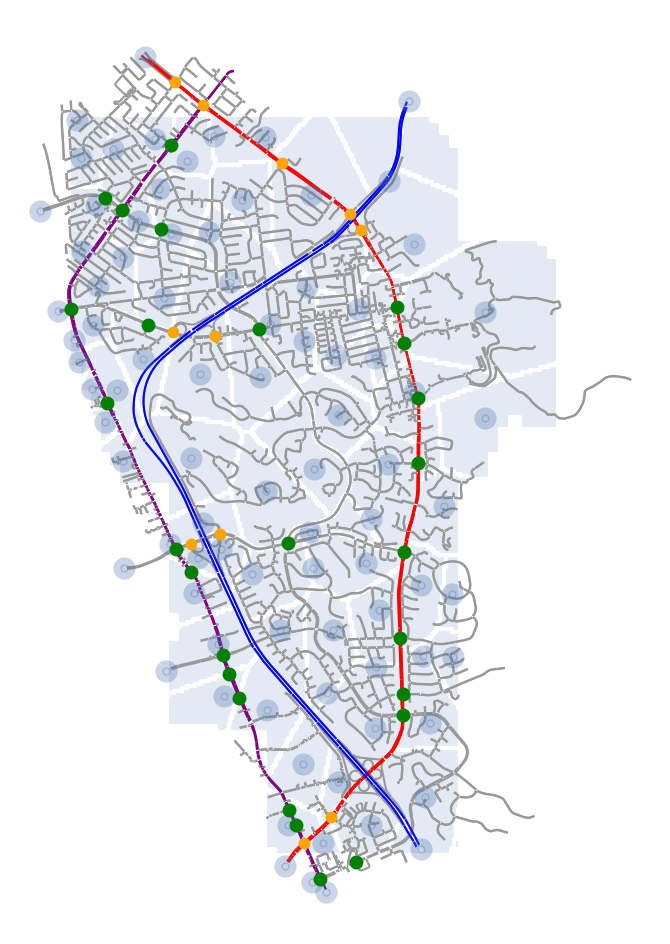

In [17]:
from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# comment the following section to toggle tilemapbase
# import tilemapbase
# tilemapbase.start_logging()
# tilemapbase.init(create=True)
# extent = tilemapbase.extent_from_frame(sections, buffer=25)
# plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=400)
# plotter.plot(ax)

taz_int.plot(ax=ax, alpha=0.15, zorder=1)
taz_int.boundary.plot(ax=ax, lw=3, color='white', zorder=2)
sections.plot(ax=ax, color='0.6', zorder=3)
mission_sections.plot(ax=ax, color='red', zorder=4)
osgood_sections.plot(ax=ax, color='purple', zorder=4)
i680_sections.plot(ax=ax, color='blue', zorder=4)
centroids.plot(ax=ax, lw=10, alpha=0.3, zorder=5)
node_geo_city.plot(ax=ax, lw=4, color='green', zorder=6)
node_geo_state.plot(ax=ax, lw=2.5, color='orange', zorder=6)
# mission = nodes[nodes['eid'].isin(np.array(mission_partially_uncoordinated).astype(str))]
# osgood = nodes[nodes['eid'].isin(np.array(osgood_partially_uncoordinated).astype(str))]
# mission.plot(ax=ax, lw=4, color='red', zorder=7)
# osgood.plot(ax=ax, lw=4, color='purple', zorder=7)
ax.axis('off')

save_fig('C:/Users/prest/Preston/Berkeley/fremont_project/images/signalized_nodes', 'abs')
plt.show()

In [18]:
def remove_unnamed(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [24]:
data_path = f'C:/Users/prest/Preston/Berkeley/fremont_project/processed_data'

def unpack_databases(category, preprocessor=lambda df: df, drop_non_average=False,
                     from_scratch=False, overwrite=False):
    """
    Unpacks the databases of type `category` in `databases` according to COMPARISON_MODE.
    Applies `preprocessor` before saving.
    
    `overwrite`: False (don't overwrite anything) 
                 True (overwrite everything)
                 list: overwrite some subset of `database_names`.
                 Caution! There is no way to restore previous versions.

    TODO: implement `drop_non_average`
    """
    unpacked_databases = {}
    try:
        merge_on = {
            # microscopic
            'MISYS': ['ent'],
            'MISECT': ['ent', 'eid'],
            'MICENT_O': ['oid', 'eid', 'destination', 'ent', 'dest_eid'],
            'MISYSIEM': ['ent'],
            'HCMMIAPPROACH': ['ent', 'eid'],
            'Rgap': ['ent'],

            # mesoscopic
            'MESYS': ['ent'],
            'MESECT': ['ent', 'eid'],
            'MECENT_O': ['oid', 'eid', 'destination', 'ent', 'dest_eid'],
            'SYSLEM': ['ent'],
        }[category]
    except:
        raise ValueError(f'{category} is invalid category')
    averaged = '_averaged'

    if overwrite is False:
        overwrite = []
    elif overwrite is True:
        overwrite = database_names
    else:
        assert all([n in database_names for n in overwrite])
    if from_scratch and drop_non_average:
        raise ValueError('Cannot drop non-averages when unpacking from scratch')

    def get_path(scenario):
        return os.path.join(data_path, category, f'{scenario}.csv.gz')

    def save_csv(scenario, data: pd.DataFrame):
        path = get_path(scenario)
        folder, _ = os.path.split(path)
        if not os.path.exists(folder):
            os.makedirs(folder)
        data.to_csv(path, compression='gzip', index=False)
    
    with tqdm(total=len(database_names)) as pbar:
        # Pass 1: load existing data
        if not from_scratch:
            for scenario in database_names:
                if scenario not in overwrite:
                    path = get_path(scenario)
                    if os.path.exists(path):
                        pbar.set_postfix({'scenario': scenario})
                        unpacked_databases[scenario] = pd.read_csv(path, compression='gzip')
                        pbar.update(1)

        # Pass 2: handle non-averaged
        for scenario in database_names:
            if not scenario in unpacked_databases and not scenario.endswith(averaged):
                pbar.set_postfix({'scenario': scenario})
                path = databases[scenario]['path']
                data = postprocessing_util.AimsunMicroOutputDatabase(path).database
                data = pd.read_sql(f'SELECT * FROM {category}', data)
                data = preprocessor(pd.DataFrame(data))
                unpacked_databases[scenario] = data
                save_csv(scenario, data)
                pbar.update(1)
        
        # Pass 3: handle averages
        for scenario in database_names:
            if not scenario in unpacked_databases and scenario.endswith(averaged):
                pbar.set_postfix({'scenario': scenario})
                prefix = scenario[:-len(averaged)]
                corresponding_scenarios = [k for k in unpacked_databases if k.startswith(prefix)]
                assert len(corresponding_scenarios) > 0, f'Provide at least one database to aggregate for {scenario}'
                corresponding_data = [unpacked_databases[k] for k in corresponding_scenarios]
                data = pd.DataFrame(pd.concat(corresponding_data))
                data = data.groupby(merge_on).mean().reset_index()
                data = remove_unnamed(data)
                unpacked_databases[scenario] = data
                save_csv(scenario, data)
                pbar.update(1)

        for scenario in unpacked_databases:
            df = unpacked_databases[scenario]
            if 'eid' in df.columns:
                df['eid'] = df['eid'].astype(str)
            unpacked_databases[scenario] = remove_unnamed(df)

    return unpacked_databases

In [20]:
if COMPARISON_MODE == 'two':
    print(uncoordinated_description + ' vs ' + coordinated_description)
else:
    print(COMPARISON_MODE)
print(image_path)

meso_lv
C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-05-16/meso_lv


### RUN ABOVE THIS CELL

In [18]:
### Run above this cell

<a id='syshcm'></a>
# System/HCM

In [70]:
sys_metrics = {
    'density': Metric('density', 'Density', 'veh/km'),
    'flow': Metric('flow', 'Mean flow', 'veh/h'),
    'ttime': Metric('ttime', 'Mean travel time', 's/km'),
    'dtime': Metric('dtime', 'Mean delay time', 's/km'),
    'speed': Metric('speed', 'Mean speed', 'km/h'),
    'qmean': Metric('qmean', 'Mean vehicles in queue', 'veh'),
    'travel': Metric('travel', 'Total distance traveled by exited vehicles', 'km'),
    'input_count': Metric('input_count', 'Number vehicles entering network', 'veh'),
    'totalWaitingTime': Metric('totalWaitingTime', 'Total time, vehicles waiting to enter network', 'h'),
    'vWait': Metric('vWait', 'Number of vehicles waiting to enter network', 'veh')
}

if 'meso' not in COMPARISON_MODE:
    sys_metrics['fuelc'] = Metric('fuelc', 'Total fuel consumed', 'L'),
    sys_metrics['batteryc'] = Metric('batteryc', 'Total battery consumed', 'kWh'),

def preprocess_sys(df):
    df = df[(df['ent']!=0) & (df['sid']==0)]
    return df[['ent'] + list(sys_metrics)]

In [29]:
hcm_metrics = {
    'density': Metric('density', 'Density of vehicles', 'PCU/km'),
    'los': Metric('los', 'Level of service', None),
    'queue_delay': Metric('queue_delay', 'Queue delay', 's/veh'),
    'queue_length': Metric('queue_length', 'Average queue length', 'veh'),
    'queued_vehicles': Metric('queued_vehicles', 'Percent queued vehicles', '%'),
    'segment_delay': Metric('segment_delay', 'Segment delay', 's/veh'),
    'stopped_delay': Metric('stopped_delay', 'Stopped delay', 's/veh'),
    'nbstops': Metric('nbstops', 'Number of stops', None),
    'slow_vehicles': Metric('slow_vehicles', 'Percent slow vehicles', '%')
}

def preprocess_hcm(df):
    for k in hcm_column_names:
        df[k] = df[k].astype(float)
    df['density'] *= 0.621      # converting to km
    df['los'] = df['los'].astype(int)
    return df[['ent', 'eid'] + list(hcm_metrics)]

In [30]:
from matplotlib import rcParams as rc

categorical_labels = {
    'los': {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F'}
}

def sys_line_plot(metric: Metric, data, ax):
    for scenario, database, label in data:
        ax.plot(
            TIME_INTERVALS_STRING, 
            database, 
            label=label, 
            color=plot_colors[scenario]['default']
        )
    ax.set_title(f'{metric.desc}', size=20)
    ax.set_xlabel('Time', size=16)
    ax.set_ylabel(metric.unit, size=16)
    ax.legend(loc='upper left')
    ax.tick_params('x', labelrotation=70)

def sys_bar_plot(metric: Metric, data, ax):
    """
    data: List(Tuple(DataFrame, String))
    ax: Axes
    """
    labels = categorical_labels[metric.name].values()
    width = 1/(len(data)+1)
    x = np.arange(len(labels))
    for i in range(len(data)):
        scenario, database, label = data[i]
        ax.bar(
            x + i * width, 
            database.value_counts().sort_index(),
            width,
            label=label,
            color=plot_colors[scenario]['default']
        )
    ax.set_title(f'{metric.desc}', size=20)
    ax.set_xticks(x + (len(data) - 1) * width / 2)
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric.unit, size=16)
    ax.legend(loc='upper right')

# fig, axs = plt.subplots(4, 3, figsize=(25, 25))
# fig.suptitle('Mean system-wide metrics over time')

sys_hcm_metrics = [
    hcm_metrics['density'],
    sys_metrics['flow'],
    sys_metrics['ttime'],
    sys_metrics['speed'],
    sys_metrics['fuelc'],
    sys_metrics['batteryc'],
    sys_metrics['travel'],
    hcm_metrics['los'],
    hcm_metrics['queue_delay'],
    hcm_metrics['queue_length'],
    hcm_metrics['queued_vehicles'],
    hcm_metrics['nbstops'],
    sys_metrics['input_count'], 
    sys_metrics['totalWaitingTime'], 
    sys_metrics['vWait']
    # hcm_metrics['slow_vehicles']
]

# sys_hcm_metrics = np.reshape(sys_hcm_metrics, (4, 3))
# 
# for i in range(4):
#     for j in range(3):
#         ax, metric = axs[i][j], sys_hcm_metrics[i][j]
#         if metric.name == 'los':
#             data_uncoordinated = (hcm_df[f'{metric.name}_uncoordinated'], uncoordinated_description)
#             data_coordinated = (hcm_df[f'{metric.name}_coordinated'], coordinated_description)
#             sys_bar_plot(metric, [data_uncoordinated, data_coordinated], ax)
#         elif metric.name in hcm_metrics:
#             data = hcm_df[['ent', f'{metric.name}_uncoordinated', \
#                 f'{metric.name}_coordinated']].groupby('ent').mean()
#             # print(data)
#             data_uncoordinated = (data[f'{metric.name}_uncoordinated'], uncoordinated_description)
#             data_coordinated = (data[f'{metric.name}_coordinated'], coordinated_description)
#             sys_line_plot(metric, [data_uncoordinated, data_coordinated], ax)
#         else:
#             data_uncoordinated = (sys_df[f'{metric.name}_uncoordinated'], uncoordinated_description)
#             data_coordinated = (sys_df[f'{metric.name}_coordinated'], coordinated_description)
#             sys_line_plot(metric, [data_uncoordinated, data_coordinated], ax)

# plt.subplots_adjust(wspace=0.3, hspace=0.5)
# save_fig('misc/sys_hcm.png')
# plt.show()

In [83]:
unpacked_databases_sys = unpack_databases('MESYS' if 'meso' in COMPARISON_MODE else 'MISYS', preprocess_sys, from_scratch=True)
unpacked_databases_sys

100%|██████████| 12/12 [00:00<00:00, 81.65it/s, scenario=meso_mission_nooffset_averaged]


{'meso_2019_rep1':     ent   density     flow      ttime      dtime      speed       qmean  \
 0     1  1.588063   8188.0  48.378505   8.471916  78.961532  166.027865   
 3     2  2.416366  13420.0  53.598071  13.037852  71.633044  364.397862   
 6     3  2.844522  14324.0  59.258072  18.665870  66.230700  537.203421   
 9     4  2.883565  16144.0  57.827719  16.675928  66.832621  464.128525   
 12    5  2.648461  15712.0  55.584273  13.951065  70.088499  369.123536   
 15    6  2.719551  16196.0  54.055931  12.082398  72.992888  318.643124   
 18    7  2.752200  15964.0  54.767684  12.517556  72.426427  345.792317   
 21    8  2.972701  16868.0  56.807015  14.357992  69.431152  411.839404   
 24    9  2.972157  16304.0  58.062316  15.968799  66.746065  464.853095   
 27   10  3.054366  16444.0  57.394198  15.829244  67.673744  489.405419   
 30   11  3.121112  16332.0  59.907019  18.198722  65.266007  530.580191   
 33   12  3.273143  16728.0  60.597156  18.379947  64.466539  584.4676

In [72]:
unpacked_databases_hcm = unpack_databases('HCMMIAPPROACH', preprocess_hcm)
unpacked_databases_hcm

  0%|          | 0/12 [00:00<?, ?it/s, scenario=meso_2019_rep1]


DatabaseError: Execution failed on sql 'SELECT * FROM HCMMIAPPROACH': no such table: HCMMIAPPROACH

In [85]:
sys_hcm_res = ResultsDf(['metric', 'scenario', 'mean', 'std'])

for metric in tqdm(sys_hcm_metrics):
    try:
        fig, ax = plt.subplots(1, 1)
        if metric.name == 'los':
            categorical_res = ResultsDf(['scenario', metric.name, 'count'])
            data = []
            for scenario in to_plot:
                df = unpacked_databases_hcm[scenario]
                df = df[df['ent']==0]
                df = df[metric.name].astype(int).replace(categorical_labels[metric.name])
                counts = df.value_counts().sort_index()
                data.append((scenario, df, databases[scenario]['desc']))
                for index, count in counts.iteritems():
                    categorical_res.add(
                        scenario=databases[scenario]['desc'],
                        count=count, 
                        **{metric.name: index}
                    )
            sys_bar_plot(metric, data, ax)
            categorical_res.save(f'sys-hcm/{metric.name}', file_type='all')
        elif metric.name in set().union(sys_metrics, hcm_metrics):
            data = []
            for scenario in to_plot:
                if metric.name in sys_metrics:
                    df = unpacked_databases_sys[scenario]
                else:
                    df = unpacked_databases_hcm[scenario]
                df = df[df['ent']!=0]
                if metric.name in hcm_metrics:
                    df = df.groupby('ent').mean()
                df = df[metric.name]
                data.append((scenario, df, databases[scenario]['desc']))
                sys_hcm_res.add(
                    metric=metric.name, 
                    scenario=databases[scenario]['desc'], 
                    mean=df.mean(), 
                    std=df.std()
                )
            sys_line_plot(metric, data, ax)
        else:
            raise NotImplementedError()

        save_fig(f'sys_hcm/{metric.name}')
        plt.close()
    
    except:
        plt.close()
        pass

sys_hcm_res.save('sys-hcm/all', file_type='all')
del df, metric, data

100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


Replications: Why's the status quo so bad?

In [91]:
base_scenarios = np.unique(['_'.join(k.split('_')[:-1]) for k in database_names])
pbar = tqdm(base_scenarios, total=len(base_scenarios)*len(sys_metrics))
for base_scenario in pbar:
    for metric in sys_metrics.values():
        pbar.set_postfix({'scenario': base_scenario, 'metric': metric.name})
        fig, ax = plt.subplots()
        for scenario in database_names:
            if base_scenario in scenario:
                ax.plot(
                    TIME_INTERVALS_STRING,
                    unpacked_databases_sys[scenario][metric.name],
                    label=scenario
                )
        ax.tick_params('x', labelrotation=70)
        ax.set_title(metric.__str__())
        plt.legend(loc='upper left')
        save_fig(f'sys-replications/{base_scenario}/{metric.name}.png')
        plt.close()
        pbar.update(1)
del base_scenarios, pbar

 10%|█         | 3/30 [00:10<01:35,  3.54s/it, scenario=meso_mission_nooffset, metric=vWait]            


<a id='emissions'></a>
## Emissions

In [27]:
co2 = Metric('CO2', 'Carbon Dioxide', 'g'),
nox = Metric('NOx', 'Nitrogen Oxides', 'g'),
voc = Metric('VOC', 'Volatile Organic Compounds', 'g'),
pm  = Metric('PM', 'Particulate Matter', 'g'),

if 'meso' in COMPARISON_MODE:
    emission_metrics = {'co2': co2, 'nox': nox}
else:
    emission_metrics = {'CO2': co2, 'NOx': nox, 'VOC': voc, 'PM': pm}
        # interurban are proportional and thus removed
        # 'CO2_Interurban': Metric('CO2_Interurban', 'Carbon Dioxide Emissions', 'g/km'),
        # 'NOx_Interurban': Metric('NOx_Interurban', 'Carbon Dioxide Emissions', 'g/km'),
        # 'VOC_Interurban': Metric('VOC_Interurban', 'Carbon Dioxide Emissions', 'g/km'),
        # 'PM_Interurban': Metric('PM_Interurban', 'Carbon Dioxide Emissions', 'g/km')

def preprocess_emissions(df):
    df = df[(df['sid']==0) & (df['ent']!=0)]
    return df[['ent'] + list(emission_metrics)]

In [28]:
unpacked_databases_emissions = unpack_databases('SYSLEM' if 'meso' in COMPARISON_MODE else 'MISYSIEM', preprocess_emissions)
unpacked_databases_emissions

100%|██████████| 12/12 [00:00<00:00, 104.15it/s, scenario=meso_mission_nooffset_averaged]


{'meso_2019_rep1':     ent  co2  nox
 0     1  0.0  0.0
 3     2  0.0  0.0
 6     3  0.0  0.0
 9     4  0.0  0.0
 12    5  0.0  0.0
 15    6  0.0  0.0
 18    7  0.0  0.0
 21    8  0.0  0.0
 24    9  0.0  0.0
 27   10  0.0  0.0
 30   11  0.0  0.0
 33   12  0.0  0.0
 36   13  0.0  0.0
 39   14  0.0  0.0
 42   15  0.0  0.0
 45   16  0.0  0.0
 48   17  0.0  0.0
 51   18  0.0  0.0
 54   19  0.0  0.0
 57   20  0.0  0.0
 60   21  0.0  0.0
 63   22  0.0  0.0
 66   23  0.0  0.0
 69   24  0.0  0.0,
 'meso_2019_rep2':     ent  co2  nox
 0     1  0.0  0.0
 3     2  0.0  0.0
 6     3  0.0  0.0
 9     4  0.0  0.0
 12    5  0.0  0.0
 15    6  0.0  0.0
 18    7  0.0  0.0
 21    8  0.0  0.0
 24    9  0.0  0.0
 27   10  0.0  0.0
 30   11  0.0  0.0
 33   12  0.0  0.0
 36   13  0.0  0.0
 39   14  0.0  0.0
 42   15  0.0  0.0
 45   16  0.0  0.0
 48   17  0.0  0.0
 51   18  0.0  0.0
 54   19  0.0  0.0
 57   20  0.0  0.0
 60   21  0.0  0.0
 63   22  0.0  0.0
 66   23  0.0  0.0
 69   24  0.0  0.0,
 'meso_2019_

In [38]:
for k in database_names:
    if unpacked_databases_emissions[k]['co2'].sum() == 0:
        print(f"{k:<35} {databases[k]['path'] if 'path' in databases[k] else ''}")

meso_2019_rep1                      C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_2019_0510_rep1.sqlite
meso_2019_rep2                      C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_2019_0510_rep3.sqlite
meso_2019_rep3                      C:/Users/prest/Preston/Berkeley/fremont_project/databases/alben_meso_230510/alben_2019_0510_rep5.sqlite
meso_2019_averaged                  


In [323]:
emissions_res = ResultsDf(['metric', 'scenario', 'mean', 'std']) 
del metric

for metric in emission_metrics.values():
    fig, ax = plt.subplots(figsize=(10,6))
    for scenario in to_plot:
        scenario_data = unpacked_databases_emissions[scenario][metric.name]
        ax.plot(TIME_INTERVALS_STRING, scenario_data, 
                label=databases[scenario]['desc'],
                color=plot_colors[scenario]['default'])
        emissions_res.add(
            metric=metric.name,
            scenario=databases[scenario]['desc'],
            mean=scenario_data.mean(),
            std=scenario_data.std()
        )

    plt.title(f'Systemwide {metric.name} Emissions Over Time', size=22)
    ax.tick_params('x', labelrotation=70)
    plt.legend(loc='upper left')
    plt.xlabel('Time', size=16)
    plt.ylabel('Emissions (g)', size=16)
    save_fig(f'{COMPARISON_MODE}/emissions/{metric.name}')
    plt.close()

emissions_res.save('emissions/emissions', file_type='all')

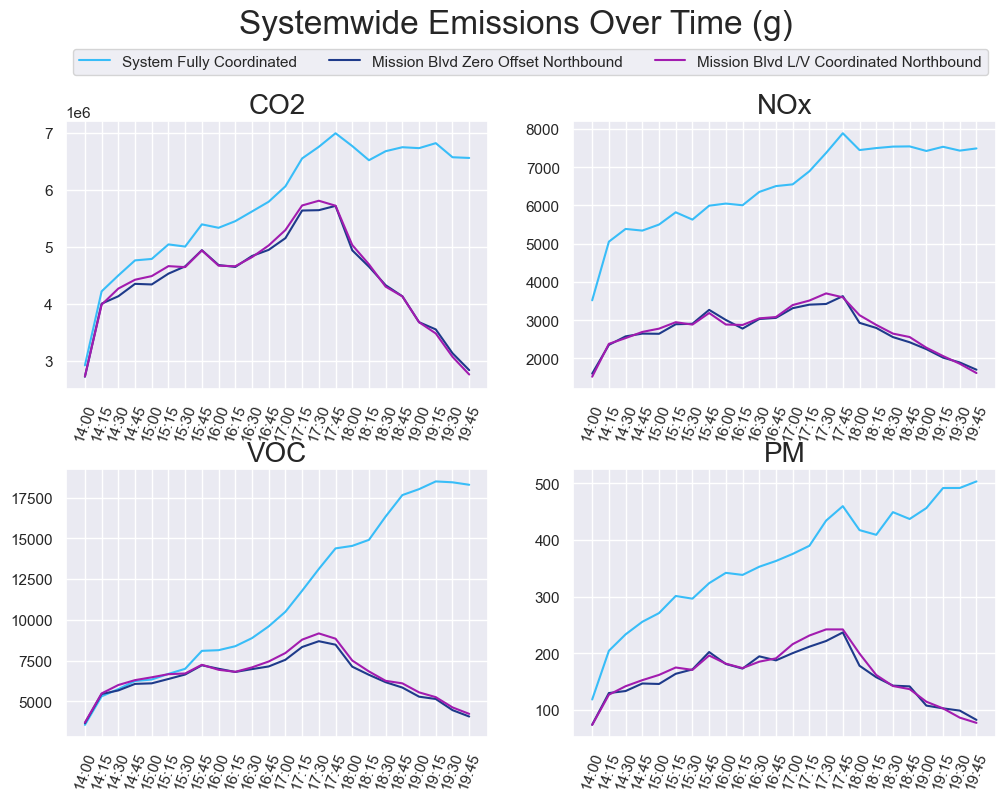

In [324]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(4):
    ax = axs[i//2][i%2]
    metric = list(emission_metrics.values())[i]
    for scenario in to_plot:
        ax.plot(
            TIME_INTERVALS_STRING, 
            unpacked_databases_emissions[scenario][metric.name], 
            label=databases[scenario]['desc'],
            color=plot_colors[scenario]['default']
        )
    ax.set_title(metric.name, size=20)
    ax.tick_params('x', labelrotation=70)

bb = (fig.subplotpars.left, fig.subplotpars.top, 
      fig.subplotpars.right-fig.subplotpars.left, .1)
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=bb, loc='upper center', mode='expand', ncol=3, prop={'size': 11})
plt.subplots_adjust(hspace=0.3)
plt.suptitle(f'Systemwide Emissions Over Time (g)', size=24, y=1.02)
save_fig('emissions/all')
plt.show()

<a id='rgap'></a>
## RGap

In [366]:
rgap_metrics = {
    'rgapInstantaneous': Metric('rgapInstantaneous', 'Instantaneous Relative Gap', None),
    'rgapExperienced': Metric('rgapExperienced', 'Experienced Relative Gap', None)
}

def preprocess_rgap(df):
    return df[df['ent']!=0][['ent'] + list(rgap_metrics)]

unpacked_databases_rgap = unpack_databases('Rgap', preprocess_rgap)
unpacked_databases_rgap

100%|██████████| 11/11 [00:00<00:00, 66.28it/s, scenario=lv_mission_nb_averaged]     


{'fully_coordinated_rep1':      ent  rgapInstantaneous  rgapExperienced
 0      1           0.012938         0.012101
 1      2           0.014063         0.013460
 2      3           0.012677         0.018196
 3      4           0.007353         0.011982
 4      5           0.006526         0.003027
 ..   ...                ...              ...
 355  356           0.808581         0.081233
 356  357           0.483354         0.086924
 357  358           0.131119         0.280918
 358  359           0.228681         0.164343
 359  360           0.211729         0.159328
 
 [360 rows x 3 columns],
 'fully_coordinated_rep2':      ent  rgapInstantaneous  rgapExperienced
 0      1           0.007504         0.005377
 1      2           0.009982         0.012982
 2      3           0.008531         0.010232
 3      4           0.010257         0.009985
 4      5           0.013281         0.011542
 ..   ...                ...              ...
 355  356           0.707780         0.324818
 

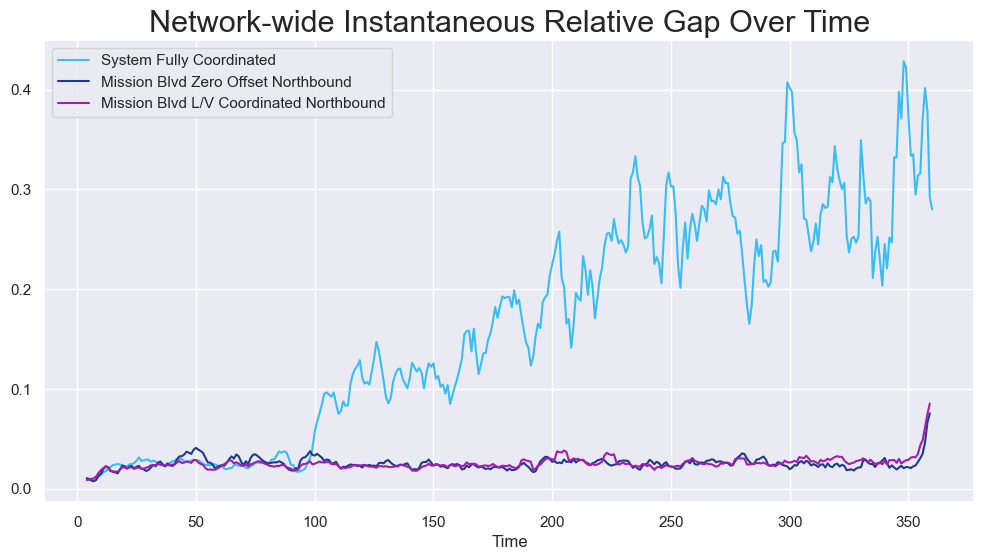

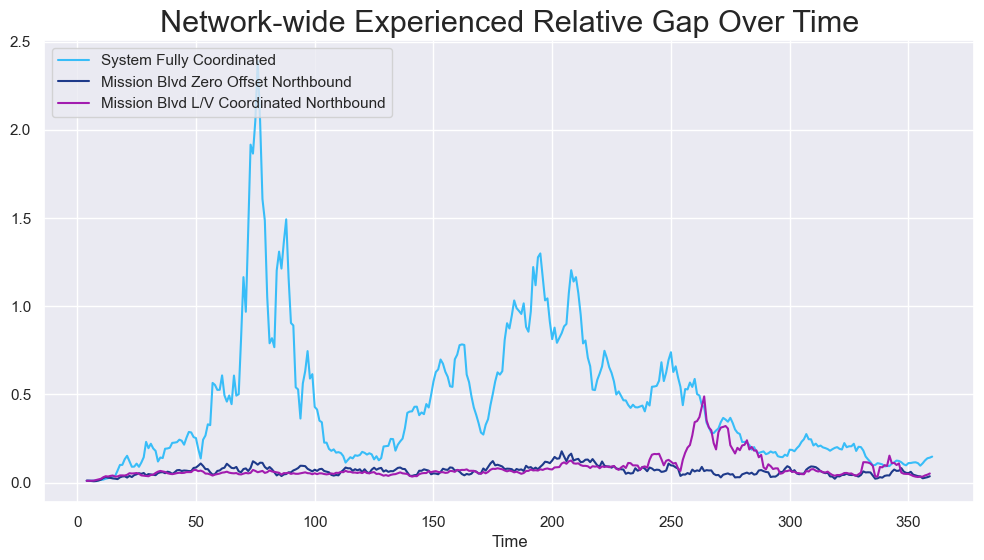

In [367]:
rgap_res = ResultsDf(['metric', 'scenario', 'mean', 'std'])

for metric in rgap_metrics.values():
    fig, ax = plt.subplots(figsize=(12, 6))
    for scenario in to_plot:
        data = unpacked_databases_rgap[scenario][metric.name]
        ax.plot(
            data.rolling(window=5).mean(), 
            label=databases[scenario]['desc'],
            color=plot_colors[scenario]['default']
        )
        rgap_res.add(
            metric=metric.desc,
            scenario=databases[scenario]['desc'],
            mean=data.mean(),
            std=data.std()
        )
    plt.title(f'Network-wide {metric.desc} Over Time', size=22)
    plt.xlabel('Time')
    plt.legend(loc='upper left')
    save_fig(f'rgap/{metric.name}')
    
rgap_res.save('rgap/rgap', file_type='all')

<a id='section'></a>
# Section Data

In [44]:
section_metrics = {
    'flow': Metric('flow', 'Mean Flow', 'veh/h'),
    'ttime': Metric('ttime', 'Mean Travel Time', 's'),
    'dtime': Metric('dtime', 'Mean Delay Time', 's'),
    'speed': Metric('speed', 'Mean Speed', 'km/h'),
    'density': Metric('density', 'Density by Lane', 'veh/km'),
    'travel': Metric('travel', 'Travel Distance by Section', 'km'),
    'count': Metric('count', 'Vehicle Count', 'veh')
}

In [45]:
# dfs_section = {'uncoordinated': uncoordinated_section_df, 'coordinated': coordinated_section_df}
null_values = {'eid': None, 'ent': None, 'count': 0}
section_df_cols = set(section_metrics).union(null_values)
group_cols = ['ent', 'eid']

def preprocess_sections(df):
    df = df[(df['sid']==0) & (df['eid']==df['oid'].astype(str))]
    df = df[group_cols + list(section_metrics.keys())]
    df.replace(-1, np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

# for k in dfs_section:
#     dfs_section[k] = preprocess_sections(dfs_section[k])

# dfs_section['uncoordinated']

In [23]:
# section_df = dfs_section['uncoordinated'].join(dfs_section['coordinated'], 
#     on=group_cols, lsuffix='_uncoordinated', rsuffix='_coordinated').dropna().groupby('eid').mean()
# for col in section_metrics:
#     section_df[f'{col}_ratio'] = section_df[f'{col}_uncoordinated'] / section_df[f'{col}_coordinated']

# section_df = section_df.merge(sections[['eid', 'func_class', 'geometry']], left_index=True, right_on='eid').set_index('eid')
# section_df = gpd.GeoDataFrame(section_df, geometry='geometry')
# frame = section_df.to_crs("EPSG:3857")

# frame['log_flow_uncoordinated'] = np.log(frame['flow_uncoordinated'])
# frame['log_flow_coordinated'] = np.log(frame['flow_coordinated'])
# log_flow = Metric('log_flow', 'Logarithm of mean flow', 'veh/h')

# frame

In [24]:
# fig, axs = plt.subplots(1, 5, figsize=(30, 9))
# fig.suptitle('Relative section data aggregated over time')
# for i in range(5):
#     ax, metric = axs[i], list(section_metrics.values())[i]
#     frame.plot(ax=ax, column=f'{metric.name}_ratio', legend=(i==4), cmap='coolwarm_r', lw=3, vmin=0, vmax=2, zorder=0)
#     node_geo_city.plot(ax=ax, color='black', lw=2, zorder=1)
#     ax.set_title(metric.desc)
#     ax.axis('off')

# plt.subplots_adjust(wspace=-0.5)
# save_fig('misc/sections.png')
# plt.show()

<a id='func-class'></a>
## Functional class

In [33]:
func_class_desc = {
    1: 'Interstates',
    2: 'Arterials',
    3: 'Collectors',
    5: 'Local Roads'
}
func_classes = list(func_class_desc)
clip_at = {
    'flow': {'x': (0, 2500), 'y': (0, 0.025)},
    'ttime': {'x': (0, 100), 'y': (0, 0.1)},
    'dtime': {'x': (0, 40), 'y': (0, 0.45)},
    'speed': {'x': (0, 150), 'y': (0, 0.12)},
    'density': {'x': (0, 40), 'y': (0, 0.45)},
    'travel': {'x': (0, 100), 'y': (0, 0.3)},
    'count': {'x': (0, 1000), 'y': (0, 0.02)}
}

# for k in section_metrics:
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
#     fig.suptitle(section_metrics[k].desc + ' by Functional Class')
#     ax1.set_title(uncoordinated_description)
#     ax2.set_title(coordinated_description)

#     for func_class in func_classes:
#         subset = frame[frame['func_class'] == func_class].reset_index()
#         sns.kdeplot(subset[k+'_uncoordinated'], shade=True, label=func_class, ax=ax1)
#         sns.kdeplot(subset[k+'_coordinated'], shade=True, label=func_class, ax=ax2)
    
#     for ax in (ax1, ax2):
#         ax.legend(title='Functional Class')
#         ax.set_xlabel(f'{section_metrics[k].desc} ({section_metrics[k].unit})')
#         ax.set_ylabel('Density')
#         ax.set_xlim(clip_at[k]['x'])
#         ax.set_ylim(clip_at[k]['y'])
    
#     save_fig(f'functional-class-overall/{k}.png')
#     plt.close()

**[DEPRECATED] Cut-through traffic analysis**

See the remark on overleaf.

~~We use the same metric for self-comparison as in the multiple comparison plots below:~~
$$g(s_0, t_0) := \frac{f(s_0, t_0)}{\left(\frac 1{|S|} \sum_s f(s, t_0)\right)^\gamma \cdot \left(\frac 1{|T|} \sum_t f(s_0, t)\right)^{1-\gamma}}$$
~~where $f$ denotes flow and $\gamma$ is selected such that $\sum_{s,t} g(s,t) = |S| \cdot |T|$. Then, let~~
$$G(c, t) = \sum_{s \in \textsf{functional class }c} g(s, t)$$
~~denote the "relative use of class $c$ at time $t$." We will evaluate $G(c, t)$ for fixed $c$ and varying $t$ for the two scenarios.~~

In [44]:
# uncoordinated_cut_through = preprocess_sections(uncoordinated_section_df).reset_index()[['ent', 'eid', 'flow']]
# coordinated_cut_through = preprocess_sections(coordinated_section_df).reset_index()[['ent', 'eid', 'flow']]
# cut_through = uncoordinated_cut_through.merge(coordinated_cut_through, on=['ent', 'eid'], suffixes=['_uncoordinated', '_coordinated'])
# cut_through = cut_through[cut_through['ent']!=0]
# # print(cut_through.head())

# cut_through_by_ent = cut_through.groupby('ent').mean().reset_index()
# cut_through_by_eid = cut_through.groupby('eid').mean().reset_index().drop(columns='ent')
# cut_through_by_ent['key'] = 'key'
# cut_through_by_eid['key'] = 'key'
# cut_through = cut_through.merge(
#     cut_through_by_ent.merge(cut_through_by_eid, how='outer', on='key', suffixes=['_ent', '_eid']).drop(columns='key'),
#     on=['ent', 'eid'])

# # for tengamma in range(0, 21):
# #     gamma = tengamma / 20
# #     for suf in ['uncoordinated', 'coordinated']:
# #         cut_through[f"flow_{suf}_ratio"] = cut_through[f"flow_{suf}"] / \
# #             (cut_through[f"flow_{suf}_eid"]**gamma * cut_through[f"flow_{suf}_ent"]**(1-gamma))
# #         fig, ax = plt.subplots()
# #         plt.plot(ax=ax, data=cut_through[f"flow_{suf}_ratio"], bins=30)
# #         ax.set_title(gamma)
# #         plt.show()

# # print(cut_through[f"flow_{suf}_eid"].mean(), cut_through[f"flow_{suf}_ent"].mean())
#         # print(f"{suf}, gamma={gamma}: {(cut_through[f'flow_{suf}_eid']**gamma).mean()}, {(cut_through[f'flow_{suf}_ent']**(1-gamma)).mean()}")
#         # print(f"{suf}, gamma={gamma}: {cut_through[f'flow_{suf}_ratio'].mean()}")

In [45]:
from matplotlib import animation
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def cut_through_analysis():
    if metric in ['flow', 'speed']:
        cmap = 'coolwarm_r'
    else:
        cmap = 'coolwarm'
    metric = section_metrics[metric]
    if metric.name == 'density':
        desc = 'Density by Lane'
    else:
        desc = ' '.join(metric.desc.split(' ')[1:])
    print(desc)
    if isinstance(which, str):
        which = [which]
    fig, axs = plt.subplots(1, len(which) + 1, figsize=(5*(len(which)+1), 10), gridspec_kw={'width_ratios': [50]*len(which)+[2]})
    norm = Normalize(vmin=0, vmax=2)
    cb = ColorbarBase(axs[-1], cmap=cmap, norm=norm, orientation='vertical')
    axs[-1].tick_params(labelsize=16)

    plot_databases = {}
    for name in which:
        scenario_desc = unpacked_databases_sect[name]['desc']
        data = unpacked_databases_sect[name]
        data = data[data['ent']!=0]
        data_by_eid = data.groupby('eid').mean().reset_index()
        data_by_ent = data.groupby('ent').mean().reset_index()
        data_by_eid['key'] = 'key'
        data_by_ent['key'] = 'key'
        eid_ent_prod = data_by_eid.merge(data_by_ent, how='outer', on='key', suffixes=['_eid', '_ent']).dropna()
        eid_ent_prod.drop(columns=['ent_eid', 'key'], inplace=True)
        eid_ent_prod.rename({'ent_ent': 'ent'}, axis=1, inplace=True)
        data = data.merge(eid_ent_prod, on=['eid', 'ent'])
        data['ratio'] = data[metric.name] / (data[metric.name+'_eid']**(1-gamma) * data[metric.name+'_ent']**gamma)
        data = gpd.GeoDataFrame(data.merge(sections[['eid', 'geometry']], on='eid'), geometry='geometry')
        plot_databases[name] = {'desc': scenario_desc, 'data': data}

    def animate(timestep):
        print(f'Processing {metric.name}, frame {timestep}')
        frame_title = f'Normalized (gamma={gamma}) {desc} Over Time: {TIME_INTERVALS_STRING[timestep - 1]}'
        if len(which) == 1:
            frame_title = f"{plot_databases[which[0]]['desc']}, {frame_title}"
        fig.suptitle(frame_title, size=22)
        ims = []

        for i in range(len(which)):
            ax, scenario_desc, data = axs[i], plot_databases[which[i]]['desc'], plot_databases[which[i]]['data']
            affected_nodes = node_geo_city[node_geo_city['id'].isin(databases['fully_coordinated_averaged']['uncoordinated_nodes'])]
            sections.plot(ax=ax, color='0.8', zorder=-1)
            data[data['ent'] == timestep].plot(
                ax=ax, column='ratio', cmap=cmap, lw=2, vmin=0, vmax=2, zorder=0)
            if affected_nodes.shape[0]:
                affected_nodes.plot(ax=ax, color='black', lw=2, zorder=2, marker='s')
            ims.append(node_geo_city.plot(ax=ax, color='0.3', lw=2, zorder=1))
            if len(which) > 1:
                ax.set_title(scenario_desc, size=22)
            ax.axis('off')

        return ims

    anim = animation.FuncAnimation(fig, animate, interval=1000, repeat_delay=3000, frames=range(1, 25))
    writergif = animation.PillowWriter(fps=0.6)
    self_animation_path = f"{image_path}/{'_'.join(which)}"
    if not os.path.exists(self_animation_path):
        os.makedirs(self_animation_path)
    anim.save(f"{self_animation_path}/{metric.name}_self-comparison.gif", writer=writergif)

Multicomparison

In [24]:
unpacked_databases_sect = unpack_databases('MISECT', preprocess_sections)

100%|██████████| 11/11 [00:02<00:00,  4.38it/s, scenario=lv_mission_nb_averaged]     


In [25]:
multi_frame = []
for scenario in to_plot:
    df = unpacked_databases_sect[scenario]
    df = df[df['ent']==0]
    df.drop(columns='ent', inplace=True)
    df = df.rename(columns={c: c + f'_{scenario}' for c in df.columns if c != 'eid'})
    df = remove_unnamed(df)
    multi_frame.append(df)
multi_frame = ft.reduce(
    lambda left, right: pd.merge(left, right, how='outer', on='eid'),
    multi_frame
)
multi_frame = gpd.GeoDataFrame(
    multi_frame.merge(sections[['eid', 'func_class', 'geometry']], on='eid'), 
    geometry='geometry'
)

multi_frame

eid  flow_fully_coordinated_averaged  ttime_fully_coordinated_averaged  \
0     1006                        15.555556                         12.833369   
1     1007                         3.611111                          9.384600   
2     1008                        15.666667                         13.595183   
3     1009                        11.777778                          9.397132   
4     1012                         0.000000                          8.772283   
...    ...                              ...                               ...   
4422   991                        65.333333                          2.325374   
4423   992                       100.444444                          1.934151   
4424   993                       100.500000                          2.492538   
4425   996                         0.944444                          5.277394   
4426   997                         6.500000                          3.917765   

      dtime_fully_coordinated_averaged  speed_fully_coordinated_averaged  \
0                             0.745106                         42.863787   
1                             0.466694                         42.838017   
2                             1.062437                         41.983174   
3                             0.721521                         42.112944   
4                             3.103433                         45.608712   
...                                ...                               ...   
4422                          0.209766                         40.822315   
4423                          0.233065                         39.904438   
4424                          0.141037                         41.870967   
4425                          0.850641                         45.047862   
4426                          0.014636                         43.580856   

      density_fully_coordinated_averaged  travel_fully_coordinated_averaged  \
0                               0.365370                          14.197995   
1                               0.084588                           2.408511   
2                               0.375044                          14.825870   
3                               0.280611                           7.736287   
4                               0.000000                           0.000000   
...                                  ...                                ...   
4422                            1.637639                          10.092484   
4423                            2.691194                          12.480242   
4424                            2.451668                          17.265925   
4425                            0.021359                           0.266895   
4426                            0.150614                           1.836866   

      count_fully_coordinated_averaged  flow_nooffset_mission_nb_averaged  \
0                            93.333333                           4.833333   
1                            21.666667                           0.666667   
2                            94.000000                           5.000000   
3                            70.666667                           4.083333   
4                             0.000000                           0.000000   
...                                ...                                ...   
4422                        392.000000                          37.250000   
4423                        602.666667                          40.833333   
4424                        603.000000                          40.833333   
4425                          5.666667                           0.250000   
4426                         39.000000                           4.750000   

      ttime_nooffset_mission_nb_averaged  ...  \
0                              12.659877  ...   
1                               9.073023  ...   
2                              13.340163  ...   
3                               9.279395  ...   
4 

Remove outliers

In [26]:
def remove_outliers():
    col = 'ttime_fully_coordinated_averaged'
    bad_sections = []
    for func_class in [3, 5]:
        df = multi_frame[multi_frame['func_class'] == func_class]
        df = df[df[col] > np.percentile(df[col], 99)]
        bad_sections.extend(list(df['eid']))
    return bad_sections

bad_sections = remove_outliers()
print(len(bad_sections), bad_sections)
fig, ax = plt.subplots(figsize=(12, 18))
sections.plot(ax=ax, color='0.8', zorder=0)
for func_class, color in [(3, 'red'), (5, 'orange')]:
    sections[(sections['eid'].isin(bad_sections)) & (sections['func_class']==func_class)].plot(ax=ax, color=color, zorder=1)
save_fig('bad-sections')
plt.close()

44 ['2899', '30172', '30203', '56433', '7096', '7118', '7135', '7666', '1186', '1276', '1479', '1488', '1508', '1577', '1583', '1608', '1838', '1914', '2056', '2211', '2341', '2439', '28175', '28233', '28813', '28858', '28871', '28954', '29450', '29452', '29462', '29463', '30383', '32010', '3329', '3332', '34206', '435', '441', '442', '450', '612', '62345', '705']


In [358]:
def func_class_multi_plot(mode, multi_frame=multi_frame):
    assert mode in ['strip', 'violin', 'joint']
    
    def expand_lim(lim, low_by, high_by):
        return [lim[0] - low_by*(lim[1]-lim[0])/2, lim[1] + high_by*(lim[1]-lim[0])]

    palettes = {
        theme: [plot_colors[scenario][theme] for scenario in to_plot] 
        for theme in ['light', 'default', 'dark']
    }
    labels = [
        databases[scenario]['desc'].replace(' ', '\n')
                                   .replace('Mission\nBlvd', 'Mission Blvd')
                                   .replace('Osgood\nRoad', 'Osgood Road') 
        for scenario in to_plot
    ]
    multi_frame = multi_frame[~multi_frame['eid'].isin(bad_sections)]

    pbar = tqdm(section_metrics.values())
    for metric in pbar:
        data, max_val = {}, {}
        for func_class in func_classes:
            df = multi_frame[multi_frame['func_class']==func_class]
            df = df[[f"{metric.name}_{scenario}" for scenario in to_plot]]
            data[func_class] = df
            max_val[func_class] = df.max().max()

        if mode in ['violin', 'strip']:
            for func_class in func_classes:
                fig, ax = plt.subplots(figsize=(2*len(to_plot), 5))
                ax.set_title(f"{metric.__str__()}, {func_class_desc[func_class]}", size=22)
                for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
                    ticklabel.set_fontsize(16)
                if mode == 'violin':
                    sns.violinplot(data=data[func_class], ax=ax, cut=2, palette=palettes['default'])
                elif mode == 'strip':
                    sns.boxplot(data=data[func_class], ax=ax, saturation=0.6, showfliers=False)
                    ylims = ax.get_ylim()
                    sns.boxplot(data=data[func_class], ax=ax, palette=palettes['light']) # stupid way to show outliers
                    sns.stripplot(data=data[func_class], ax=ax, size=10, palette=palettes['dark'], alpha=0.15)
                    ax.set_ylim(expand_lim(ylims, 0.2, 0.4))
                    ax.set_xticklabels(labels)
                save_fig(f'functional-class-multi/{mode}/{func_class}-{metric.name}')
                plt.close('all')

        elif mode == 'joint':
            for i in range(len(to_plot)):
                for j in range(i + 1, len(to_plot)):
                    scenario_1 = to_plot[i]
                    scenario_2 = to_plot[j]
                    scenario_desc_1 = databases[scenario_1]['desc']
                    scenario_desc_2 = databases[scenario_2]['desc']
                    pbar.set_postfix_str(f'{scenario_1} vs {scenario_2}')
                    temp_path = f'functional-class-multi/{mode}/temp/{metric.name}/{scenario_1}-{scenario_2}'

                    # Phase 1: save individual figures
                    for func_class in func_classes:
                        fig, ax = plt.subplots(figsize=(5,5))
                        g = sns.jointplot(x=f'{metric.name}_{scenario_1}', 
                                          y=f'{metric.name}_{scenario_2}', 
                                          data=data[func_class],
                                          kind='reg', 
                                          xlim=(0, 1.15*max_val[func_class]),
                                          ylim=(0, 1.15*max_val[func_class]),
                                          ax=ax)
                        g.set_axis_labels(scenario_desc_1, scenario_desc_2)
                        save_fig(f'{temp_path}/{func_class}.png')
                        plt.close('all')

                    # Phase 2: combine
                    ims = [plt.imread(os.path.join(image_path, temp_path, f'{func_class}.png'))
                           for func_class in func_classes]
                    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
                    fig.suptitle(f'{metric.desc}, {{ {scenario_desc_1} }} vs {{ {scenario_desc_2} }}')
                    for k in range(4):
                        axs[k].set_title(func_class_desc[func_classes[k]])
                        axs[k].imshow(ims[k])
                        axs[k].axis('off')
                    save_fig(f'functional-class-multi/{mode}/{metric.name}/{scenario_1}-{scenario_2}')
                    plt.close('all')

func_class_multi_plot('joint')

100%|██████████| 7/7 [01:54<00:00, 16.40s/it, nooffset_mission_nb_averaged vs lv_mission_nb_averaged]    


<a id='route'></a>
## Route analysis

#### `ext_1` to `ext_9` travel time

We compare Mission Blvd with:
* Osgood Road: from the southern intersection to the northern intersection
* I-680: from the southern off-ramp to the northern on-ramp

<AxesSubplot:>

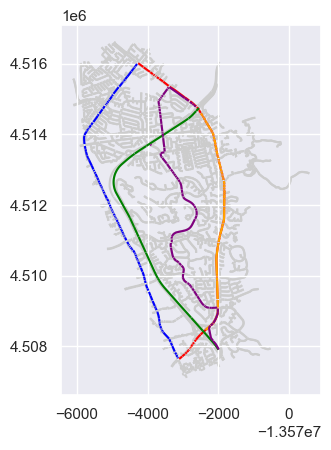

In [ ]:
road_comp_extra = {
    'mission_nb_past_osgood': [
        '30451', '31086', '35201', '35200', '35372', '35374', '32021'
    ],
    'osgood_nb_past_mission': [
        '35641', '35408', '30370', '35639', '35630', '28613', '28614', '36398', 
        '36399'
    ],
    'mission_nb_past_i680': [
        '30451', '31086', '35201', '35200', '30550', '30551', '30552', '30553', 
        '35202', '35203', '35204', '35205', '35207', '35208', '36289', '8535', 
        '7184', '7185', '9184', '3277', '7438', '7439', '7762', '7415', '7617', 
        '4872', '3858',  '27477', '55771', '55776', '35620', '35622', '35623', 
        '35624', '35375', '35372', '35374', '32021'
    ],
    'i680_nb_past_mission': [
        '3400', '2752', '2879'
    ],
    'paseo_padre_past_i680': [
        '3400', '2752', '4873', '7137', '266', '7136', '2881', '2879'
    ]
}

road_comp = {
    'mission_nb_vs_osgood': mission_northbound[~mission_northbound['eid'].isin(
        road_comp_extra['mission_nb_past_osgood'])],
    'osgood_nb_vs_mission': osgood_northbound[~osgood_northbound['eid'].isin(
        road_comp_extra['osgood_nb_past_mission'])],
    'mission_nb_vs_i680': mission_northbound[~mission_northbound['eid'].isin(
        road_comp_extra['mission_nb_past_i680'])],
    'i680_nb_vs_mission': i680_northbound[~i680_northbound['eid'].isin(
        road_comp_extra['i680_nb_past_mission'])],
    'paseo_padre_nb_vs_mission': paseo_padre_northbound[~paseo_padre_northbound['eid'].isin(
        road_comp_extra['paseo_padre_past_i680'])],
}

fig, ax = plt.subplots()
sections.plot(ax=ax, color='0.8', zorder=0)
road_comp['mission_nb_vs_osgood'].plot(color='red', ax=ax, zorder=1)
road_comp['osgood_nb_vs_mission'].plot(color='blue', ax=ax, zorder=1)
road_comp['mission_nb_vs_i680'].plot(color='orange', ax=ax, zorder=2)
road_comp['i680_nb_vs_mission'].plot(color='green', ax=ax, zorder=2)
road_comp['paseo_padre_nb_vs_mission'].plot(color='purple', ax=ax, zorder=2)

In [ ]:
def compare_roads(roads, folder_name):
    road_data = {}
    for scenario in to_plot:
        df = unpacked_databases_sect[scenario]
        df = df[df['ent']!=0]
        road_data[scenario] = {
            road: df[df['eid'].astype(str).isin(road_comp[road]['eid'])].groupby('ent').sum()
            for road in roads
        }

    for metric in tqdm(section_metrics):
        fig, axs = plt.subplots(1, len(to_plot), figsize=(6*len(to_plot), 4))
        combined = pd.concat([road_data[scenario][road][metric] 
                              for scenario in to_plot for road in roads])
        ymin, ymax = combined.min(), combined.max()
        for i in range(len(to_plot)):
            scenario = to_plot[i]
            ax = axs[i]
            for road in roads:
                ax.plot(TIME_INTERVALS_STRING, 
                        road_data[scenario][road][metric],
                        label=road)
            ax.set_title(unpacked_databases_sect[scenario]['desc'])
            ax.set_ylim(ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin))
            ax.set_xticks(np.arange(len(TIME_INTERVALS_STRING)))
            ax.set_xticklabels(TIME_INTERVALS_STRING, rotation=70)
            ax.legend(loc='upper right')
        fig.suptitle(f'{section_metrics[metric].desc} ({section_metrics[metric].unit})', size=18)
        save_fig(f'compare-road/{folder_name}/{metric}')
        plt.close()

compare_roads(['mission_nb_vs_osgood', 'osgood_nb_vs_mission'], 
              'mission_osgood_nb')
compare_roads(['mission_nb_vs_i680', 'i680_nb_vs_mission', 'paseo_padre_nb_vs_mission'], 
              'mission_i680_paseopadre_nb')

100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


#### Comparison of routes from `ext_9` to `ext_1` due to varied route choice in `fully_coordinated`

In [ ]:
routes = {
    1: ['151597063','151597067','151597070','2878','151627627','7154','2792','151597082','2793','8529','2889','267','35185','35189','30874','30875','30876','30877','30878','30879','35183'],
    2: ['253','257','151616494','56150','35417','35585','35579','35563','35585','35575','35585','35569','35571','35561','30671','35433','35432','35431','35430','35429','35428','30690','35483','35482','35463','30691','36360','37081','37086','36322','36323','36359','36347','31984','36329','36339','36335','36341','36342','36343','30630','30631','30632','35525','30640','36284','35488','35490','30376','30377','35631','35637'],
    3: ['253','7088','2759','7214','2757','7200','8608','8609','8610','7515','8524','8523','2893','8515','8514','8512','2894','2895','2896','7648','7645','7646','7647','8555','8554','7105','7106','7100','7102','7099','7512','7513','7514','7506','3749','3757','2770','7163','7173','7167','35185','35189','30874','30875','30876','30877','30878','30879','35183'],
    4: ['253','7088','2759','7214','2757','7200','8608','8609','8610','7515','1579','1578','1580','1581','1582','1583','1515','1514','1513','1512','1511','1510','1509','1508','7661','7662','7645','7646','7647','8555','8554','7105','7106','7100','7102','7099','7512','7513','7514','7506','3749','3757','2770','7163','7173','7167','35185','35189','30874','30875','30876','30877','30878','30879','35183'],
    5: ['253','7088','2759','7214','2757','7200','8608','8609','8610','7515','1579','1578','1580','1581','1582','1583','1488','2894','2895','2896','7648','7645','7646','7647','8555','8554','7105','7106','7100','7102','7099','7512','7513','7514','7506','3749','3757','2770','7163','7173','7167','35185','35189','30874','30875','30876','30877','30878','30879','35183'],
    6: ['253','7088','2759','7214','2757','7200','8608','8609','8610','7515','1579','1578','1580','1581','1582','1583','1515','1514','1513','1512','1511','1510','1509','1508','30203','35469','37094','30691','36360','37081','37086','36322','36323','36359','36347','31984','36329','36339','36335','36341','36342','36343','30630','30631','30632','35525','30640','36284','35488','35490','30376','30377','35631','35637']
}

route_sections = {
    253: {'desc': 'I-680/auto mall off ramp', 'length': 268, 'speed-limit': 104},
    257: {'desc': 'I-680/auto mall off ramp wb', 'length': 44, 'speed-limit': 104},
    7088: {'desc': 'I-680/auto mall off ramp eb', 'length': 54, 'speed-limit': 104},
    151597063: {'desc': 'I-680 sb adjacent to auto mall pkwy off ramp', 'length': 66, 'speed-limit': 104},
    151597067: {'desc': 'I-680 south of prev', 'length': 106, 'speed-limit': 104},
    151597070: {'desc': 'I-680 south of prev', 'length': 46, 'speed-limit': 104},
    2878: {'desc': 'I-680 south of prev', 'length': 172, 'speed-limit': 104},
    151627627: {'desc': 'I-680 south of prev', 'length': 330, 'speed-limit': 104},
    7154: {'desc': 'I-680 south of prev', 'length': 353, 'speed-limit': 104},
    2792: {'desc': 'I-680 south of prev', 'length': 44, 'speed-limit': 104},
    151597082: {'desc': 'I-680 south of prev', 'length': 536, 'speed-limit': 104},
    2793: {'desc': 'I-680 south of prev', 'length': 181, 'speed-limit': 104},
    8529: {'desc': 'I-680 sb adjacent to mission off ramp', 'length': 149, 'speed-limit': 104},
    2889: {'desc': 'I-680/mission off ramp part 1', 'length': 295, 'speed-limit': 104},
    267: {'desc': 'I-680/mission off ramp part 2', 'length': 473, 'speed-limit': 40},
    151616494: {'desc': 'auto mall wb adj west I-680', 'length': 17, 'speed-limit': 72},
    56150: {'desc': 'auto mall wb adj east osgood / west of prev', 'length': 87, 'speed-limit': 72},
    2759: {'desc': 'auto mall eb adj east I-680', 'length': 106, 'speed-limit': 72},
    7214: {'desc': 'auto mall eb east of prev', 'length': 8, 'speed-limit': 64},
    2757: {'desc': 'durham east of prev', 'length': 27, 'speed-limit': 64},
    7200: {'desc': 'durham east of prev', 'length': 48, 'speed-limit': 64},
    8608: {'desc': 'durham east of prev', 'length': 33, 'speed-limit': 64},
    8609: {'desc': 'durham east of prev', 'length': 89, 'speed-limit': 64},
    8610: {'desc': 'durham east of prev', 'length': 284, 'speed-limit': 64},
    7515: {'desc': 'durham adj west arapaho / east of prev', 'length': 87, 'speed-limit': 64},
    8524: {'desc': 'durham east of prev', 'length': 24, 'speed-limit': 64},
    8523: {'desc': 'durham adj west paseo padre / east of prev', 'length': 99, 'speed-limit': 64},
    35417: {'desc': 'osgood adj south of auto mall', 'length': 58, 'speed-limit': 64},
    35585: {'desc': 'osgood south of prev', 'length': 26, 'speed-limit': 64},
    35579: {'desc': 'osgood south of prev', 'length': 26, 'speed-limit': 64},
    35563: {'desc': 'osgood south of prev', 'length': 34, 'speed-limit': 64},
    35585: {'desc': 'osgood south of prev', 'length': 26, 'speed-limit': 64},
    35575: {'desc': 'osgood south of prev', 'length': 29, 'speed-limit': 64},
    35585: {'desc': 'osgood south of prev', 'length': 26, 'speed-limit': 64},
    35569: {'desc': 'osgood south of prev', 'length': 54, 'speed-limit': 64},
    35571: {'desc': 'osgood south of prev', 'length': 22, 'speed-limit': 64},
    35565: {'desc': 'osgood south of prev', 'length': 12, 'speed-limit': 64},
    35561: {'desc': 'osgood south of prev', 'length': 30, 'speed-limit': 64},
    30671: {'desc': 'osgood south of prev', 'length': 27, 'speed-limit': 64},
    35413: {'desc': 'osgood south of prev', 'length': 28, 'speed-limit': 64},
    35433: {'desc': 'osgood south of prev', 'length': 17, 'speed-limit': 64},
    35432: {'desc': 'osgood south of prev', 'length': 13, 'speed-limit': 64},
    35431: {'desc': 'osgood south of prev', 'length': 67, 'speed-limit': 64},
    35430: {'desc': 'osgood south of prev', 'length': 19, 'speed-limit': 64},
    35429: {'desc': 'osgood south of prev', 'length': 40, 'speed-limit': 64},
    35428: {'desc': 'osgood south of prev', 'length': 90, 'speed-limit': 64},
    30690: {'desc': 'osgood south of prev', 'length': 48, 'speed-limit': 64},
    35483: {'desc': 'osgood south of prev', 'length': 44, 'speed-limit': 64},
    35482: {'desc': 'osgood south of prev', 'length': 83, 'speed-limit': 64},
    35463: {'desc': 'osgood adj north sgrimmer / south of prev', 'length': 53, 'speed-limit': 64},
    37094: {'desc': 'warm springs adj south sgrimmer / south of prev', 'length': 18, 'speed-limit': 56},
    30691: {'desc': 'warm springs south of prev', 'length': 62, 'speed-limit': 56},
    36360: {'desc': 'warm springs south of prev', 'length': 64, 'speed-limit': 56},
    37081: {'desc': 'warm springs south of prev', 'length': 201, 'speed-limit': 56},
    37086: {'desc': 'warm springs south of prev', 'length': 48, 'speed-limit': 56},
    36322: {'desc': 'warm springs south of prev', 'length': 51, 'speed-limit': 56},
    36323: {'desc': 'warm springs south of prev', 'length': 71, 'speed-limit': 56},
    36359: {'desc': 'warm springs south of prev', 'length': 29, 'speed-limit': 56},
    36347: {'desc': 'warm springs south of prev', 'length': 6, 'speed-limit': 56},
    31984: {'desc': 'warm springs south of prev', 'length': 152, 'speed-limit': 56},
    36329: {'desc': 'warm springs south of prev', 'length': 66, 'speed-limit': 56},
    36339: {'desc': 'warm springs south of prev', 'length': 26, 'speed-limit': 56},
    36335: {'desc': 'warm springs south of prev', 'length': 42, 'speed-limit': 56},
    36341: {'desc': 'warm springs south of prev', 'length': 48, 'speed-limit': 56},
    36342: {'desc': 'warm springs south of prev', 'length': 9, 'speed-limit': 56},
    36343: {'desc': 'warm springs south of prev', 'length': 11, 'speed-limit': 56},
    30630: {'desc': 'warm springs south of prev', 'length': 32, 'speed-limit': 56},
    30631: {'desc': 'warm springs south of prev', 'length': 17, 'speed-limit': 56},
    30632: {'desc': 'warm springs south of prev', 'length': 184, 'speed-limit': 56},
    35525: {'desc': 'warm springs south of prev', 'length': 65, 'speed-limit': 56},
    30640: {'desc': 'warm springs south of prev', 'length': 6, 'speed-limit': 56},
    36284: {'desc': 'warm springs south of prev', 'length': 65, 'speed-limit': 56},
    35488: {'desc': 'warm springs south of prev', 'length': 33, 'speed-limit': 56},
    35490: {'desc': 'warm springs south of prev', 'length': 94, 'speed-limit': 56},
    30376: {'desc': 'warm springs south of prev', 'length': 8, 'speed-limit': 56},
    30377: {'desc': 'warm springs south of prev', 'length': 6, 'speed-limit': 56},
    35631: {'desc': 'warm springs south of prev', 'length': 16, 'speed-limit': 56},
    35637: {'desc': 'warm springs adj north of mission / south of prev', 'length': 101, 'speed-limit': 56},
    3749: {'desc': 'mission adj south of paseo padre', 'length': 414, 'speed-limit': 72},
    3757: {'desc': 'mission south of prev', 'length': 151, 'speed-limit': 72},
    2770: {'desc': 'mission south of prev', 'length': 105, 'speed-limit': 72},
    7163: {'desc': 'mission south of prev', 'length': 61, 'speed-limit': 72},
    7173: {'desc': 'mission south of prev', 'length': 99, 'speed-limit': 72},
    7167: {'desc': 'mission south of prev', 'length': 61, 'speed-limit': 72},
    35185: {'desc': 'mission south of prev', 'length': 101, 'speed-limit': 72},
    35189: {'desc': 'mission south of prev', 'length': 53, 'speed-limit': 72},
    30874: {'desc': 'mission south of prev', 'length': 19, 'speed-limit': 72},
    30875: {'desc': 'mission south of prev', 'length': 30, 'speed-limit': 72},
    30876: {'desc': 'mission south of prev', 'length': 38, 'speed-limit': 72},
    30877: {'desc': 'mission south of prev', 'length': 39, 'speed-limit': 72},
    30878: {'desc': 'mission south of prev', 'length': 50, 'speed-limit': 72},
    30879: {'desc': 'mission south of prev', 'length': 8, 'speed-limit': 72},
    35183: {'desc': 'mission east adj warm springs / south of prev', 'length': 59, 'speed-limit': 72},
    2893: {'desc': 'paseo padre south adj durham', 'length': 55, 'speed-limit': 56},
    8516: {'desc': 'paseo padre south of prev', 'length': 48, 'speed-limit': 56},
    8515: {'desc': 'paseo padre south of prev', 'length': 54, 'speed-limit': 56},
    8514: {'desc': 'paseo padre south of prev', 'length': 148, 'speed-limit': 56},
    8512: {'desc': 'paseo padre adj north parkmeadow / south of prev', 'length': 83, 'speed-limit': 56},
    2894: {'desc': 'paseo padre adj south parkmeadow / south of prev', 'length': 165, 'speed-limit': 56},
    2895: {'desc': 'paseo padre south of prev', 'length': 73, 'speed-limit': 56},
    2896: {'desc': 'paseo padre south of prev', 'length': 117, 'speed-limit': 56},
    7648: {'desc': 'paseo padre adj north s grimmer / south of prev', 'length': 53, 'speed-limit': 56},
    7645: {'desc': 'paseo padre adj south s grimmer / south of prev', 'length': 243, 'speed-limit': 56},
    7646: {'desc': 'paseo padre south of prev', 'length': 9, 'speed-limit': 56},
    7647: {'desc': 'paseo padre south of prev', 'length': 93, 'speed-limit': 56},
    8555: {'desc': 'paseo padre south of prev', 'length': 48, 'speed-limit': 56},
    8554: {'desc': 'paseo padre south of prev', 'length': 36, 'speed-limit': 56},
    7105: {'desc': 'paseo padre south of prev', 'length': 37, 'speed-limit': 56},
    7106: {'desc': 'paseo padre south of prev', 'length': 59, 'speed-limit': 56},
    7100: {'desc': 'paseo padre south of prev', 'length': 68, 'speed-limit': 56},
    7102: {'desc': 'paseo padre south of prev', 'length': 225, 'speed-limit': 56},
    7099: {'desc': 'paseo padre south of prev', 'length': 34, 'speed-limit': 56},
    7512: {'desc': 'paseo padre south of prev', 'length': 131, 'speed-limit': 56},
    7513: {'desc': 'paseo padre east of prev', 'length': 59, 'speed-limit': 56},
    7514: {'desc': 'paseo padre east of prev', 'length': 31, 'speed-limit': 56},
    7506: {'desc': 'paseo padre adj west mission / east of prev', 'length': 70, 'speed-limit': 56},
    30203: {'desc': 's grimmer wb adj west parkmeadow', 'length': 354, 'speed-limit': 64},
    35469: {'desc': 's grimmer wb adj east warm springs / west of prev', 'length': 37, 'speed-limit': 64},
    7661: {'desc': 's grimmer eb adj east parkmeadow', 'length': 186, 'speed-limit': 64},
    7662: {'desc': 's grimmer eb adj west paseo padre / east of prev', 'length': 210, 'speed-limit': 64},
    1579: {'desc': 'arapaho adj south durham', 'length': 45, 'speed-limit': 40},
    1578: {'desc': 'arapaho south of prev', 'length': 62, 'speed-limit': 40},
    1580: {'desc': 'arapaho south of prev', 'length': 31, 'speed-limit': 40},
    1581: {'desc': 'arapaho south of prev', 'length': 57, 'speed-limit': 40},
    1582: {'desc': 'arapaho south of prev', 'length': 28, 'speed-limit': 40},
    1583: {'desc': 'arapaho adj north parkmeadow / south of prev', 'length': 149, 'speed-limit': 40},
    1488: {'desc': 'parkmeadow eb adj east arapaho', 'length': 60, 'speed-limit': 40},
    1515: {'desc': 'parkmeadow sb adj west arapaho', 'length': 52, 'speed-limit': 40},
    1514: {'desc': 'parkmeadow sb south of prev', 'length': 106, 'speed-limit': 40},
    1513: {'desc': 'parkmeadow sb south of prev', 'length': 37, 'speed-limit': 40},
    1512: {'desc': 'parkmeadow sb south of prev', 'length': 56, 'speed-limit': 40},
    1511: {'desc': 'parkmeadow sb south of prev', 'length': 52, 'speed-limit': 40},
    1510: {'desc': 'parkmeadow sb south of prev', 'length': 31, 'speed-limit': 40},
    1509: {'desc': 'parkmeadow sb south of prev', 'length': 42, 'speed-limit': 40},
    1508: {'desc': 'parkmeadow sb adj north s grimmer / south of prev', 'length': 49, 'speed-limit': 40},
}

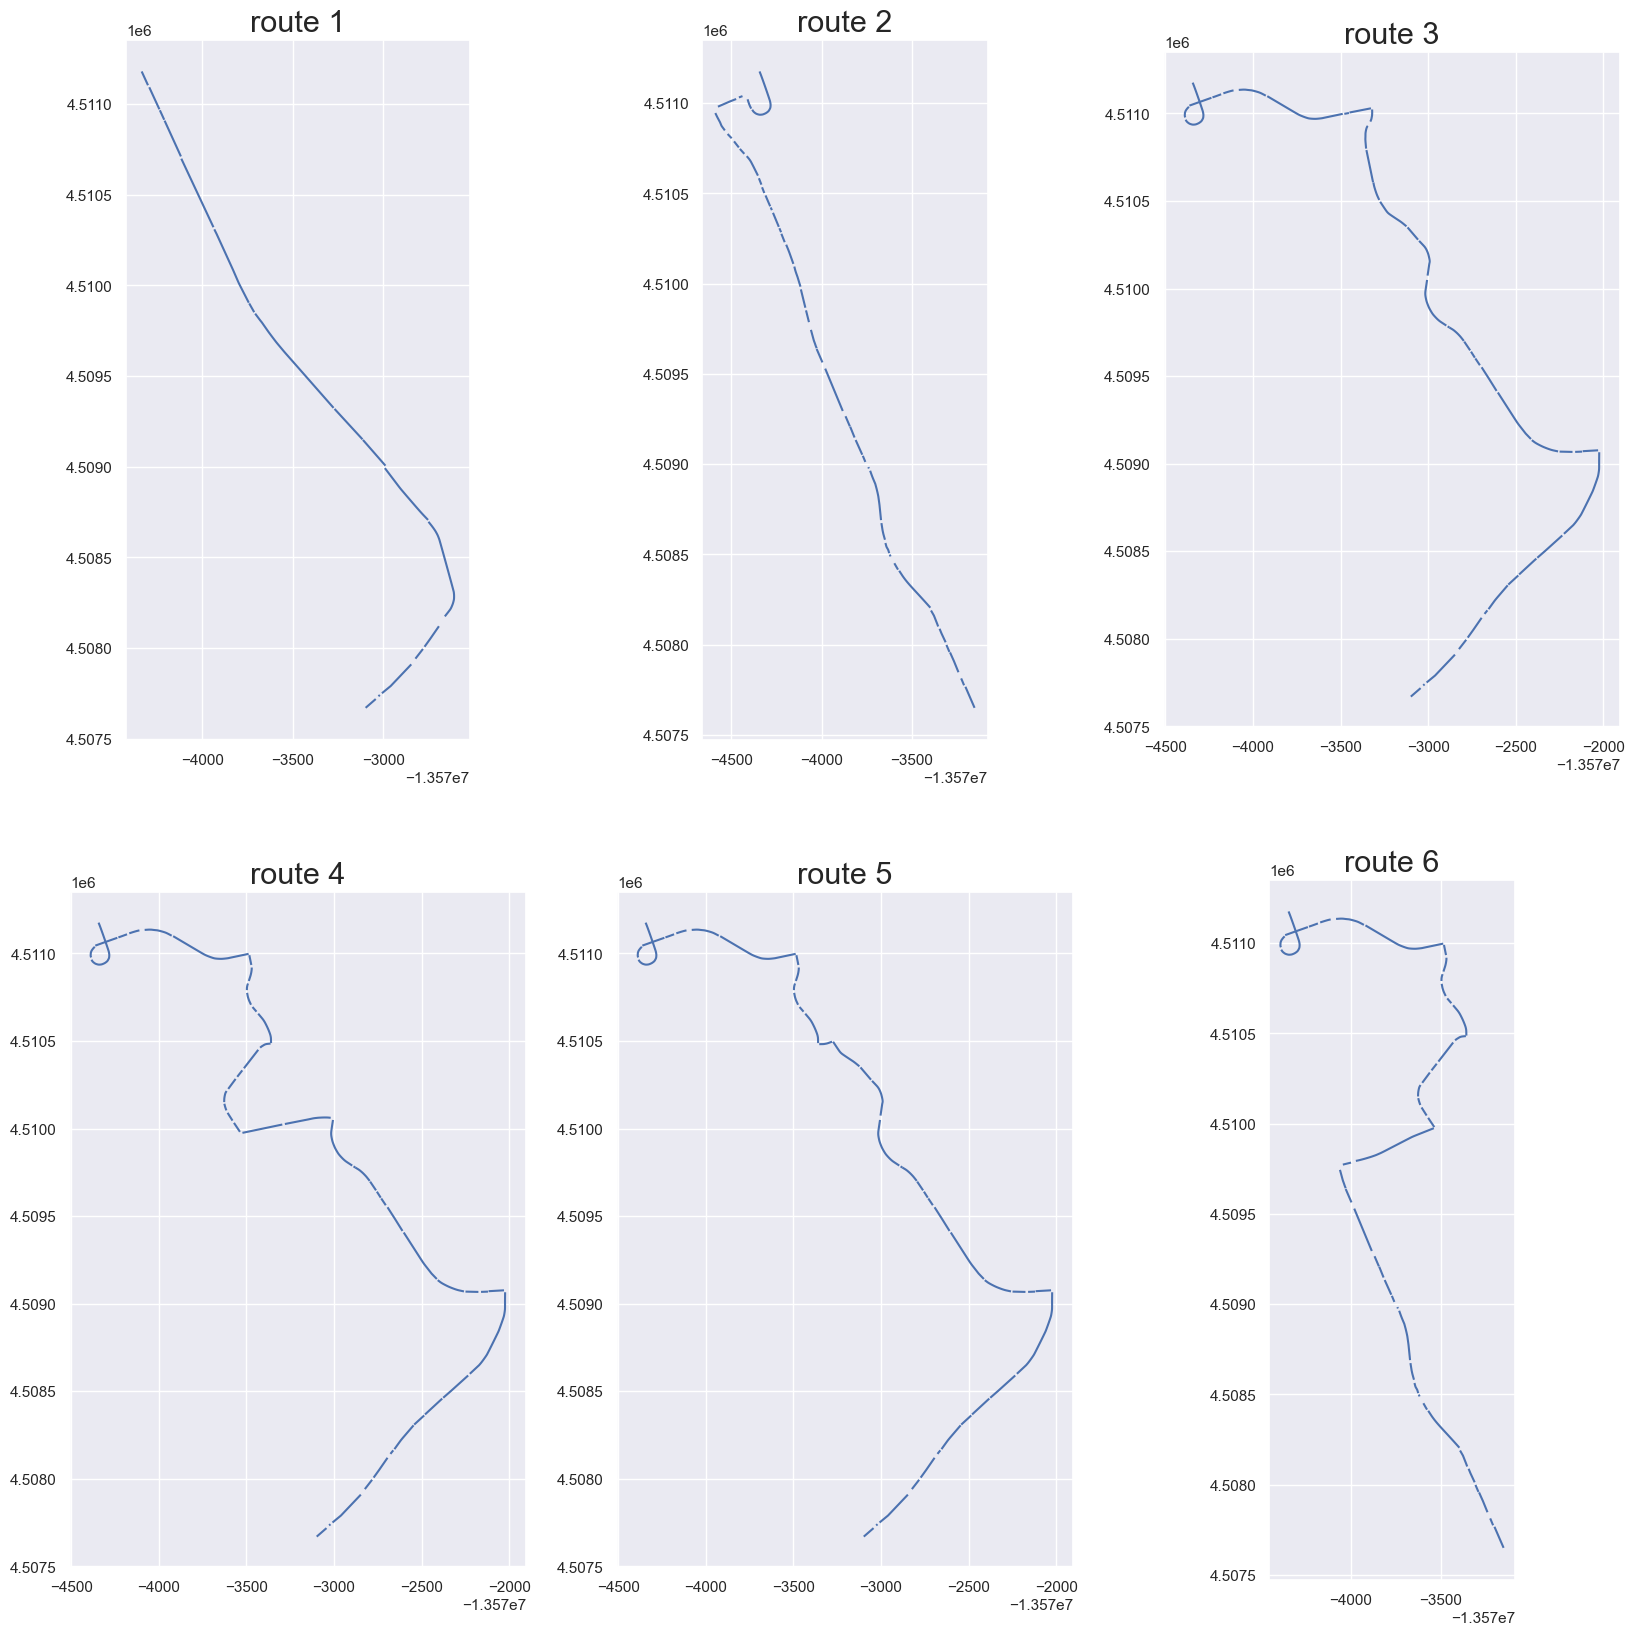

In [ ]:
frame_routes = {k: frame[frame.index.isin(routes[k])] for k in routes}
fig, axs = plt.subplots(2, 3, figsize=(20,20))
for k in frame_routes:
    ax = axs[(k-1)//3][(k-1)%3]
    # sections.plot(ax=ax, color='0.8', lw=0.5, zorder=0)
    frame_routes[k].plot(ax=ax, zorder=1)
    ax.set_title(f'route {k}', size=22)
    # ax.axis('off')
plt.show()

Sum of travel times of their constituent road sections, aggregated over time

In [ ]:
for k in frame_routes:
    print(f"Route {k}")
    for suffix in ['uncoordinated', 'coordinated']:
        print(f"{suffix} travel time (s): {np.sum(frame_routes[k]['ttime_'+suffix])}")
    dist = 0
    for sec in frame_routes[k].index:
        dist += route_sections[int(sec)]['length']
    print(f"distance (km): {dist/1000}\n")

Route 1
uncoordinated travel time (s): 305.27992741770277
coordinated travel time (s): 329.9626649706389
distance (km): 2.988

Route 2
uncoordinated travel time (s): 417.1487534374807
coordinated travel time (s): 332.77460126024897
distance (km): 2.417

Route 3
uncoordinated travel time (s): 312.80979734275655
coordinated travel time (s): 342.4611934246018
distance (km): 3.454

Route 4
uncoordinated travel time (s): 340.58479229740595
coordinated travel time (s): 444.33846589288487
distance (km): 3.893

Route 5
uncoordinated travel time (s): 306.1568398055352
coordinated travel time (s): 370.67665603271655
distance (km): 3.423

Route 6
uncoordinated travel time (s): 382.8759066008538
coordinated travel time (s): 417.56727721859886
distance (km): 3.146



[DEPRECATED] Simulated travel time across Mission Blvd at 100% demand (in place of $l/v$)

In [ ]:
assert COMPARISON_MODE == '100'
unpacked_databases_sect_partial = unpack_databases('MISECT', ['fully_coordinated', 'fully_coordinated_run_two', 'fully_coordinated_run_three', 'fully_coordinated_averaged'])

lv_mission_nb: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]                


speed_y
40.0    53.114319
56.0    53.476135
64.0    63.934088
72.0    61.930401
Name: speed_x, dtype: float64

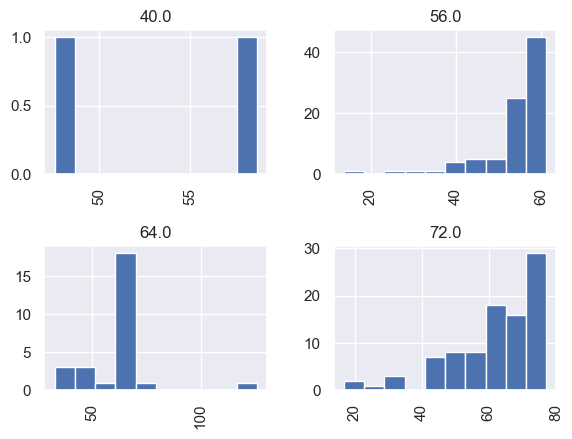

In [ ]:
def restrict_sections(df, sections):
    df = df[(df['ent']==0) & (df['sid']==0)]
    df = df[df['eid'].isin(sections['eid'])]
    df = df.merge(sections, on='eid')
    df = gpd.GeoDataFrame(df)
    df['speed_x'].hist(by=df['speed_y'])
    return df.groupby('speed_y').mean()['speed_x']

restrict_sections(
    unpacked_databases_sect_partial['fully_coordinated_averaged']['database'],
    mission_sections
)

[DEPRECATED] The following code will not work for many cases due to weird geometries of nodes / opposite side of the road etc.

In [ ]:
from shapely.ops import nearest_points, transform
from shapely.geometry import MultiPoint

METRIC = section_metrics['ttime']
ROAD = 'mission'
SIGNALIZED_NODES = None

if ROAD == 'mission':
	ROAD = ['Mission Boulevard']
	SIGNALIZED_NODES = ['56451', '62795', '16827', '27954', '27938', '27921', '27889', '27869', '27847', '13225', '27816', '27796', '27479', '56218', '42160']
if ROAD in ('warm springs', 'osgood', 'driscoll'):
	ROAD = ['Driscoll Road', 'Osgood Road', 'Warm Springs Boulevard']
	SIGNALIZED_NODES = ['56438', '56451', '45371', '53579', '38460', '45004', '56471', '62346', '56418', '62356', '56391', '56297', '56244', '56218']
if isinstance(ROAD, str):
	ROAD = [ROAD]
	assert SIGNALIZED_NODES

def mean_y(linestring):
	bbox = linestring.bounds
	return (bbox[1] + bbox[3]) / 2

road_sections = frame[frame.index.isin(sections[sections['name'].isin(ROAD)]['eid'])] \
	[[f'{METRIC.name}_coordinated', 'geometry']]
road_sections['y'] = road_sections['geometry'].apply(mean_y)
road_signalized_nodes = nodes[nodes['eid'].isin(SIGNALIZED_NODES)]

for _, row in road_sections.iterrows():
	pass # not sure what used to go here

IndentationError: expected an indented block (1662079486.py, line 27)

In [ ]:
from shapely.ops import nearest_points, transform
from shapely.geometry import MultiPoint

METRIC = section_metrics['ttime']
ROAD = 'osgood'

if ROAD == 'mission':
	ROAD = ['Mission Boulevard']
if ROAD in ('warm springs', 'osgood', 'driscoll'):
	ROAD = ['Driscoll Road', 'Osgood Road', 'Warm Springs Boulevard']
if isinstance(ROAD, str):
	ROAD = [ROAD]

def round_coordinates(geom, n_digits=3):
	round_coords = lambda x, y : (round(x, n_digits), round(y, n_digits))
	return transform(round_coords, geom)

rounded_sections = sections.copy()
rounded_nodes = nodes.copy().drop(columns='name').dropna()
rounded_nodes['eid'] = rounded_nodes['id'].apply(lambda x: str(int(x)))
rounded_sections['geometry'] = rounded_sections['geometry'].apply(round_coordinates)
rounded_nodes['geometry'] = rounded_nodes['geometry'].apply(round_coordinates)
road_sections = frame[frame.index.isin(rounded_sections[rounded_sections['name'].isin(ROAD)]['eid'])] \
	[[f'{METRIC.name}_coordinated', 'geometry']]
for i in range(2):
	road_sections[f'endpoint_{i}'] = road_sections['geometry'].apply(
		lambda section: section.boundary[i])

points = set(rounded_nodes['geometry']) | set(road_sections['endpoint_0']) | set(road_sections['endpoint_1'])
mp_str_to_geo = {str(p): p for p in points}
node_geo_to_eid = {str(row['geometry']): row['eid'] for _, row in rounded_nodes.iterrows()}
node_eid_to_geo = {row['eid']: row['geometry'] for _, row in rounded_nodes.iterrows()}
signalized_ids = list(signalized_nodes['city-controlled'].keys()) + list(signalized_nodes['state-controlled'].keys())

G = {str(p): set() for p in points}
for _, row in road_sections.iterrows():
	u, v = row['endpoint_node_0'], row['endpoint_node_1']
	if u and v:
		G[u].add(v)
		G[v].add(u)
	mp = points.copy()
	mp.remove(u)
	mp.remove(v)
	mp = MultiPoint(mp)
	

def bfs(start, exclude):
	"""Returns the id of the nearest signalized node from `start`,
	or None if no such node exists"""
	q = []
	q.append(start)
	visited = {exclude}
	start_node = node_eid_to_geo[start]
	exclude_node = node_eid_to_geo[exclude]

	while q:
		u = q.pop(0)
		u_node = node_eid_to_geo[u]
		visited.add(u)
		if u in signalized_ids:
			return u
		for v in G[u]:
			if v not in visited:
				v_node = node_eid_to_geo[v]
				if start_node.distance(u_node) < start_node.distance(v_node) < exclude_node.distance(v_node):
					q.append(v)

signalized_to_sections = {(u, v): [] for u in signalized_ids for v in signalized_ids}
for _, row in road_sections.iterrows():
	eid, u, v = row.name, row['endpoint_node_0'], row['endpoint_node_1']
	z, w = bfs(u, v), bfs(v, u)
	if z and w:
		signalized_to_sections[(z, w)].append(eid)
signalized_to_sections = {k: v for k, v in signalized_to_sections.items() if v}

def signalized_dist(u, v):
	get_dist = lambda section: road_sections.loc[section][f'{METRIC.name}_coordinated']
	return sum(map(get_dist, signalized_to_sections[(u, v)]))

print(f"{', '.join(ROAD)} - {METRIC.name} ({METRIC.unit})")
for u, v in signalized_to_sections:
	print(f"{u} to {v}: {round(signalized_dist(u, v), 1)}")

print(signalized_to_sections[('56391', '56391')])
print(road_sections.loc['35250'])

# keeping this because some were annoying to write
fig, ax = plt.subplots(figsize=(20,30))
rounded_sections.plot(ax=ax, color='0.8', zorder=0)
rounded_nodes[rounded_nodes['eid'].isin(signalized_ids)].plot(ax=ax, color='orange', zorder=1)
for bruh in ['35250']:
	ax.plot(*road_sections.loc[bruh]['geometry'].xy, color='green', zorder=2)
# for bruh in ['2768', '7385', '9403']:
# 	ax.plot(*road_sections.loc[bruh]['geometry'].xy, color='purple', zorder=2)
investigating = ('56391',)
for i in range(len(investigating)):
	# print(node_eid_to_geo[investigating[i]])
	ax.plot(*node_eid_to_geo[investigating[i]].xy, 'ro', color='blue' if i else 'red', zorder=3)
# first, last = road_sections.loc['2770']['geometry'].boundary
# _, near = nearest_points(first, LineString(nodes['geometry']))
# print(nodes[nodes['geometry']==near].iloc[0]['eid'])
# ax.plot(*road_sections.loc[bruh]['geometry'].xy, color='blue', zorder=1)
# ax.plot(*near.xy, 'ro', zorder=2)
# print(near)

TypeError: unhashable type: 'Point'

#### Plot restrictions to altered Mission Blvd/Osgood Road segments

In [ ]:
unpacked_databases_sect_partial = unpack_databases(
    'MISECT', 
    ['fully_uncoordinated', 'mission_partially_uncoordinated', 
     'osgood_partially_uncoordinated', 'fully_coordinated'], 
    False)

Processed System Fully Uncoordinated
Processed Mission Blvd Partially Uncoordinated
Processed Osgood Road Partially Uncoordinated
Processed System Fully Coordinated


In [ ]:
for k, v in unpacked_databases_sect_partial.items():
    unpacked_databases_sect_partial[k]['database'] = preprocess_sections(v['database']).groupby('eid').mean()

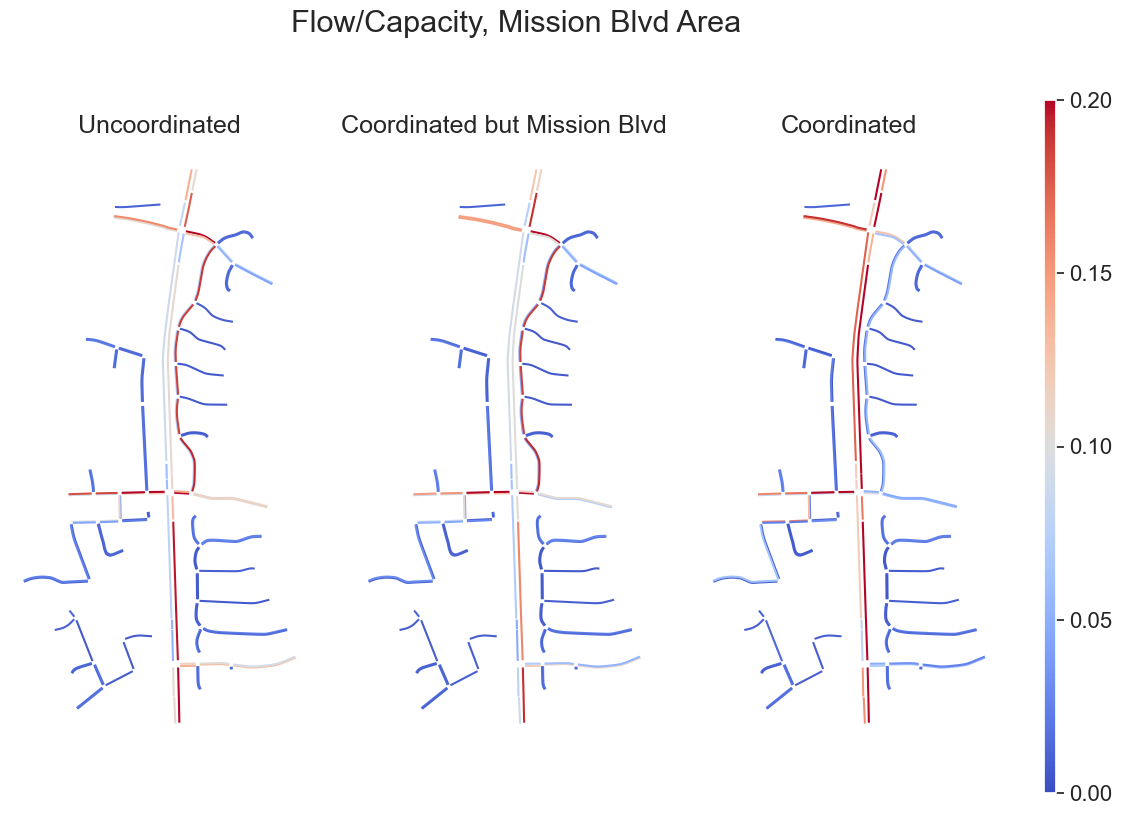

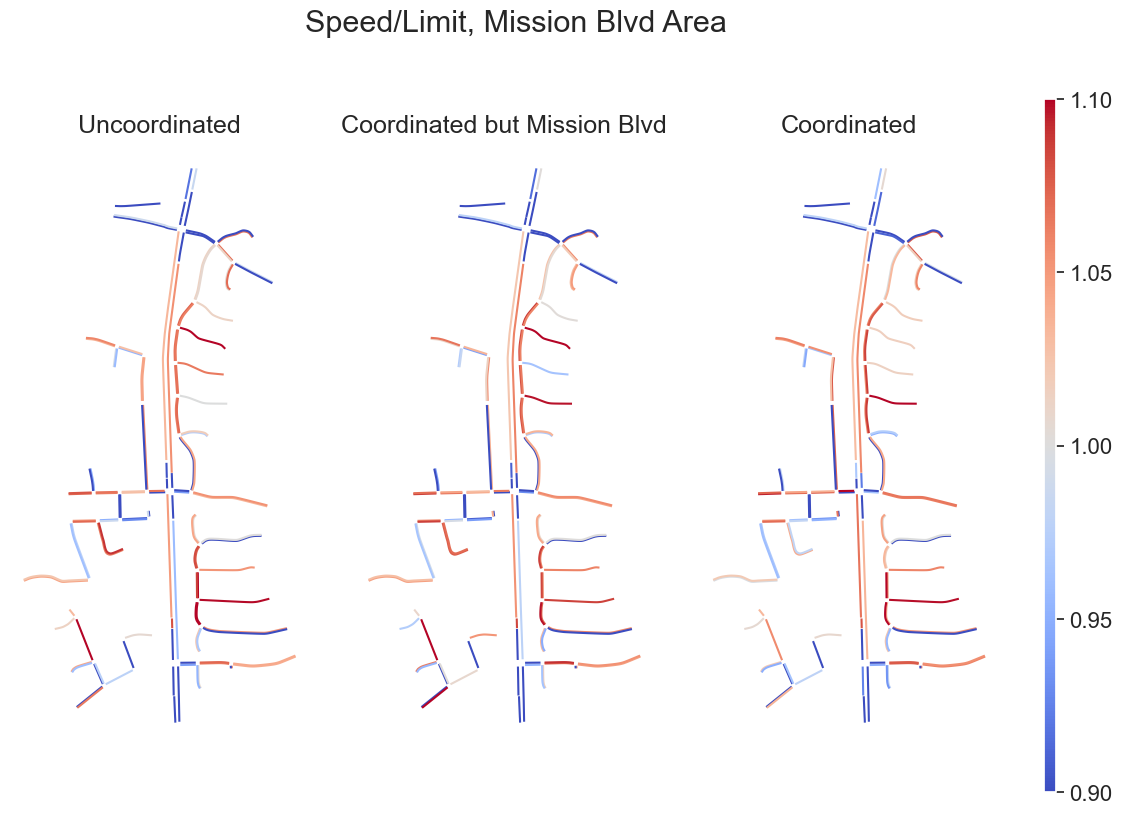

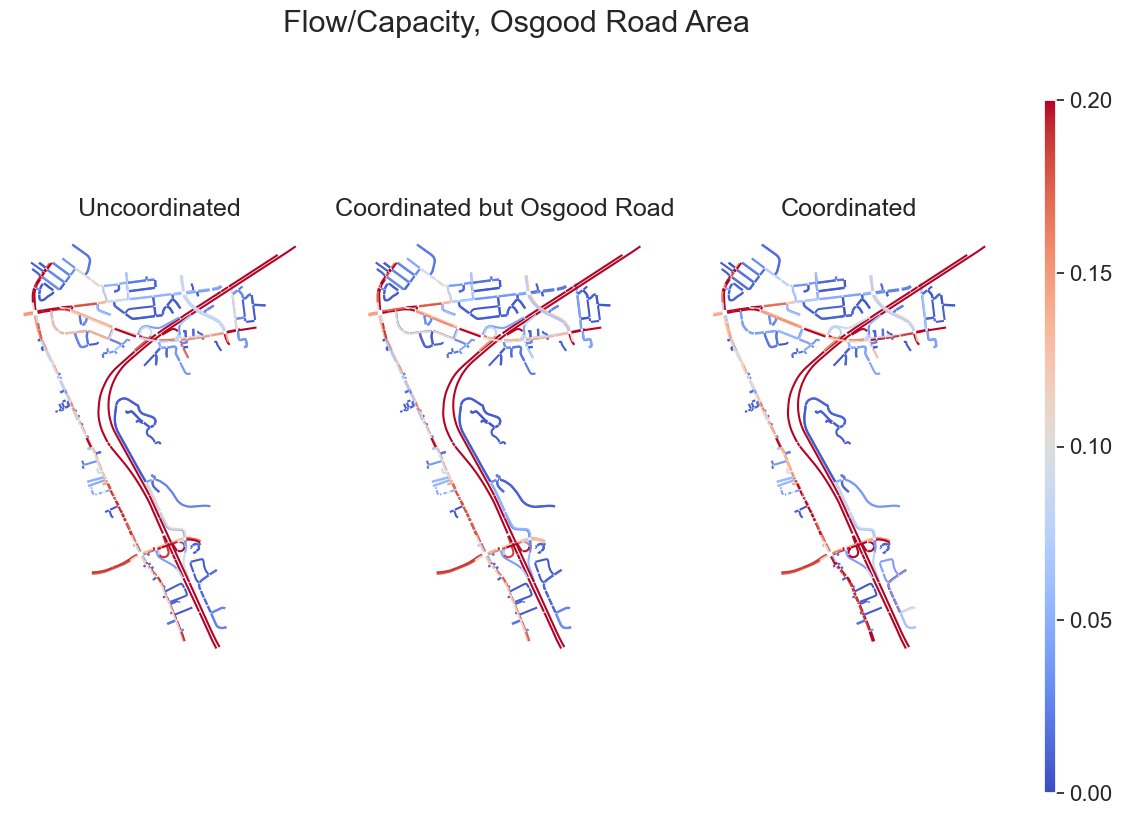

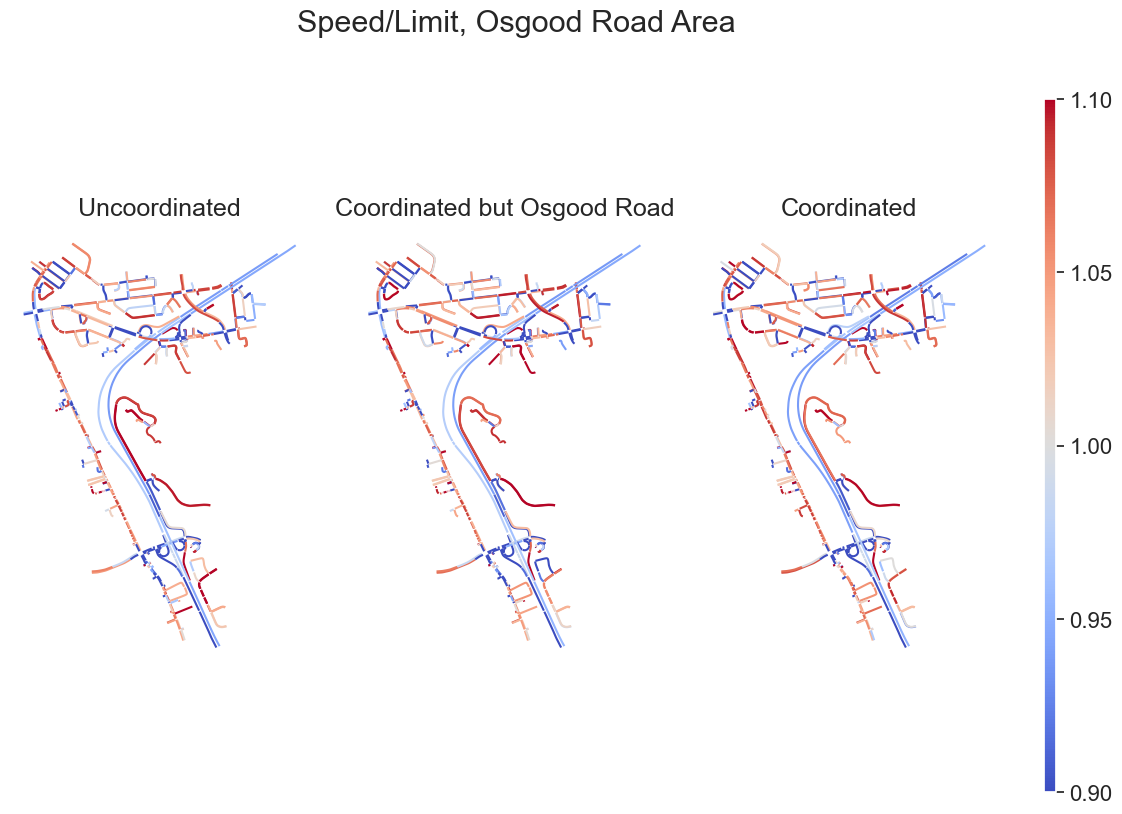

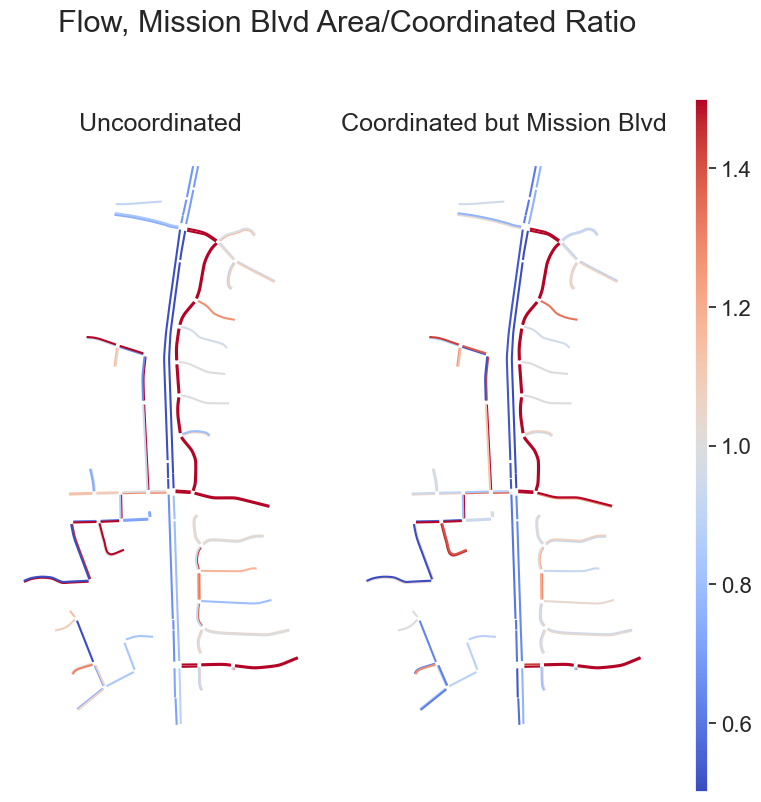

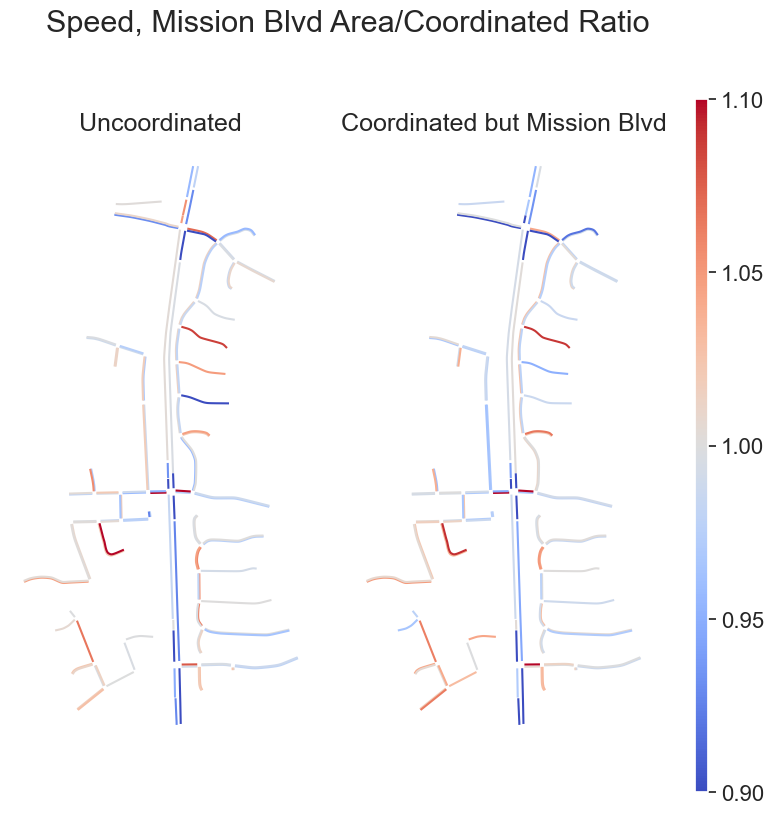

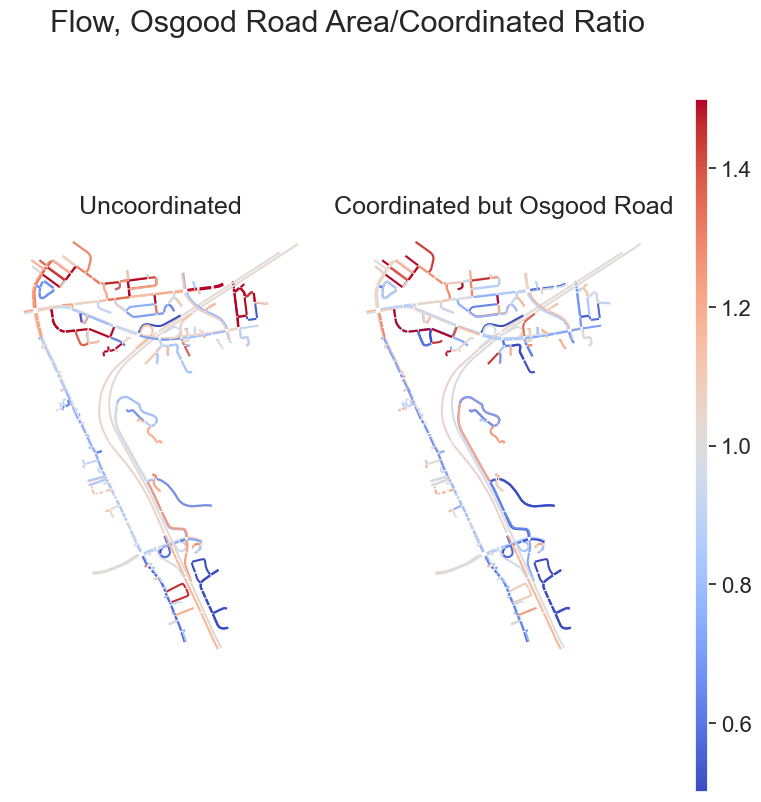

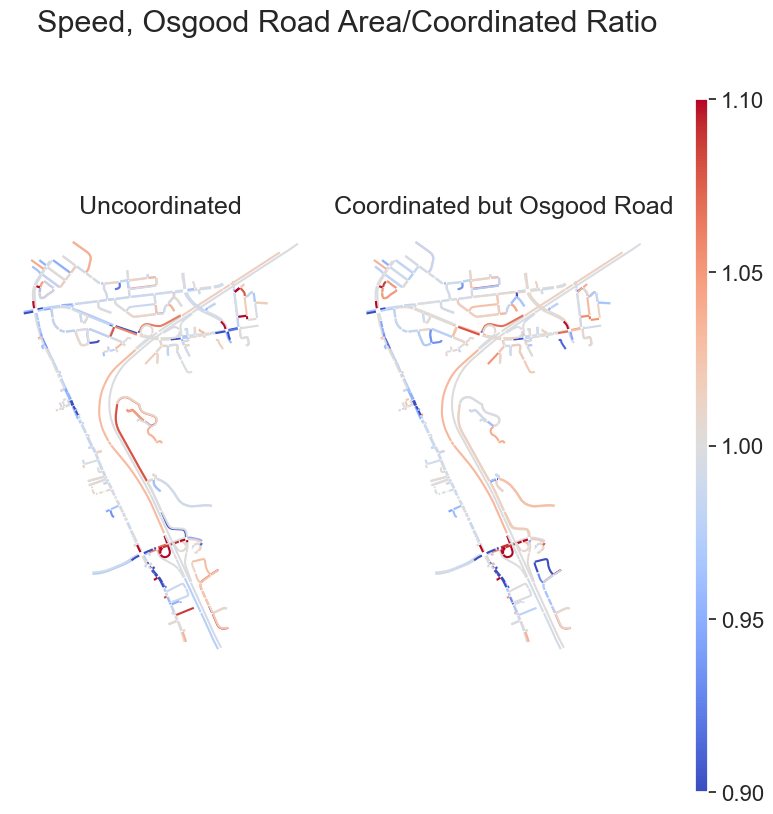

In [ ]:
local_frame = pd.concat(
    [unpacked_databases_sect_partial[k]['database'].add_suffix('_'+k) 
        for k in unpacked_databases_sect_partial],
    axis=1,
    join='inner'
).merge(sections, left_on='eid', right_on='eid').set_index('eid')

local_frame = gpd.GeoDataFrame(local_frame, geometry='geometry').to_crs("EPSG:3857")
local_frames = {
    'mission': {
        'desc': 'Mission Blvd Area',
        'database': local_frame[local_frame.index.isin(sections_near_mission['eid'])],
        'to_plot': ['fully_uncoordinated', 'mission_partially_uncoordinated', 'fully_coordinated']
    },
    'osgood': {
        'desc': 'Osgood Road Area',
        'database': local_frame[local_frame.index.isin(sections_near_osgood['eid'])],
        'to_plot': ['fully_uncoordinated', 'osgood_partially_uncoordinated', 'fully_coordinated']
    }
}

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def plot_local(mode):
    """
    There are two modes:
    `mode` = 'standard': Plots all entries in 'to_plot'
    `mode` = 'compare': Uses 'to_plot[-1]' as a "comparison" scenario, to 
                        which all other entries in `which` are compared 
                        via ratio
    """
    plot_bounds = {
        'standard': {
            'flow': (0, 0.2),
            'speed': (0.9, 1.1),
        },
        'compare': {
            'flow': (0.5, 1.5),
            'speed': (0.9, 1.1)
        }
    }
    
    for name in local_frames:
        df, to_plot = local_frames[name]['database'], local_frames[name]['to_plot']
        if mode == 'standard':
            for suffix in to_plot:
                df['flow/capacity_' + suffix] = df['flow_' + suffix] / df['capacity']
                df['speed/limit_' + suffix] = df['speed_' + suffix] / df['speed']
        if mode == 'compare':
            compare_to = to_plot[-1]
            to_plot = to_plot[:-1]
            for suffix in to_plot:
                df['flow_' + suffix + '_ratio'] = df['flow_' + suffix] / df['flow_' + compare_to]
                df['speed_' + suffix + '_ratio'] = df['speed_' + suffix] / df['speed_' + compare_to]
        df.fillna(0)

        for metric in ['Flow/Capacity', 'Speed/Limit']:
            abbrev_metric = metric.split('/')[0]
            vmin, vmax = plot_bounds[mode][abbrev_metric.lower()]
            fig, axs = plt.subplots(1, len(to_plot) + 1, 
                figsize=(4.5*len(to_plot), 9), gridspec_kw={'width_ratios': [50]*len(to_plot)+[2]})
            norm = Normalize(vmin=vmin, vmax=vmax)
            cb = ColorbarBase(axs[-1], cmap='coolwarm', norm=norm, orientation='vertical')
            axs[-1].locator_params(nbins=5)
            axs[-1].tick_params(labelsize=16)

            if mode == 'standard':
                fig.suptitle(f"{metric}, {local_frames[name]['desc']}", size=22)
            if mode == 'compare':
                fig.suptitle(f"{abbrev_metric}, {local_frames[name]['desc']}/{databases[compare_to]['desc']} Ratio", size=22)
            for i in range(len(to_plot)):
                suffix = '_' + to_plot[i]
                if mode == 'standard':
                    column = metric.lower() + suffix
                if mode == 'compare':
                    column = abbrev_metric.lower() + suffix + '_ratio'
                df.plot(ax=axs[i], column=column, cmap='coolwarm', vmin=vmin, vmax=vmax)
                axs[i].set_title(unpacked_databases_sect_partial[to_plot[i]]['desc'], size=18)
                axs[i].axis('off')
        
            save_fig(f"{name}-{abbrev_metric.lower()}-{mode}.png")
            plt.show()

plot_local('standard')
plot_local('compare')

<a id='sect-multiple-comparison'></a>
## Multiple comparison plots

In [46]:
unpacked_databases_sect = unpack_databases('MISECT', preprocess_sections)
unpacked_databases_sect

100%|██████████| 11/11 [00:02<00:00,  3.92it/s, scenario=lv_mission_nb_averaged]     


{'fully_coordinated_rep1':         ent    eid         flow      ttime      dtime       speed    density  \
 0         1    242  1356.000000  24.155884  17.927443   27.772434  50.106215   
 1         1    243  1256.000000   2.659904   0.047324  105.051102   3.019156   
 2         1    244  1280.000000   1.823788   0.077166  105.117350   3.145367   
 3         1    246     0.000000   8.148771   2.551924   46.345515   0.000000   
 4         1    247     8.000000   9.007405   0.544607   46.741348   0.171155   
 ...     ...    ...          ...        ...        ...         ...        ...   
 116595    0  62345     1.333333  36.325787  33.198131    6.572224   0.178701   
 116596    0  62683     1.000000   5.622692   0.000000   44.138626   0.011369   
 116597    0  62684     1.000000  10.521751   0.000000   44.138615   0.011322   
 116598    0  62846     0.000000   8.148771   2.551924   46.345515   0.000000   
 116599    0  62847     0.000000   8.148771   2.551924   46.345515   0.000000   
 


Congestion ratio

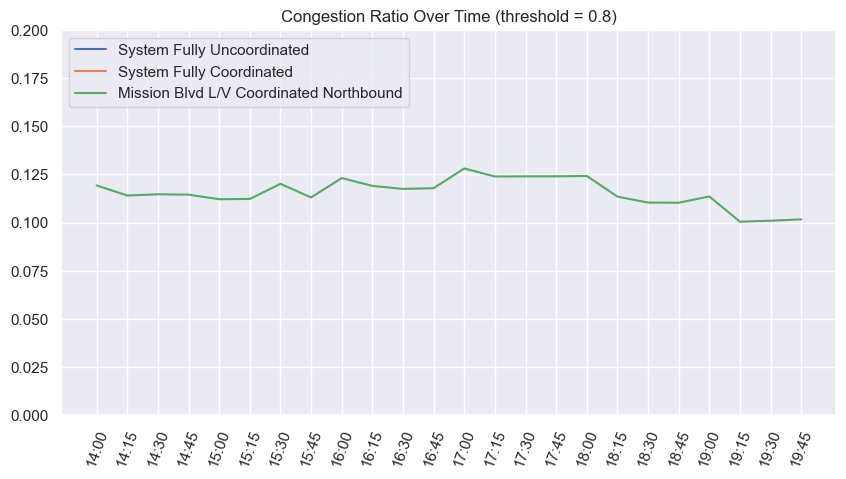

In [ ]:
def plot_congestion_ratio(database_names, image_descriptor, congestion_threshold=0.8, vmin=0, vmax=0.2):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    for database_name in database_names:
        desc, database = unpacked_databases_sect[database_name]['desc'], unpacked_databases_sect[database_name]['database']

        section_lengths = database[['eid', 'count', 'travel']]
        section_lengths['approx_length'] = section_lengths['travel'] / section_lengths['count']
        section_lengths = section_lengths.dropna().groupby('eid').mean().reset_index()

        data = database[database['count'] > 0][['eid', 'speed', 'sid', 'ent']]
        data = data[(data['sid'] == 0) & (data['ent'] != 0)].drop(columns='sid')
        data = data.merge(sections[['eid', 'speed']], how='left', on='eid').dropna()
        data = data.merge(section_lengths[['eid', 'approx_length']], how='left', on='eid')
        data['congestion_ratio'] = data['speed_x'] / data['speed_y']
        hour_data = []

        for i in range(1, 25):
            timestep_data = data[data['ent'] == i]
            congested_length = np.sum(timestep_data[timestep_data['congestion_ratio'] < congestion_threshold]['approx_length'])
            tot_length = np.sum(timestep_data['approx_length'])
            hour_data.append(congested_length / tot_length)

        ax.plot(TIME_INTERVALS_STRING, hour_data, label=desc)

    plt.title(f"Congestion Ratio Over Time (threshold = {congestion_threshold})")
    plt.xticks(rotation=70)
    plt.ylim(vmin, vmax)
    plt.legend(loc='upper left')
    save_fig(f'congestion-ratio-{image_descriptor}.png')
    plt.show()

plot_congestion_ratio(to_plot, COMPARISON_MODE)

Fundamental diagram
<a id='fundamental-diagram'></a>

In [52]:
from scipy.optimize import curve_fit

def quadratic_fit(X, Y):
    def helper(x, a, b):
        return a * x**2 + b * x
    params = curve_fit(helper, X, Y)
    return params[0]

for func_class in ['all'] + func_classes:
    if func_class == 'all':
        filename = 'all'
        title_suf = ''
    else:
        filename = func_class_desc[func_class].lower().replace(' ', '-')
        title_suf = f', {func_class_desc[func_class]}'
    dfs = {}
    max_density = 0
    for scenario in to_plot:
        df = unpacked_databases_sect[scenario]
        df = df[(df['ent']==0) & (~df['eid'].isin(bad_sections))]
        if func_class != 'all':
            df = df[df['eid'].isin(sections[sections['func_class']==func_class]['eid'])]
        dfs[scenario] = df
        max_density = max(max_density, np.max(df['density']))
        del df
    for scenario in to_plot:
        x = np.linspace(0, max_density, 1000)
        a, b = quadratic_fit(dfs[scenario]['density'], dfs[scenario]['flow'])
        color = plot_colors[scenario]['default']
        plt.scatter(dfs[scenario]['density'], dfs[scenario]['flow'], color=color, 
                    alpha=0.2, label=databases[scenario]['desc'])
        plt.plot(x, a * x**2 + b * x, '-', color=color)

    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel(section_metrics['density'].__str__())
    plt.ylabel(section_metrics['flow'].__str__())
    plt.title("Fundamental Diagram" + title_suf)
    plt.legend(loc='upper right')

    save_fig(f'fundamental-diagram/{filename}')
    plt.close()
    del dfs, filename, title_suf, x, a, b, scenario, color

Specific road
<a id='specific-road'></a>

In [41]:
# def preprocess_sections_multiple(group_by=['eid', 'ent']):
#     for k, v in unpacked_databases_sect.items():
#         desc, df = v['desc'], v['database']
#         df = preprocess_sections(df).groupby(group_by).mean().reset_index()
#         if 'geometry' not in df.columns:
#             df = df.merge(sections[['eid', 'geometry']], left_on='eid', right_on='eid').set_index('eid')
#             df = gpd.GeoDataFrame(df, geometry='geometry')
#             df = df.to_crs("EPSG:3857")
#         unpacked_databases_sect[k]['database'] = df

# preprocess_sections_multiple()
# unpacked_databases_sect

In [90]:
import re

directional_sections = {
    'Mission Boulevard': {
        'north': mission_northbound, 
        'south': mission_southbound,
        'both': mission_sections
    },
    'Osgood Road': {
        'north': osgood_northbound, 
        'south': osgood_southbound,
        'both': osgood_sections
    },
    'I-680': {
        'north': i680_northbound, 
        'south': i680_southbound,
        'both': i680_sections
    },
}

direction_to_str = {
    'north': 'Northbound',
    'south': 'Southbound',
    'both': 'Both Directions'
}

def get_road_name(road: str):
    road = road.lower()
    if 'mission' in road:
        road_name = 'Mission Boulevard'
    elif re.compile(r'warm springs|osgood|driscoll').search(road):
        road_name = 'Osgood Road'
    elif re.compile(r'i(-)?680').search(road):
        road_name = 'I-680'
    else:
        raise ValueError(f"'{road}' is illegal road argument")
    return road_name

In [370]:
def metric_by_road(verbose=True):
    if COMPARISON_MODE != 'lv':
        raise NotImplementedError()
    directions = ['north', 'south', 'both']
    roads = ['mission', 'osgood', 'i680']
    all_res = {
        metric: ResultsDf(['direction', 'road', 'scenario', 'mean', 'std']) 
        for metric in section_metrics
    }

    def road_plot(road: str, to_plot=to_plot, show_plots=False):
        """'Main' method that updates `res` and plots metrics over time."""
        road_name = get_road_name(road)
        if 'north' in road:
            direction = 'north'
        elif 'south' in road:
            direction = 'south'
        else:
            direction = 'both'
        section_subset = directional_sections[road_name][direction]

        road_data = deepcopy(unpacked_databases_sect)
        for scenario, data in road_data.items():
            df = data[(data['eid'].isin(section_subset['eid'])) & (~data['eid'].isin(bad_sections))]
            road_data[scenario] = {
                'net': df[df['ent']==0],
                'over_time': df[df['ent']!=0].groupby('ent').sum()
            }
        
        for metric in section_metrics.values():
            fig, ax = plt.subplots()
            for scenario in to_plot:
                ax.plot(
                    TIME_INTERVALS_STRING,
                    road_data[scenario]['over_time'][metric.name],
                    label=databases[scenario]['desc'], 
                    color=plot_colors[scenario]['default']
                )
                all_res[metric.name].add(
                    direction=direction_to_str[direction],
                    road=road_name,
                    scenario=databases[scenario]['desc'], 
                    mean=road_data[scenario]['net'][metric.name].mean(), 
                    std=road_data[scenario]['net'][metric.name].std()
                )

            road_full = f'{road_name} {direction_to_str[direction]}'
            plt.title(f'{metric.desc} over time on {road_full} ({metric.unit})')
            plt.xticks(rotation=70)
            plt.legend(fontsize=10, loc='upper left')

            save_fig(f'specific-road/{road}/{metric.name}-over-time')
            all_res[metric.name].save(f'metric-by-road/{metric.name}', file_type='all')

            if show_plots:
                plt.show()
            else:
                plt.close(fig)

    pbar = tqdm(directions, total=len(directions)*len(roads))
    for direction in pbar:
        for road in roads:
            pbar.set_postfix({'direction': direction, 'road': road})
            road_plot(f'{road}_{direction}')
            pbar.update(1)
    if verbose:
        for metric, res in all_res.items():
            print(section_metrics[metric].__str__() + '\n')
            print(res.__str__() + '\n')
    return all_res
    
all_res = metric_by_road(verbose=False)

 33%|███▎      | 3/9 [00:50<01:41, 16.86s/it, direction=both, road=i680]    


In [374]:
pbar = tqdm(section_metrics.values())

def pairplot_specific_road(metric: Metric):
    global pbar
    desc = {f'{metric.name}_{scenario}': databases[scenario]['abbrev_desc'] for scenario in to_plot}
    metric_df = multi_frame[['eid'] + [f'{metric.name}_{scenario}' for scenario in to_plot]]

    for direction in ['north', 'south', 'both']:
        for road in ['mission', 'osgood', 'i680']:
            pbar.set_postfix({'direction': direction, 'road': road})
            road_full = get_road_name(road)
            df = deepcopy(metric_df)
            df = df[(~df['eid'].isin(bad_sections)) & (df['eid'].isin(directional_sections[road_full][direction]['eid']))]
            df.rename(columns=desc, inplace=True)
            df.drop(columns=['eid'], inplace=True)
            min_val = df.min().min()
            max_val = df.max().max()
            if min_val < max_val * 0.25:
                min_val = 0
            g = sns.pairplot(df, kind='reg', diag_kind='hist', diag_kws={'bins': 10})
            g.map_upper(lambda *args, **kwargs: plt.gca().set_visible(False))
            for i in range(len(to_plot)):
                for j in range(i + 1):
                    g.axes[i, j].set_xlim(min_val, max_val)
                    g.axes[i, j].set_ylim(min_val, max_val)
            g.fig.suptitle(f'{metric.desc}, {road_full} {direction_to_str[direction]} ({metric.unit})', size=18, y=1.02)
            save_fig(f'specific-road-pairplot/{metric.name}/{road}-{direction}')
            plt.close()

for metric in pbar:
    pairplot_specific_road(metric)

100%|██████████| 7/7 [02:50<00:00, 24.42s/it, direction=both, road=i680]    


Diverted Traffic Proxies

Section with EID 3422 tracks vehicles switching from I-680 northbound to Mission
Blvd northbound. EID 2752 tracks vehicles on I-680 northbound prior to the exit.

The flow difference across section EID 30550 minus 35200 tracks the difference
between the number of vehicles turning from Osgood Road onto Mission Blvd and
the number of vehicles turning from Mission Blvd northbound onto Osgood Road.

In [87]:
def plot_few_section_comparison(few_sections: dict, metric: Metric, mode: str, filename: str):
    """
    Plots metric along a set of roads over time. If mode = 'rel', the first element
    of few_sections is used as comparison.
    """
    assert mode in ['abs', 'rel']
    fig, axs = plt.subplots(1, len(to_plot), figsize=(6*len(to_plot), 3.5))
    for i in range(len(to_plot)):
        scenario = to_plot[i]
        ax = axs[i]
        if mode == 'rel':
            comparison_eid, comparison_desc = next(iter(few_sections.items()))
            comparison_df = unpacked_databases_sect[scenario]
            comparison_df = comparison_df[(comparison_df['eid']==comparison_eid) & (comparison_df['ent']!=0)]
        for eid, desc in few_sections.items():
            df = unpacked_databases_sect[scenario]
            df = df[(df['eid']==eid) & (df['ent']!=0)]
            if mode == 'abs':
                plot_series = df[metric.name]
            else:
                plot_series = df[metric.name].reset_index(drop=True) / comparison_df[metric.name].reset_index(drop=True)
            ax.plot(
                TIME_INTERVALS_STRING,
                plot_series,
                label=desc
            )
        ax.tick_params('x', labelrotation=70)
        ax.set_title(databases[scenario]['desc'])
        if mode == 'abs':
            ax.set_ylim((0, 6000))
        else:
            ax.set_ylim((0, 1.5))
        ax.legend()
    if mode == 'abs':
        fig.suptitle(metric.__str__())
    else:
        fig.suptitle(f'{metric.desc} / {{ {comparison_desc} }} Ratio')
    save_fig(f'few_sections/{filename}-{mode}')
    plt.close()

few_sections_list = {
    'mission-i680': {
        '2752': 'Before Exit',
        '2753': 'After Exit',
        '278': 'Mission Blvd Exit',
        '3422': 'Mission Blvd Exit NB',
        '2750': 'Mission Blvd Exit SB'
    },
    'mission-osgood': {
        '35200': 'Mission Blvd Before Osgood Road',
        '30550': 'Mission Blvd Past Osgood Road',
    }
}

for filename, few_sections in few_sections_list.items():
    for mode in ['abs', 'rel']:
        plot_few_section_comparison(
            few_sections,
            section_metrics['flow'],
            mode,
            filename
        )

del few_sections_list

In [53]:
bruh = unpacked_databases_sect['fully_coordinated_averaged']
bruh[(bruh['eid'].isin(['3422', '2752', '2753', '4907'])) & (bruh['ent']!=0)]

ent   eid         flow       ttime       dtime       speed  \
5738      1  2752  4201.333333    6.137642    0.285033  101.081139   
5739      1  2753  3566.666667   17.913771    0.728203  101.728242   
7449      1  3422    90.666667   16.222962    0.020779   80.452465   
8262      1  4907   454.666667    8.282186    0.616915   98.462027   
10402     2  2752  4422.666667    6.160386    0.322959  100.788635   
...     ...   ...          ...         ...         ...         ...   
110870   23  4907   388.000000   56.977965   49.970423   47.185615   
113010   24  2752  3276.000000   26.327990   20.482586   73.901307   
113011   24  2753  2974.666667  119.066314  101.908144   70.881374   
114721   24  3422     0.000000    8.772283    3.103433   45.608712   
115534   24  4907   344.000000   63.896267   56.903844   47.401876   

           density      travel        count  
5738     10.481205  180.084781  1050.333333  
5739     11.889098  449.119952   891.666667  
7449      1.143726    8.163703    22.666667  
8262      4.680527   25.524640   113.666667  
10402    11.044549  189.571723  1105.666667  
...            ...         ...          ...  
110870   50.412074   21.782024    97.000000  
113010   34.450147  140.426036   819.000000  
113011   53.757523  374.530839   743.666667  
114721  177.479894    0.000000     0.000000  
115534   53.266472   19.311923    86.000000  

[96 rows x 9 columns]

Scenario ratios
<a id='scenario-ratios'></a>

In [376]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def section_ratio(scenarios, compare_to, verbose=True, write=True, plot=True, multi_frame=multi_frame):
    """
    All things section-ratio related.
    Generates tables summarizing mean data, runs statistical tests, generates section plots.
    """
    assert compare_to not in scenarios
    all_scenarios = [compare_to] + scenarios
    if COMPARISON_MODE == 'lv':
        mean_std_res = ResultsDf(['metric', 'scenario', 'mean', 'std'])
        stat_test_res = ResultsDf(['metric', 'scenario_1', 'scenario_2', 't_statistic', 'p_value'])
    else:
        raise NotImplementedError()
    multi_frame = multi_frame[~multi_frame['eid'].isin(bad_sections)]

    log_ratio_df = multi_frame[['eid']]
    for metric in section_metrics.values():
        for scenario in all_scenarios:
            data = multi_frame[f'{metric.name}_{scenario}']
            mean_std_res.add(
                metric=metric.__str__(),
                scenario=databases[scenario]['desc'],
                mean=data.mean(),
                std=data.std()
            )
            log_ratio_df[f'{metric.name}_{scenario}'] = np.log2(multi_frame[f'{metric.name}_{scenario}'] + eps) \
                                                        - np.log2(multi_frame[f'{metric.name}_{compare_to}'] + eps)
    log_ratio_df = gpd.GeoDataFrame(
        log_ratio_df.merge(sections[['eid', 'geometry']], on='eid'),
        geometry='geometry'
    )

    for metric in section_metrics.values():
        for i in range(len(all_scenarios)):
            for j in range(i+1, len(all_scenarios)):
                scenario_1 = all_scenarios[i]
                scenario_2 = all_scenarios[j]
                stat, pval = stats.ttest_rel(
                    multi_frame[f'{metric.name}_{scenario_1}'], 
                    multi_frame[f'{metric.name}_{scenario_2}']
                )
                stat_test_res.add(
                    metric=metric.__str__(),
                    scenario_1=databases[scenario_1]['desc'],
                    scenario_2=databases[scenario_2]['desc'],
                    t_statistic=stat,
                    p_value=pval
                )

    if write:
        mean_std_res.save('section-ratio/mean-std', file_type='all')
        stat_test_res.save('section-ratio/stat-test', file_type='all', index_cols=['metric'])

    if plot:
        pbar = tqdm(section_metrics.values())
        for metric in pbar:
            fig, axs = plt.subplots(1, len(scenarios) + 1, figsize=(8*len(scenarios), 10), 
                                    gridspec_kw={'width_ratios': [50]*len(scenarios)+[2]})
            fig.suptitle(
                f"{metric.desc} / {{ {databases[compare_to]['desc']} }} Log2 Ratio", 
                size=25
            )
            vmin, vmax = -2, 2
            norm = Normalize(vmin=vmin, vmax=vmax)
            cb = ColorbarBase(axs[-1], cmap='coolwarm_r', norm=norm, orientation='vertical')
            axs[-1].tick_params(labelsize=16)

            for i in range(len(scenarios)):
                scenario = scenarios[i]
                ax = axs[i]
                pbar.set_postfix({'metric': metric.name, 'scenario': scenario})
                # affected_nodes = nodes[nodes['eid'].isin(
                #     np.array(databases[scenario]['uncoordinated_nodes'], str))]
                sections.plot(ax=ax, color='0.8', zorder=-1)
                log_ratio_df.plot(ax=ax, column=f'{metric.name}_{scenario}', 
                    cmap='coolwarm_r', lw=1, vmin=vmin, vmax=vmax, zorder=0)
                # nodes.plot(ax=ax, color='0.3', lw=2, zorder=1)
                # if affected_nodes.shape[0]:
                #     affected_nodes.plot(ax=ax, color='black', lw=2, zorder=2, marker='s')
                ax.set_title(databases[scenario]['desc'], size=22)
                ax.axis('off')

            plt.subplots_adjust(wspace=0)
            save_fig(f'section-ratio/{metric.name}')
            plt.close()

    return mean_std_res, stat_test_res


In [377]:
if COMPARISON_MODE == 'lv':
    mean_std_res, stat_test_res = section_ratio(
        ['nooffset_mission_nb_averaged', 'lv_mission_nb_averaged'],
        'fully_coordinated_averaged',
        write=True,
        plot=True
    )
else:
    raise NotImplementedError()
print(mean_std_res.__str__() + '\n')
print(stat_test_res.__str__())

100%|██████████| 7/7 [00:24<00:00,  3.47s/it, metric=count, scenario=lv_mission_nb_averaged]        

                             metric                                 scenario  \
0                 Mean Flow (veh/h)                 System Fully Coordinated   
1                 Mean Flow (veh/h)      Mission Blvd Zero Offset Northbound   
2                 Mean Flow (veh/h)  Mission Blvd L/V Coordinated Northbound   
3              Mean Travel Time (s)                 System Fully Coordinated   
4              Mean Travel Time (s)      Mission Blvd Zero Offset Northbound   
5              Mean Travel Time (s)  Mission Blvd L/V Coordinated Northbound   
6               Mean Delay Time (s)                 System Fully Coordinated   
7               Mean Delay Time (s)      Mission Blvd Zero Offset Northbound   
8               Mean Delay Time (s)  Mission Blvd L/V Coordinated Northbound   
9                 Mean Speed (km/h)                 System Fully Coordinated   
10                Mean Speed (km/h)      Mission Blvd Zero Offset Northbound   
11                Mean Speed (km/h)  Mis

Buffer zones

The below plots indicate metrics over time within a certain buffer distance from
an arterial road (Mission Blvd, Osgood Road).

In [ ]:
from copy import deepcopy

def buffer_zone_plots(road, include_inner=True, show_plots=True, exclude_i680=True):
    if road == 'mission':
        road_full = 'Mission Boulevard'
    elif road in ('warm springs', 'osgood', 'driscoll'):
        road_full = 'Osgood Road'
    else:
        raise ValueError('Illegal road')

    scenarios = ['fully_uncoordinated_averaged', 
                 f'{road}_partially_uncoordinated_averaged',
                 f'{road}_fully_uncoordinated',
                 'fully_coordinated_averaged']
    res = {k: {d: {} for d in buffer_distances} for k in section_metrics}

    road_buffer = mission_buffer if road == 'mission' else osgood_buffer
    if exclude_i680:
        for d in buffer_distances:
            df = road_buffer[d]['sections']
            road_buffer[d]['sections'] = df[~(df['eid'].isin(i680_sections['eid']))]

    for i in range(len(buffer_distances)):
        d = buffer_distances[i]
        unpacked_databases_buffer = deepcopy(unpacked_databases_sect)
        for k in unpacked_databases_buffer:
            database = unpacked_databases_buffer[k]['database']
            if include_inner or i == 0:
                unpacked_databases_buffer[k]['database'] = database[
                    database.index.isin(road_buffer[d]['sections']['eid'])]
            else:
                unpacked_databases_buffer[k]['database'] = database[
                    (database.index.isin(road_buffer[buffer_distances[i]]['sections']['eid']))
                    & ~(database.index.isin(road_buffer[buffer_distances[i-1]]['sections']['eid']))]
        for k in section_metrics:
            for scenario in scenarios:
                data = unpacked_databases_buffer[scenario]['database'][k]
                res[k][d][scenario] = {'mean': data.mean(), 'stdev': data.std()}
    
    for k in section_metrics:
        metric = section_metrics[k]
        fig, ax = plt.subplots()
        for scenario in scenarios:
            data = [res[k][d][scenario]['mean'] for d in buffer_distances]
            ax.plot(buffer_distances, 
                    data, 
                    label=databases[scenario]['desc'], 
                    color=plot_colors[scenario]['default'])
            ax.scatter(buffer_distances, 
                       data,
                       color=plot_colors[scenario]['default'])

        title = f'{metric.desc} vs Distance from {road_full}'
        if include_inner:
            filename = f'{road}/include-inner/{k}.png'
            title += ' (Including I-680)'
        else:
            filename = f'{road}/exclude-inner/{k}.png'
            title += ' (Excluding I-680)'
            temp = [0] + buffer_distances
            xticks = [f'[{temp[i]}, {temp[i+1]}]' for i in range(len(buffer_distances))]
            ax.set_xticks(buffer_distances, xticks, rotation=90)
        ax.set_title(title)
        ax.set_xlabel('Distance (m)')
        ax.set_ylabel(f'{metric.desc} ({metric.unit})')
        ax.legend(loc='upper right')
        save_fig(f"buffer/{filename}")
        if show_plots:
            plt.show()
        else:
            plt.close()

for include_inner in [True, False]:
    buffer_zone_plots('mission', include_inner=include_inner, show_plots=False)
    buffer_zone_plots('osgood', include_inner=include_inner, show_plots=False)

Animation multiple comparison

In [36]:
unpacked_databases_sect = unpack_databases('MISECT')

def preprocess_sections_animation(df):
    df = df[df['sid']==0]
    df = df.filter(items=section_df_cols).dropna(axis=0)
    for k, v in null_values.items():
        df = df[df[k]!=v]
    return df

for k in unpacked_databases_sect:
    unpacked_databases_sect[k]['database'] = preprocess_sections_animation(unpacked_databases_sect[k]['database'])

100%|██████████| 9/9 [00:01<00:00,  5.24it/s, scenario=lv_mission_nb]                


KeyError: 'sid'

In [ ]:
from matplotlib import animation
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from functools import reduce


def multiple_section_animation(metric, to_plot=to_plot, filename=None):
    """
    Plots ratios of to_plot[:-1] to to_plot[-1]
    """

    metric = section_metrics[metric]
    print(metric.desc)
    fig, axs = plt.subplots(1, len(to_plot), figsize=(20, 10), gridspec_kw={
                            'width_ratios': [50]*(len(to_plot)-1)+[2]})
    norm = Normalize(vmin=0, vmax=2)
    cb = ColorbarBase(axs[-1], cmap='coolwarm_r',
                      norm=norm, orientation='vertical')
    axs[-1].tick_params(labelsize=16)
    compare_name = databases[to_plot[-1]]['desc']

    descs = [unpacked_databases_sect[k]['desc'] for k in to_plot[:-1]]
    compare_cols = ['eid', 'ent']
    data = [unpacked_databases_sect[k]['database']
            [compare_cols + [metric.name]] for k in to_plot]
    data = reduce(lambda left, right: pd.merge(
        left, right, on=compare_cols), data)
    data.set_axis(compare_cols + to_plot, axis=1, inplace=True)
    for k in to_plot:
        data[k + '_ratio'] = data[k] / data[to_plot[-1]]
    data.dropna(inplace=True)
    data = gpd.GeoDataFrame(data.merge(
        sections[['eid', 'geometry']], on='eid'), geometry='geometry')

    def animate(timestep):
        print(f'Processing {metric.name}, frame {timestep}')
        fig.suptitle(
            f'{metric.desc} / {compare_name} Ratio Over Time: {TIME_INTERVALS_STRING[timestep - 1]}', size=26)
        ims = []

        for i in range(len(to_plot)-1):
            ax = axs[i]
            desc = descs[i]
            affected_nodes = node_geo_city[node_geo_city['id'].isin(
                databases[to_plot[i]]['uncoordinated_nodes'])]
            sections.plot(ax=ax, color='0.8', zorder=-1)
            data[data['ent'] == timestep].plot(
                ax=ax, column=(to_plot[i] + '_ratio'), cmap='coolwarm_r', 
                lw=2, vmin=0, vmax=2, zorder=0)
            if affected_nodes.shape[0]:
                affected_nodes.plot(ax=ax, color='black',lw=2, zorder=2, marker='s')
            ims.append(node_geo_city.plot(ax=ax, color='0.3', lw=2, zorder=1))
            ax.set_title(desc, size=22)
            ax.axis('off')

        return ims

    anim = animation.FuncAnimation(
        fig, animate, interval=1000, repeat_delay=3000, frames=range(1, 25))
    writergif = animation.PillowWriter(fps=0.6)
    if filename is None:
        filename = f'{metric.name}_multiple_comparison.gif'
    anim.save(os.path.join(image_path, filename), writer=writergif)


Travel Distance by Section


C:\Users\prest\AppData\Local\Temp\ipykernel_8932\3497754242.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'travel_x'} in the result is deprecated and will raise a MergeError in a future version.
  data = reduce(lambda left, right: pd.merge(


Processing travel, frame 1
Processing travel, frame 1
Processing travel, frame 2
Processing travel, frame 3
Processing travel, frame 4
Processing travel, frame 5
Processing travel, frame 6
Processing travel, frame 7
Processing travel, frame 8
Processing travel, frame 9
Processing travel, frame 10
Processing travel, frame 11
Processing travel, frame 12
Processing travel, frame 13
Processing travel, frame 14
Processing travel, frame 15
Processing travel, frame 16
Processing travel, frame 17
Processing travel, frame 18
Processing travel, frame 19
Processing travel, frame 20
Processing travel, frame 21
Processing travel, frame 22
Processing travel, frame 23
Processing travel, frame 24
Travel Distance by Section


C:\Users\prest\AppData\Local\Temp\ipykernel_8932\3497754242.py:26: FutureWarning: Passing 'suffixes' which cause duplicate columns {'travel_x'} in the result is deprecated and will raise a MergeError in a future version.
  data = reduce(lambda left, right: pd.merge(


Processing travel, frame 1
Processing travel, frame 1
Processing travel, frame 2
Processing travel, frame 3
Processing travel, frame 4
Processing travel, frame 5
Processing travel, frame 6
Processing travel, frame 7
Processing travel, frame 8
Processing travel, frame 9
Processing travel, frame 10
Processing travel, frame 11
Processing travel, frame 12
Processing travel, frame 13
Processing travel, frame 14
Processing travel, frame 15
Processing travel, frame 16
Processing travel, frame 17
Processing travel, frame 18
Processing travel, frame 19
Processing travel, frame 20
Processing travel, frame 21
Processing travel, frame 22
Processing travel, frame 23
Processing travel, frame 24


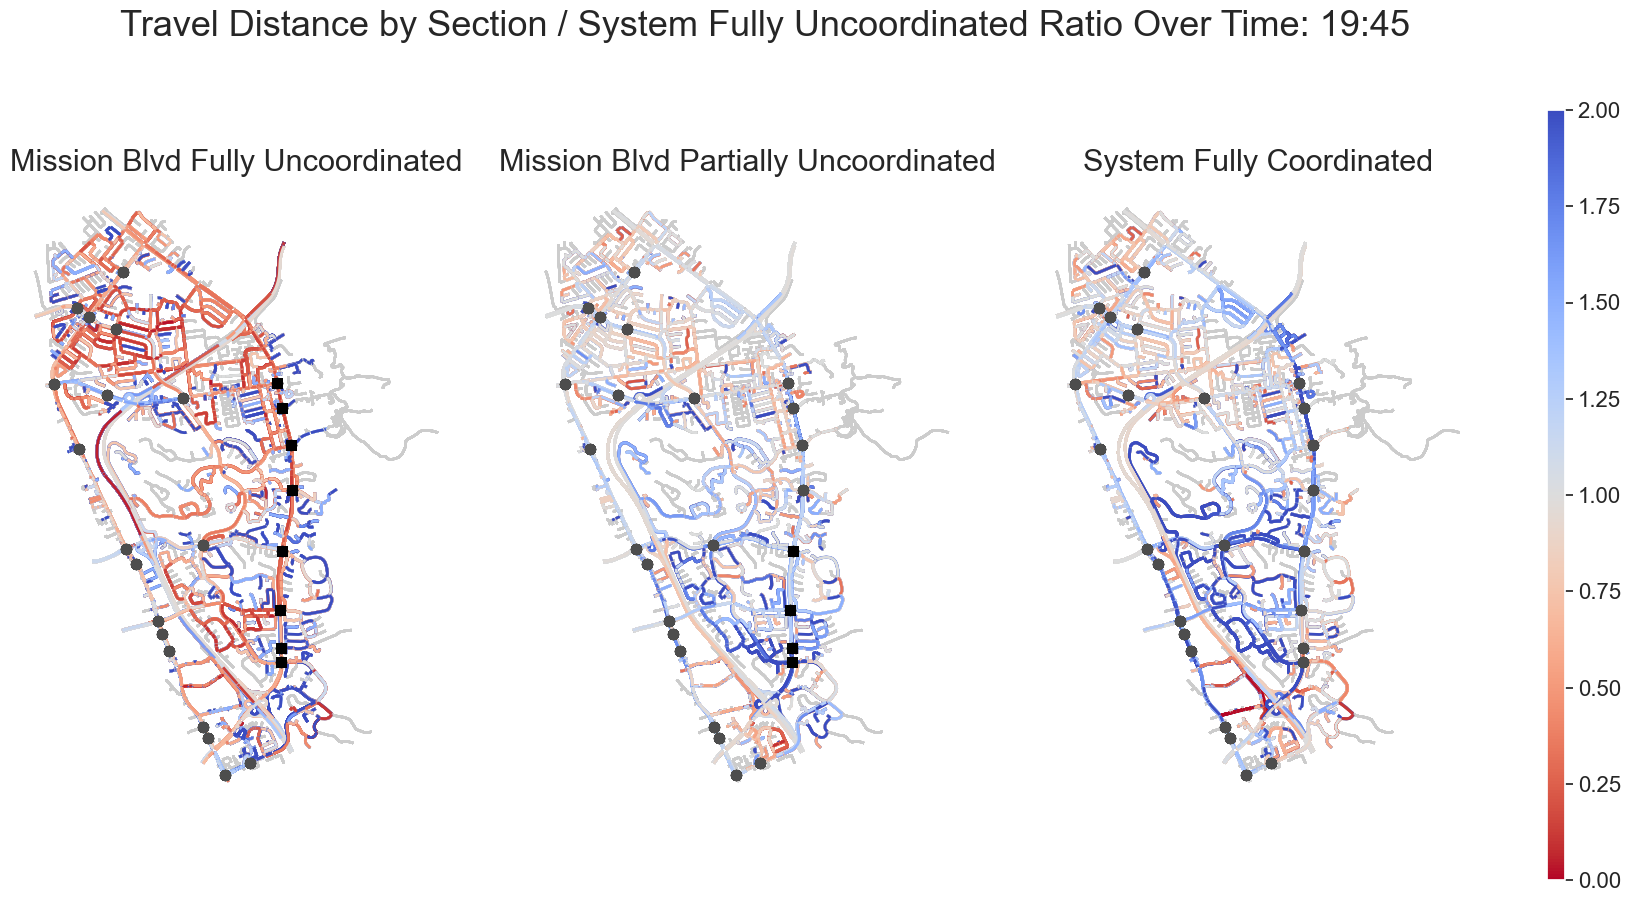

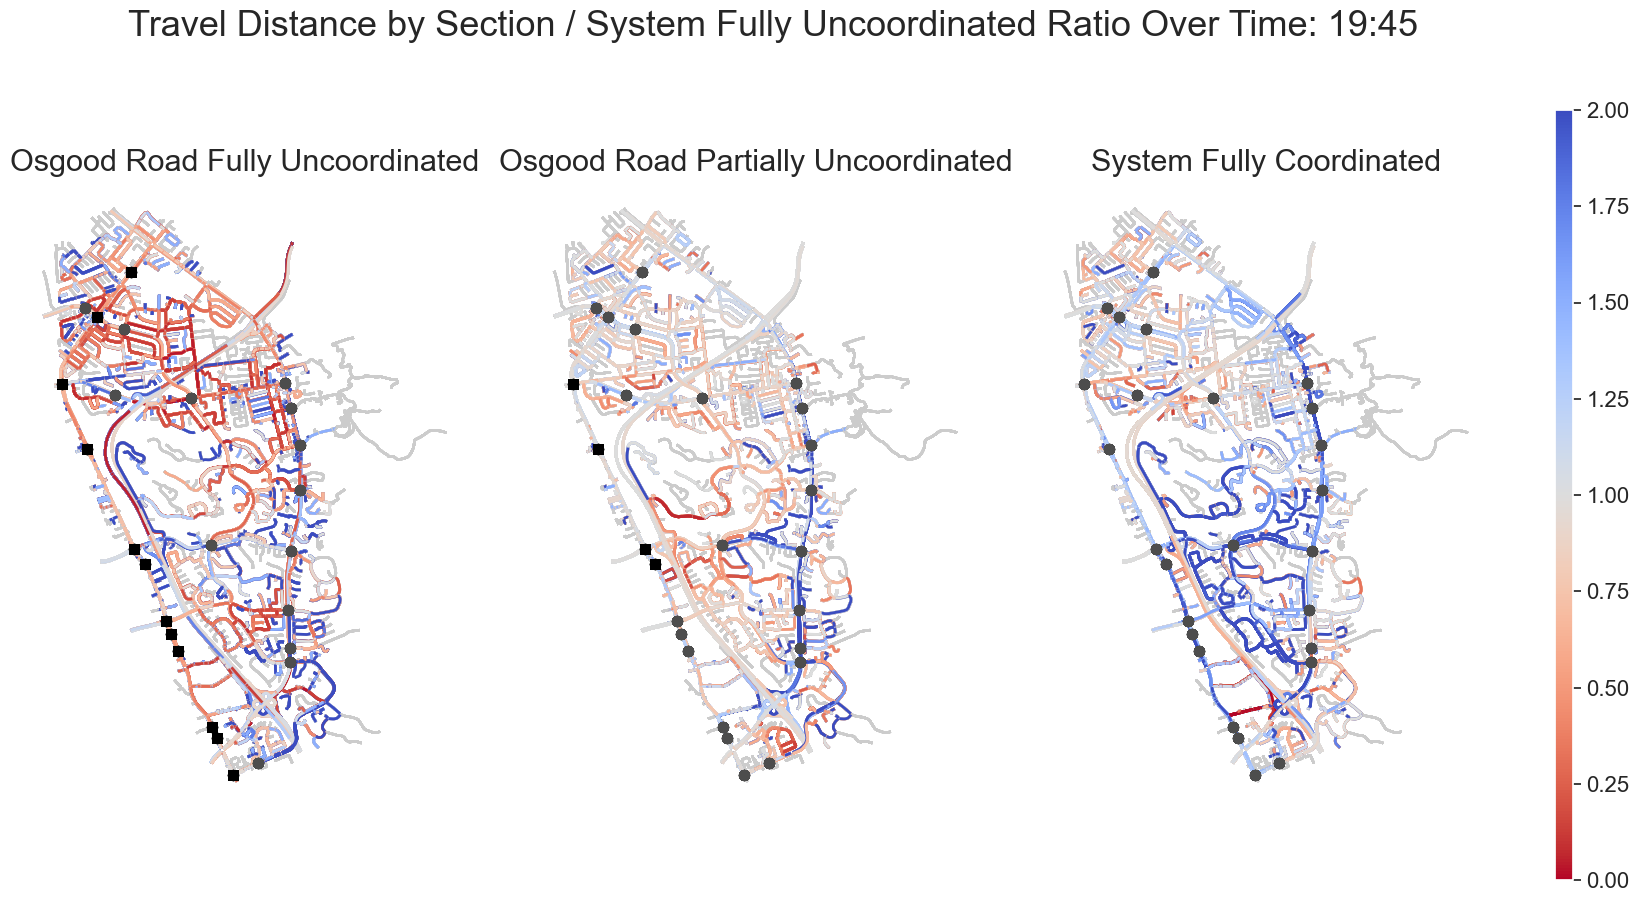

In [ ]:
for k in ['travel']:
    for road in ['mission', 'osgood']:
        multiple_section_animation(
            metric=k, 
            to_plot=[
                f'{road}_fully_uncoordinated',
                f'{road}_partially_uncoordinated_averaged',
                'fully_coordinated_averaged',
                'fully_uncoordinated_averaged'
            ],
            filename=f'{k}_{road}_multiple_comparison.gif'
        )

#### Self comparison

Let $f(s, t)$ denote the value of metric $f$ at section $s \in S$ during time interval $t \in T$. The color at $(s_0, t_0)$ is determined by:

$$\frac{f(s_0, t_0)}{\left(\frac 1{|S|} \sum_s f(s, t_0)\right)^\gamma \cdot \left(\frac 1{|T|} \sum_t f(s_0, t)\right)^{1-\gamma}}$$

where $\gamma = 0.2$ is a parameter determining the relative effect of the choice of $s$ and $t$ (we have selected a small $\gamma$ because the choice of $s$ has a much more significant role than $t$, but we still don't have a good way to select a "good" $\gamma$ for the data).

In [ ]:
from matplotlib import animation
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def compare_to_self_section_animation(metric, which, gamma=0.2):
    """
    Plots ratio of normalized databases in `which` over time
    """

    if metric in ['flow', 'speed']:
        cmap = 'coolwarm_r'
    else:
        cmap = 'coolwarm'
    metric = section_metrics[metric]
    if metric.name == 'density':
        desc = 'Density by Lane'
    else:
        desc = ' '.join(metric.desc.split(' ')[1:])
    print(desc)
    if isinstance(which, str):
        which = [which]
    fig, axs = plt.subplots(1, len(which) + 1, figsize=(5*(len(which)+1), 10), gridspec_kw={'width_ratios': [50]*len(which)+[2]})
    norm = Normalize(vmin=0, vmax=2)
    cb = ColorbarBase(axs[-1], cmap=cmap, norm=norm, orientation='vertical')
    axs[-1].tick_params(labelsize=16)

    plot_databases = {}
    for name in which:
        scenario_desc = unpacked_databases_sect[name]['desc']
        data = unpacked_databases_sect[name]['database']
        data = data[data['ent']!=0]
        data_by_eid = data.groupby('eid').mean().reset_index()
        data_by_ent = data.groupby('ent').mean().reset_index()
        data_by_eid['key'] = 'key'
        data_by_ent['key'] = 'key'
        eid_ent_prod = data_by_eid.merge(data_by_ent, how='outer', on='key', suffixes=['_eid', '_ent']).dropna()
        eid_ent_prod.drop(columns=['ent_eid', 'key'], inplace=True)
        eid_ent_prod.rename({'ent_ent': 'ent'}, axis=1, inplace=True)
        data = data.merge(eid_ent_prod, on=['eid', 'ent'])
        data['ratio'] = data[metric.name] / (data[metric.name+'_eid']**(1-gamma) * data[metric.name+'_ent']**gamma)
        data = gpd.GeoDataFrame(data.merge(sections[['eid', 'geometry']], on='eid'), geometry='geometry')
        plot_databases[name] = {'desc': scenario_desc, 'data': data}

    def animate(timestep):
        print(f'Processing {metric.name}, frame {timestep}')
        frame_title = f'Normalized (gamma={gamma}) {desc} Over Time: {TIME_INTERVALS_STRING[timestep - 1]}'
        if len(which) == 1:
            frame_title = f"{plot_databases[which[0]]['desc']}, {frame_title}"
        fig.suptitle(frame_title, size=22)
        ims = []

        for i in range(len(which)):
            ax, scenario_desc, data = axs[i], plot_databases[which[i]]['desc'], plot_databases[which[i]]['data']
            affected_nodes = node_geo_city[node_geo_city['id'].isin(databases['fully_coordinated_averaged']['uncoordinated_nodes'])]
            sections.plot(ax=ax, color='0.8', zorder=-1)
            data[data['ent'] == timestep].plot(
                ax=ax, column='ratio', cmap=cmap, lw=2, vmin=0, vmax=2, zorder=0)
            if affected_nodes.shape[0]:
                affected_nodes.plot(ax=ax, color='black', lw=2, zorder=2, marker='s')
            ims.append(node_geo_city.plot(ax=ax, color='0.3', lw=2, zorder=1))
            if len(which) > 1:
                ax.set_title(scenario_desc, size=22)
            ax.axis('off')

        return ims

    anim = animation.FuncAnimation(fig, animate, interval=1000, repeat_delay=3000, frames=range(1, 25))
    writergif = animation.PillowWriter(fps=0.6)
    self_animation_path = f"{image_path}/{'_'.join(which)}"
    if not os.path.exists(self_animation_path):
        os.makedirs(self_animation_path)
    anim.save(f"{self_animation_path}/{metric.name}_self-comparison.gif", writer=writergif)

In [ ]:
for k in section_metrics:
    compare_to_self_section_animation(k, 'fully_coordinated_averaged')

In [ ]:
for k in section_comparisons:
    compare_to_self_section_animation(k, 'fully_uncoordinated_averaged')

In [ ]:
for k in section_metrics:
    compare_to_self_section_animation(k, 
    ['fully_uncoordinated_averaged', 'mission_partially_uncoordinated_averaged', 
     'osgood_partially_uncoordinated_averaged', 'fully_coordinated_averaged'])

<a id='animations'></a>
## [DEPRECATED] Animations

Note: this section takes forever to run

In [ ]:
dfs_section = {'uncoordinated': uncoordinated_section_df, 'coordinated': coordinated_section_df}

for k, df in dfs_section.items():
    dfs_section[k] = preprocess_sections_animation(df)

dfs_section['uncoordinated']

eid  ent    flow      ttime      dtime       speed    density  count
0         242    1  1324.0  24.522981  18.286577   27.208512  50.112778  331.0
1         243    1  1284.0   2.654111   0.038367  105.297945   3.079980  321.0
2         244    1  1312.0   1.820326   0.071486  105.324678   3.220035  328.0
4         247    1     8.0   9.313807   0.851008   45.257797   0.176977    2.0
7         250    1   284.0   7.856093   0.162104   73.459061   3.892242   71.0
...       ...  ...     ...        ...        ...         ...        ...    ...
329342  36523   24     4.0   7.377708   0.000000   37.877473   0.105604    1.0
329343  36524   24     4.0   5.379831   0.613276   40.013600   0.099966    1.0
329347   3425   24   488.0   4.621014   1.885600   62.718905   3.903328  122.0
329348  56150   24   768.0   1.075209   0.309226   59.136938   6.840158  192.0
329349   7154   24  1808.0  11.316553   0.118979  105.594055   2.859305  452.0

[64636 rows x 8 columns]

In [ ]:
dfs_section['uncoordinated'][(dfs_section['uncoordinated']['eid']=="242") & (dfs_section['uncoordinated']['ent']==1)]

eid  ent    flow      ttime      dtime      speed    density  count
0  242    1  1324.0  24.522981  18.286577  27.208512  50.112778  331.0

In [ ]:
section_df = dfs_section['uncoordinated'].merge(dfs_section['coordinated'], on=['eid', 'ent'], how='left', suffixes=['_uncoordinated', '_coordinated'])

for k in section_metrics:
    section_df[k+'_ratio'] = section_df[k+'_coordinated'] / section_df[k+'_uncoordinated']

section_df = section_df.dropna()
section_df

eid  ent  flow_uncoordinated  ttime_uncoordinated  \
0        242    1              1324.0            24.522981   
1        243    1              1284.0             2.654111   
2        243    1              1284.0             2.654111   
3        243    1              1284.0             2.654111   
4        244    1              1312.0             1.820326   
...      ...  ...                 ...                  ...   
65854   3425   24               488.0             4.621014   
65855  56150   24               768.0             1.075209   
65856  56150   24               768.0             1.075209   
65857   7154   24              1808.0            11.316553   
65858   7154   24              1808.0            11.316553   

       dtime_uncoordinated  speed_uncoordinated  density_uncoordinated  \
0                18.286577            27.208512              50.112778   
1                 0.038367           105.297945               3.079980   
2                 0.038367           105.297945               3.079980   
3                 0.038367           105.297945               3.079980   
4                 0.071486           105.324678               3.220035   
...                    ...                  ...                    ...   
65854             1.885600            62.718905               3.903328   
65855             0.309226            59.136938               6.840158   
65856             0.309226            59.136938               6.840158   
65857             0.118979           105.594055               2.859305   
65858             0.118979           105.594055               2.859305   

       count_uncoordinated  flow_coordinated  ttime_coordinated  \
0                    331.0            1356.0          24.155884   
1                    321.0            1256.0           2.659904   
2                    321.0            1272.0           2.785957   
3                    321.0            1268.0           0.562661   
4                    328.0            1280.0           1.823788   
...                    ...               ...                ...   
65854                122.0             636.0           4.733680   
65855                192.0             828.0          26.831333   
65856                192.0             852.0           1.090531   
65857                452.0            1324.0          12.284400   
65858                452.0            1324.0          11.370631   

       dtime_coordinated  speed_coordinated  density_coordinated  \
0              17.927443          27.772434            50.106215   
1               0.047324         105.051102             3.019156   
2               0.050646         105.056933             3.052417   
3               0.010235         105.032080             3.044200   
4               0.077166         105.117350             3.145367   
...                  ...                ...                  ...   
65854           1.994731          60.720573             5.190379   
65855          22.877550          29.268433            18.928575   
65856           0.325831          58.184362             7.695855   
65857           0.264690         104.312196             2.541104   
65858           0.151623         105.180507             2.621374   

       count_coordinated  flow_ratio  ttime_ratio  dtime_ratio  speed_ratio  \
0                  339.0    1.024169     0.985030     0.980361     1.020726   
1                  314.0    0.978193     1.002183     1.233434     0.997656   
2                  318.0    0.990654     1.049676     1.320019     0.997711   
3                  317.0    0.987539     0.211996     0.266757     0.997475   
4                  320.0    0.975610     1.001902     1.079461     0.998032   
...                  ...         ...          ...          ...          ...   
65854              159.0    1.303279     1.024381     1.057876     0.968138   
65855              207.0    1.078125    24.954532    73.983323     0.494926   
65856              213.0    1.109375     1

In [ ]:
section_df = section_df.merge(sections[['eid', 'geometry']], left_on='eid', right_on='eid').set_index('eid')
section_df = gpd.GeoDataFrame(section_df, geometry='geometry')
frame = section_df.to_crs("EPSG:3857")
frame

ent  flow_uncoordinated  ttime_uncoordinated  dtime_uncoordinated  \
eid                                                                        
242      1              1324.0            24.522981            18.286577   
242      2               764.0            20.645561            14.473680   
242      3               796.0            21.497040            15.264269   
242      4               872.0            22.878881            16.680540   
242      5               852.0            21.656951            15.442929   
...    ...                 ...                  ...                  ...   
29381   22                 4.0             8.508370             2.005016   
1606    23                 8.0             4.487063             0.768128   
1606    24                16.0             4.472663             0.665884   
697     24                 8.0            27.728856             1.698323   
29076   24                 4.0            13.603302             0.767804   

       speed_uncoordinated  density_uncoordinated  count_uncoordinated  \
eid                                                                      
242              27.208512              50.112778                331.0   
242              32.360839              23.719355                191.0   
242              31.139108              26.668741                199.0   
242              29.302826              30.219538                218.0   
242              30.876784              27.871238                213.0   
...                    ...                    ...                  ...   
29381            34.752084               0.115101                  1.0   
1606             35.056167               0.228347                  2.0   
1606             35.273029               0.455229                  4.0   
697              36.275013               0.220964                  2.0   
29076            39.103145               0.102294                  1.0   

       flow_coordinated  ttime_coordinated  dtime_coordinated  \
eid                                                             
242              1356.0          24.155884          17.927443   
242               820.0          21.292549          15.107659   
242               748.0          20.712661          14.576582   
242               780.0          20.496334          14.287262   
242               892.0          22.238980          16.060410   
...                 ...                ...                ...   
29381               4.0           8.347064           1.266354   
1606               12.0           4.288029           0.676140   
1606                4.0           4.084243           0.563123   
697                 4.0          25.148781           1.874166   
29076               4.0          12.671143           0.643045   

       speed_coordinated  density_coordinated  count_coordinated  flow_ratio  \
eid                                                                            
242            27.772434            50.106215              339.0    1.024169   
242            31.413536            26.367021              205.0    1.073298   
242            32.253563            24.012597              187.0    0.939698   
242            32.678167            24.019167              195.0    0.894495   
242            30.088720            30.119886              223.0    1.046948   
...                  ...                  ...                ...         ...   
29381          35.423663             0.112919                1.0    1.000000   
1606           36.667702             0.327328                3.0    1.500000   
1606           38.489702             0.103924                1.0    0.250000   
697            39.919356             0.100202                1.0    0.500000   
29076          41.979787             0.095284                1.0    1.000000   

       ttime_ratio  dtime_ratio  speed_ratio  density_ratio  \
eid                                                           
242       0.985030     0.980361     1.0207

### Side by side

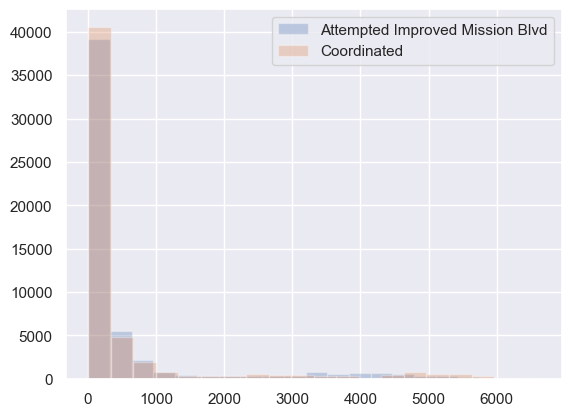

In [ ]:
plt.hist(frame['flow_uncoordinated'], bins=20, alpha=0.3, label=uncoordinated_description)
plt.hist(frame['flow_coordinated'], bins=20, alpha=0.3, label=coordinated_description)
plt.legend()
plt.show()

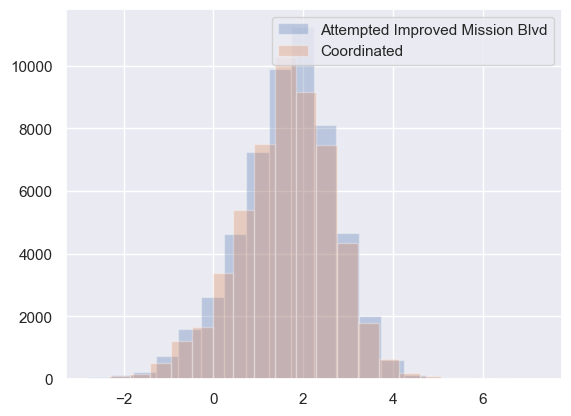

In [ ]:
plt.hist(np.log(frame['ttime_uncoordinated']), bins=20, alpha=0.3, label=uncoordinated_description)
plt.hist(np.log(frame['ttime_coordinated']), bins=20, alpha=0.3, label=coordinated_description)
plt.legend()
plt.show()

<AxesSubplot:>

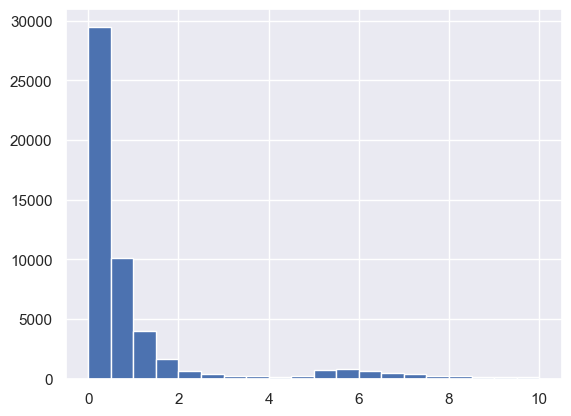

In [ ]:
frame['dtime_uncoordinated'][frame['dtime_uncoordinated'] < 10].hist(bins=20)

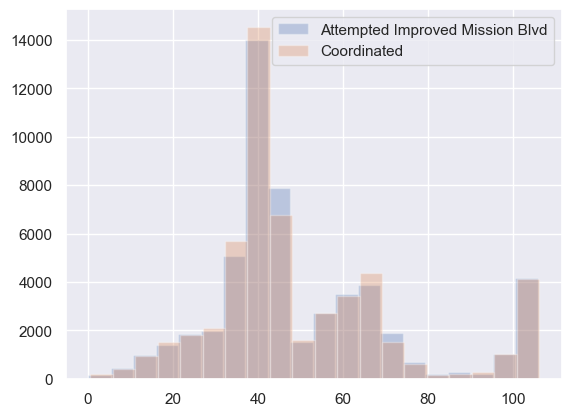

In [ ]:
plt.hist(frame['speed_uncoordinated'], bins=20, alpha=0.3, label=uncoordinated_description)
plt.hist(frame['speed_coordinated'], bins=20, alpha=0.3, label=coordinated_description)
plt.legend()
plt.show()

<AxesSubplot:>

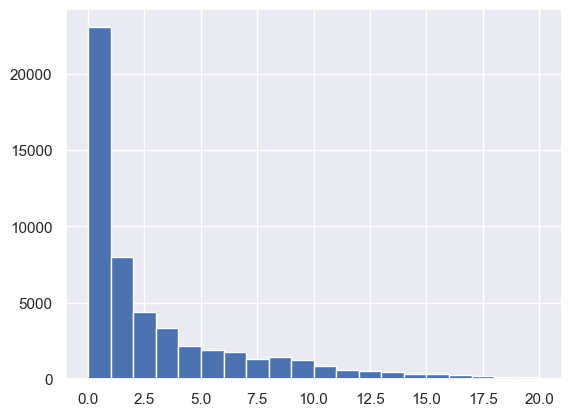

In [ ]:
frame['density_uncoordinated'][frame['density_uncoordinated'] < 20].hist(bins=20)

In [ ]:
frame['log_flow_uncoordinated'] = np.log(frame['flow_uncoordinated'])
frame['log_flow_coordinated'] = np.log(frame['flow_coordinated'])
frame['log_ttime_uncoordinated'] = np.log(frame['ttime_uncoordinated'])
frame['log_ttime_coordinated'] = np.log(frame['ttime_coordinated'])

In [ ]:
section_metrics

{'flow': Column(flow, Mean Flow, veh/h),
 'ttime': Column(ttime, Mean Travel Time, s),
 'dtime': Column(dtime, Mean Delay Time, s),
 'speed': Column(speed, Mean Speed, km/h),
 'density': Column(density, Density by Lane, veh/km)}

In [ ]:
section_comparisons = {
    'flow': (Metric('log_flow', 'Log of mean flow', 'veh/h'), (0, 10)),
    'ttime': (Metric('log_ttime', 'Log of mean travel time', 's'), (-2, 6)),
    'dtime': (section_metrics['dtime'], (0, 2.5)),
    'speed': (section_metrics['speed'], (0, 120)),
    'density': (section_metrics['density'], (0, 8))
}

Processing log_flow, frame 1
Processing log_flow, frame 1
Processing log_flow, frame 2


KeyboardInterrupt: 

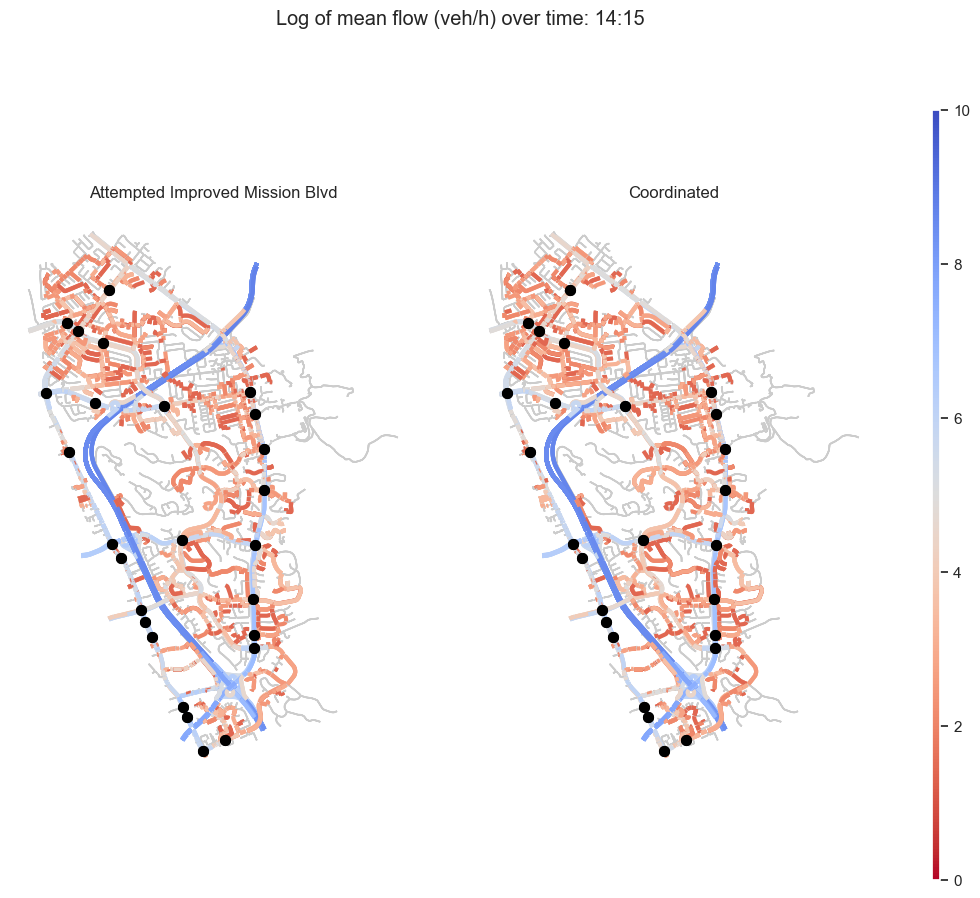

In [ ]:
from matplotlib import animation
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def make_animation_side_by_side(metric, vmin, vmax):
    fig, [ax1, ax2, cax] = plt.subplots(1, 3, figsize=(12, 10), gridspec_kw={"width_ratios":[50,50,1]})
    norm = Normalize(vmin=vmin, vmax=vmax)
    cb = ColorbarBase(cax, cmap='coolwarm_r', norm=norm, orientation='vertical')
    
    def animate(timestep):
        print(f'Processing {metric.name}, frame {timestep}')
        fig.suptitle(f'{metric.desc} ({metric.unit}) over time: {TIME_INTERVALS_STRING[timestep - 1]}')
        data = frame[frame['ent']==timestep+1]
        sections.plot(ax=ax1, lw=1, color='0.8', zorder=-1)
        sections.plot(ax=ax2, lw=1, color='0.8', zorder=-1)
        data.plot(ax=ax1, column=(metric.name + '_uncoordinated'), cmap='coolwarm_r', lw=3, vmin=vmin, vmax=vmax, zorder=0)
        data.plot(ax=ax2, column=(metric.name + '_coordinated'), cmap='coolwarm_r', lw=3, vmin=vmin, vmax=vmax, zorder=0)
        im1 = node_geo_city.plot(ax=ax1, color='black', lw=2, zorder=1)
        im2 = node_geo_city.plot(ax=ax2, color='black', lw=2, zorder=1)
        ax1.set_title(uncoordinated_description)
        ax2.set_title(coordinated_description)
        ax1.set_axis_off()
        ax2.set_axis_off()
        return [im1, im2]

    anim = animation.FuncAnimation(fig, animate, interval=1000, repeat_delay=3000, frames=range(1, 25))
    writergif = animation.PillowWriter(fps=0.6)
    anim.save(f'{image_path}/{metric.name}_side_by_side.gif', writer=writergif)

for k in section_metrics:
    metric, (vmin, vmax) = section_comparisons[k]
    make_animation_side_by_side(metric, vmin, vmax)

In [ ]:
for k in ['dtime', 'density']:
    metric, (vmin, vmax) = section_comparisons[k]
    make_animation_side_by_side(metric, vmin, vmax)

### Ratio

In [ ]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def make_animation_ratio(metric):
    fig, [ax,cax] = plt.subplots(1, 2, figsize=(7, 9), gridspec_kw={"width_ratios":[50,1]})
    norm = Normalize(vmin=0, vmax=2)
    cb = ColorbarBase(cax, cmap='coolwarm_r', norm=norm, orientation='vertical')
    ax.set_axis_off()
    
    def animate(timestep):
        print(f'Processing {metric.name}, frame {timestep}')
        fig.suptitle(f'{metric.desc} coordinated/uncoordinated ratio over time: {TIME_INTERVALS_STRING[timestep - 1]}')
        data = frame[frame['ent']==timestep+1]
        sections.plot(ax=ax, lw=1, color='0.8', zorder=-1)
        data.plot(ax=ax, column=(metric.name + '_ratio'), cmap='coolwarm_r', lw=3, vmin=0, vmax=2, zorder=0)
        im = node_geo_city.plot(ax=ax, color='black', lw=2, zorder=1)
        return [im]

    anim = animation.FuncAnimation(fig, animate, interval=1000, repeat_delay=3000, frames=range(1, 25))
    writergif = animation.PillowWriter(fps=0.8)
    anim.save(f'{image_path}/{metric.name}_ratio.gif', writer=writergif)

for k in section_metrics:
    make_animation_ratio(section_metrics[k])

In [ ]:
make_animation_ratio(section_metrics['speed'])

### Difference

In [ ]:
for k in section_metrics:
    frame[k + '_difference'] = frame[k + '_coordinated'] - frame[k + '_uncoordinated']

frame

ent  flow_uncoordinated  ttime_uncoordinated  dtime_uncoordinated  \
eid                                                                        
242      1              1324.0            24.522981            18.286577   
242      2               764.0            20.645561            14.473680   
242      3               796.0            21.497040            15.264269   
242      4               872.0            22.878881            16.680540   
242      5               852.0            21.656951            15.442929   
...    ...                 ...                  ...                  ...   
29381   22                 4.0             8.508370             2.005016   
1606    23                 8.0             4.487063             0.768128   
1606    24                16.0             4.472663             0.665884   
697     24                 8.0            27.728856             1.698323   
29076   24                 4.0            13.603302             0.767804   

       speed_uncoordinated  density_uncoordinated  count_uncoordinated  \
eid                                                                      
242              27.208512              50.112778                331.0   
242              32.360839              23.719355                191.0   
242              31.139108              26.668741                199.0   
242              29.302826              30.219538                218.0   
242              30.876784              27.871238                213.0   
...                    ...                    ...                  ...   
29381            34.752084               0.115101                  1.0   
1606             35.056167               0.228347                  2.0   
1606             35.273029               0.455229                  4.0   
697              36.275013               0.220964                  2.0   
29076            39.103145               0.102294                  1.0   

       flow_coordinated  ttime_coordinated  dtime_coordinated  ...  \
eid                                                            ...   
242              1356.0          24.155884          17.927443  ...   
242               820.0          21.292549          15.107659  ...   
242               748.0          20.712661          14.576582  ...   
242               780.0          20.496334          14.287262  ...   
242               892.0          22.238980          16.060410  ...   
...                 ...                ...                ...  ...   
29381               4.0           8.347064           1.266354  ...   
1606               12.0           4.288029           0.676140  ...   
1606                4.0           4.084243           0.563123  ...   
697                 4.0          25.148781           1.874166  ...   
29076               4.0          12.671143           0.643045  ...   

                                                geometry  \
eid                                                        
242    LINESTRING (-13572344.019 4508460.315, -135723...   
242    LINESTRING (-13572344.019 4508460.315, -135723...   
242    LINESTRING (-13572344.019 4508460.315, -135723...   
242    LINESTRING (-13572344.019 4508460.315, -135723...   
242    LINESTRING (-13572344.019 4508460.315, -135723...   
...                                                  ...   
29381  LINESTRING (-13574778.890 4515650.959, -135747...   
1606   LINESTRING (-13573105.890 4513157.984, -135730...   
1606   LINESTRING (-13573105.890 4513157.984, -135730...   
697    LINESTRING (-13572712.561 4513499.523, -135723...   
29076  LINESTRING (-13574925.992 4515340.283, -135751...   

       log_flow_uncoordinated  log_flow_coordinated  log_ttime_uncoordinated  \
eid                                                                            
242                  7.188413              7.212294                 3.199611   
242                  6.638568              6.709304                 3.027500   
242                  6.679599              

<AxesSubplot:>

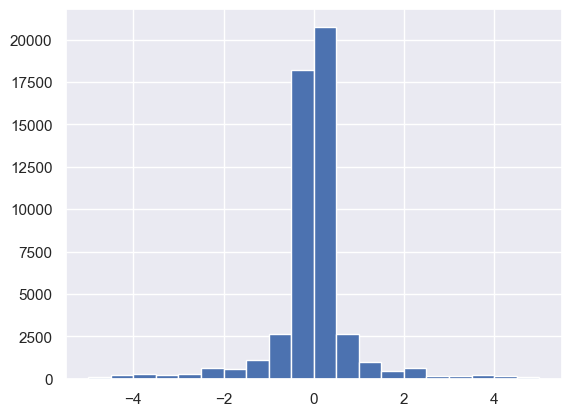

In [ ]:
frame['ttime_difference'][abs(frame['ttime_difference']) < 5].hist(bins=20)

<AxesSubplot:>

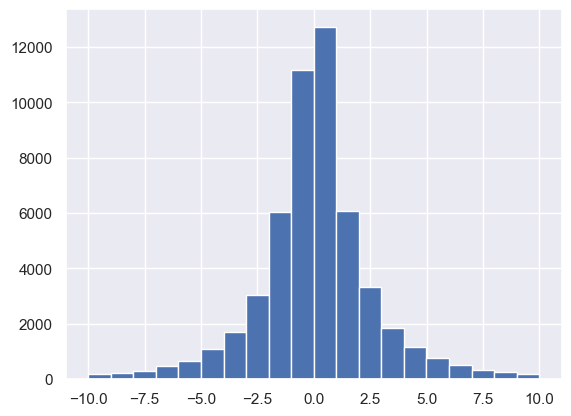

In [ ]:
frame['speed_difference'][abs(frame['speed_difference']) < 10].hist(bins=20)

In [ ]:
section_comparisons_diff = {
    'ttime': (section_metrics['ttime'], (-10, 10)),
    'speed': (section_metrics['speed'], (-10, 10))
}

In [ ]:
sections

id    eid            name  nb_lanes  speed  capacity  rd_type  \
0           242.0    242            None         1  104.0    2100.0    175.0   
1           243.0    243            None         4  104.0    8400.0    175.0   
2           244.0    244            None         4  104.0    8400.0    175.0   
3           246.0    246    Geyser Court         1   40.0     600.0    179.0   
4           247.0    247    Geyser Court         1   40.0     600.0    179.0   
...           ...    ...             ...       ...    ...       ...      ...   
4428  151597396.0  28550  Fernald Common         1   40.0     600.0    179.0   
4429  151600599.0  28581     Alice Court         1   40.0     600.0    179.0   
4430  151616088.0   3425            None         2  104.0    2100.0    175.0   
4431  151616494.0  56150            None         2   72.0    1800.0    177.0   
4432  151627627.0   7154            None         6  104.0   10500.0    175.0   

      func_class        fnode        tnode  \
0              1       9845.0       9923.0   
1              1  151597118.0       9848.0   
2              1       9850.0       9852.0   
3              5       9868.0          NaN   
4              5          NaN       9868.0   
...          ...          ...          ...   
4428           5      42395.0          NaN   
4429           5      39784.0          NaN   
4430           1      56586.0  151616089.0   
4431           3      56168.0  151616495.0   
4432           1      14510.0  151627632.0   

                                               geometry  
0     LINESTRING (-13572344.019 4508460.315, -135723...  
1     LINESTRING (-13572329.348 4508264.159, -135722...  
2     LINESTRING (-13572464.084 4508415.329, -135724...  
3     LINESTRING (-13571458.486 4509669.510, -135714...  
4     LINESTRING (-13571596.214 4509623.139, -135715...  
...                                                 ...  
4428  LINESTRING (-13572473.917 4507663.732, -135724...  
4429  LINESTRING (-13575454.502 4513910.059, -135754...  
4430  LINESTRING (-13574102.042 4511052.704, -135741...  
4431  LINESTRING (-13574438.360 4511038.633, -135744...  
4432  LINESTRING (-13574115.113 4510698.825, -135739...  

[4433 rows x 11 columns]

Processing ttime, frame 1
Processing ttime, frame 1
Processing ttime, frame 2
Processing ttime, frame 3
Processing ttime, frame 4
Processing ttime, frame 5


KeyboardInterrupt: 

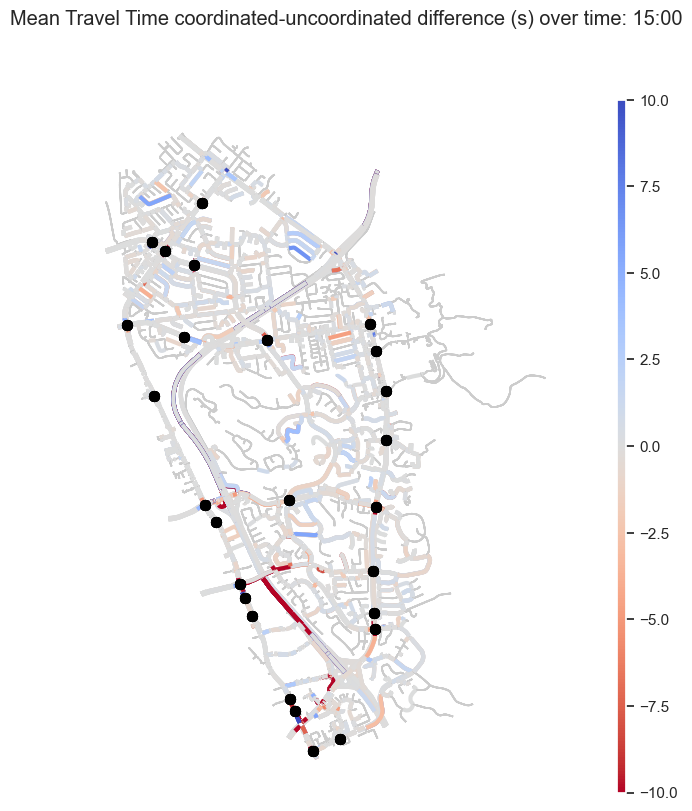

In [ ]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def make_animation_diff(metric, vmin, vmax):
    fig, [ax,cax] = plt.subplots(1, 2, figsize=(7, 9), gridspec_kw={"width_ratios":[50,1]})
    norm = Normalize(vmin=vmin, vmax=vmax)
    cb = ColorbarBase(cax, cmap='coolwarm_r', norm=norm, orientation='vertical')
    ax.set_axis_off()
    
    def animate(timestep):
        print(f'Processing {metric.name}, frame {timestep}')
        fig.suptitle(f'{metric.desc} coordinated-uncoordinated difference ({metric.unit}) over time: {TIME_INTERVALS_STRING[timestep - 1]}')
        data = frame[frame['ent']==timestep+1]
        sections.plot(ax=ax, lw=1, color='0.8', zorder=-1)
        data.plot(ax=ax, column=(metric.name + '_difference'), cmap='coolwarm_r', lw=3, vmin=vmin, vmax=vmax, zorder=0)
        im = node_geo_city.plot(ax=ax, color='black', lw=2, zorder=1)
        return [im]

    anim = animation.FuncAnimation(fig, animate, interval=1000, repeat_delay=3000, frames=range(1, 25))
    writergif = animation.PillowWriter(fps=0.8)
    anim.save(f'{image_path}/{metric.name}_difference.gif', writer=writergif)
    # plt.show()

for k in ['ttime', 'speed']:
    metric, (vmin, vmax) = section_comparisons_diff[k]
    make_animation_diff(metric, vmin, vmax)

# MP4 generation

Because direct MP4 writing doesn't work.

In [ ]:
import moviepy.editor as mp

def gif_to_mp4(path=image_path):
    for filename in os.listdir(path):
        f = os.path.join(path, filename)
        name, ext = f.split('.')
        if os.path.isfile(f) and ext == 'gif':
            clip = mp.VideoFileClip(f)
            clip.write_videofile(name + ".mp4")

gif_to_mp4()

Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\density_mission_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\density_mission_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\density_mission_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\density_osgood_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\density_osgood_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\density_osgood_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\dtime_mission_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\dtime_mission_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\dtime_mission_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\dtime_osgood_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\dtime_osgood_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\dtime_osgood_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\flow_mission_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\flow_mission_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\flow_mission_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\flow_osgood_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\flow_osgood_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\flow_osgood_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\speed_mission_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\speed_mission_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\speed_mission_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\speed_osgood_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\speed_osgood_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\speed_osgood_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\travel_mission_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\travel_mission_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\travel_mission_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\travel_osgood_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\travel_osgood_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\travel_osgood_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\ttime_mission_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\ttime_mission_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\ttime_mission_multiple_comparison.mp4
Moviepy - Building video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\ttime_osgood_multiple_comparison.mp4.
Moviepy - Writing video C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\ttime_osgood_multiple_comparison.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/prest/Preston/Berkeley/fremont_project/images/2023-02-19/100\ttime_osgood_multiple_comparison.mp4


<a id='od'></a>
# OD Data

In [89]:
od_metrics = {
    'speed': Metric('speed', 'Mean Speed', 'km/h'),
    'ttime': Metric('ttime', 'Mean Travel Time', 's'),
    'dtime': Metric('dtime', 'Mean Delay Time', 's'),
    'nbveh': Metric('nbveh', 'Number of vehicles that arrived at destination', 'veh'),
    'input_count': Metric('input_count', 'Number of vehicles in network', 'veh'),
    'input_flow': Metric('input_flow', 'Number flow in network', 'veh/h'),
    'travel': Metric('travel', 'Total km traveled', 'km')
}

# mean_dist = Metric('mean_dist', 'Mean Travel Distance', 'km')

def preprocess_od(df):
    df = df[(df['sid']==0) & (df['nbveh']>0)]
    df = df[['oid', 'eid', 'destination', 'ent'] + list(od_metrics)]
    # df['mean_dist'] = df['speed'] * df['ttime'] / 3600
    df['oid'] = df['oid'].astype(int)
    df['destination'] = df['destination'].astype(int)
    df['dest_eid'] = df['destination'].apply(centroid_oid_to_eid.get)
    df = df.fillna(value=np.nan).dropna()
    return df

# od_metrics['mean_dist'] = mean_dist

In [23]:
# def most_impacted(metric_name, n):
#     df = od_df[['oid', 'eid', 'destination', f'{metric_name}_ratio']].sort_values(by=f'{metric_name}_ratio')
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.dropna(inplace=True)
#     return df.head(n), df.tail(n)

# speed_head, speed_tail = most_impacted('speed', 30)
# ttime_head, ttime_tail = most_impacted('ttime', 30)
# dtime_head, dtime_tail = most_impacted('dtime', 30)
# mean_dist_head, mean_dist_tail = most_impacted('mean_dist', 30)

### Aggregate plots

In [22]:
# def plot(metric_name):
#     metric_data = od_df[f'{metric_name}_ratio']
#     low, high = metric_data.quantile(0.001), metric_data.quantile(0.999)
#     metric_data[(low<=metric_data) & (metric_data<=high)].plot.hist(bins=30, figsize=(10, 8))
#     plt.title(f'{od_columns[metric_name].desc} ratio, coordinated/uncoordinated')

# plot('speed')

### Colored line plots

In [24]:
# from shapely.geometry import Point, LineString, Polygon

# od_df['geometry'] = od_df[['geometry_o', 'geometry_d']].apply(lambda *args: LineString(*args), axis=1)
# od_df.rename(columns={'eid_x': 'eid'})
# del od_df['eid_y']
# od_df = gpd.GeoDataFrame(od_df, geometry='geometry')
# od_df.crs = 'EPSG:3857'
# od_df.groupby(['eid_x', 'destination_eid']).size().reset_index(name='num_trips')

In [25]:
# bounds = {
#     'speed': (0, 100),
#     'ttime': (0, 1200),
#     'dtime': (0, 600),
#     'mean_dist': (0, 15)
# }

# for i in range(4):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 8))
#     metric = od_columns[['speed', 'ttime', 'dtime', 'mean_dist'][i]]
#     fig.suptitle(f'{metric.desc} ({metric.unit})')
#     vmin, vmax = bounds[metric.name]

#     for j in range(2):
#         suffix = ['_uncoordinated', '_coordinated'][j]
#         label = [uncoordinated_description, coordinated_description][j]
#         ax = axs[j]
#         taz_int.plot(ax=ax, color='#353535', zorder=0)
#         taz_int.boundary.plot(ax=ax, color='black', zorder=1)
#         od_df.sample(frac=1).plot(
#             ax=ax, column=metric.name+suffix, legend=(j==1), cmap='hot', lw=0.3, vmin=vmin, vmax=vmax, zorder=2)
#         ax.set_title(label)
#         ax.axis('off')

#     plt.subplots_adjust(wspace=-0.4)
#     save_fig(f'centroid/{metric.name}.png')
#     plt.close()

In [26]:
# def plot(metric_name):
#     metric_data = od_df[f'{metric_name}_ratio']
#     low, high = metric_data.quantile(0.001), metric_data.quantile(0.999)
#     metric_data[(low<=metric_data) & (metric_data<=high)].plot.hist(bins=30, figsize=(10, 8))
#     plt.title(f'{od_columns[metric_name].desc} ratio, coordinated/uncoordinated')

### Mostly vs fully coordinated inverse ratio plotting

Inverted to emphasize that red = bad and blue = good, to visually assess how bad the mostly coordinated scenario is.

In [27]:
# centroid_means = gpd.GeoDataFrame(od_df.groupby('eid_x').mean().merge(centroids[['eid', 'geometry']], left_index=True, right_on='eid'), geometry='geometry')
# centroid_means = centroid_means.to_crs('EPSG:3857')
# centroid_means

In [28]:
# for metric_name in ['speed', 'ttime', 'dtime', 'mean_dist']:
#     centroid_means[metric_name + '_ratio_inv'] = centroid_means[metric_name + '_uncoordinated'] / centroid_means[metric_name + '_coordinated']
#     centroid_means[metric_name + '_diff_inv'] = centroid_means[metric_name + '_uncoordinated'] - centroid_means[metric_name + '_coordinated']

# centroid_means

In [29]:
# centroid_means_regions = gpd.GeoDataFrame(centroid_means.merge(taz_int, how='left', left_on='eid', right_on='CentroidID'), geometry='geometry_y')
# centroid_means_regions.loc[centroid_means_regions['geometry_y'].isna(), 'geometry_y'] = centroid_means_regions['geometry_x']
# centroid_means_regions

Determining bounds

In [30]:
# outlier_cutoff = 0.025

# for k in ['speed', 'ttime', 'dtime', 'mean_dist']:
#     lower = centroid_means[k + '_diff_inv'].quantile(outlier_cutoff)
#     upper = centroid_means[k + '_diff_inv'].quantile(1 - outlier_cutoff)
#     mean = centroid_means[k + '_diff_inv'].mean()
#     graph_bound = max(abs(lower), abs(upper))
#     print(f'''
#     {k}:
#         lower: {lower}
#         upper: {upper}
#         mean:  {mean}
#     ''')
#     centroid_means[k + '_diff_inv'].hist(range=[-graph_bound,graph_bound], bins=20)
#     plt.title(k)
#     plt.show()

Plots

In [31]:
# mostly_vs_fully_todo = {
#     'speed': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (km/h), mostly coordinated - fully coordinated', -6, 6)],
#     'ttime': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (s), mostly coordinated - fully coordinated', -125, 125)], 
#     'dtime': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (s), mostly coordinated - fully coordinated', -50, 50)], 
#     'mean_dist': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (km), mostly coordinated - fully coordinated', -0.5, 0.5)]
# }

# fully_vs_fully_todo = {
#     'speed': 
#         [('_ratio_inv', 'ratio, fully coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (km/h), fully coordinated - fully coordinated', -9, 9)],
#     'ttime': 
#         [('_ratio_inv', 'ratio, fully coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (s), fully coordinated - fully coordinated', -145, 145)], 
#     'dtime': 
#         [('_ratio_inv', 'ratio, fully coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (s), fully coordinated - fully coordinated', -111, 111)], 
#     'mean_dist': 
#         [('_ratio_inv', 'ratio, fully coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (km), fully coordinated - fully coordinated', -0.66, 0.66)]
# }

# mostly_vs_fully_200_todo = {
#     'speed': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (km/h), mostly coordinated - fully coordinated', -8, 8)],
#     'ttime': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (s), mostly coordinated - fully coordinated', -286, 286)], 
#     'dtime': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (s), mostly coordinated - fully coordinated', -275, 275)], 
#     'mean_dist': 
#         [('_ratio_inv', 'ratio, mostly coordinated / fully coordinated', 0.5, 1.5),
#          ('_diff_inv', 'difference (km), mostly coordinated - fully coordinated', -1, 1)]
# }

In [33]:
# for metric_name in todo.keys():
#     for shade_regions in [False, True]:
#         metric = od_columns[metric_name]
#         for suffix, desc, vmin, vmax in todo[metric_name]:
#             fig, ax = plt.subplots(1, 1, figsize=(10, 12))
#             ax.axis('off')
#             node_geo_city.plot(ax=ax, lw=1, color='black', zorder=1)
#             affected_nodes.plot(ax=ax, lw=1, color='purple', zorder=3)
#             if shade_regions:
#                 pass
#                 # sections.plot(ax=ax, color='0.55', zorder=0)
#                 # centroid_means_regions.plot(ax=ax, column=metric_name + suffix, legend=True, cmap='coolwarm', lw=2, vmin=vmin, vmax=vmax, zorder=-1)
#             else:
#                 sections.plot(ax=ax, color='0.8', zorder=0)
#                 centroid_means.plot(ax=ax, column=metric_name + suffix, legend=True, cmap='coolwarm', lw=10, vmin=vmin, vmax=vmax, zorder=2)
            
#             plt.title(f'{metric.desc} {desc}', wrap=True)
#             save_fig(f"{metric_name + suffix}{('_taz' if shade_regions else '')}.png")
#             plt.close()

## Multiple comparison plots

In [97]:
unpacked_databases_od = unpack_databases('MICENT_O', preprocess_od)

100%|██████████| 11/11 [00:01<00:00,  8.31it/s, scenario=lv_mission_nb_averaged]     


In [116]:
from pyproj import Transformer
from shapely.geometry.point import Point

transformer = Transformer.from_crs('EPSG:3857', 'EPSG:4326')

for scenario in unpacked_databases_od:
    df = unpacked_databases_od[scenario]
    df = df.merge(centroids[['eid', 'geometry']].add_prefix('origin_'), left_on='eid', right_on='origin_eid')
    df = df.merge(centroids[['eid', 'geometry']].add_prefix('dest_'), on='dest_eid')
    df = df.drop(columns=['dest_eid', 'origin_eid'])
    for k in ['origin', 'dest']:
        latlong = df[f'{k}_geometry'].apply(lambda p: transformer.transform(p.x, p.y))
        df[f'{k}_lat'] = latlong.apply(lambda pair: pair[0])
        df[f'{k}_long'] = latlong.apply(lambda pair: pair[1])
    northbound = np.sum(df[df['origin_lat'] < df['dest_lat']]['input_count'])
    southbound = np.sum(df[df['origin_lat'] > df['dest_lat']]['input_count'])
    print(scenario, 'northbound/southbound count ratio =', northbound/southbound)

fully_coordinated_rep1 northbound/southbound count ratio = 1.1084905114221868
fully_coordinated_rep2 northbound/southbound count ratio = 1.042105998998031
fully_coordinated_rep3 northbound/southbound count ratio = 1.1161535385845662
nooffset_mission_nb_rep1 northbound/southbound count ratio = 1.1083123425692696
nooffset_mission_nb_rep2 northbound/southbound count ratio = 1.1094122937493514
lv_mission_nb_rep1 northbound/southbound count ratio = 1.1085446074521093
lv_mission_nb_rep2 northbound/southbound count ratio = 1.1075560271744773
lv_mission_nb_rep3 northbound/southbound count ratio = 1.1139663892967857
fully_coordinated_averaged northbound/southbound count ratio = 1.0864322024013335
nooffset_mission_nb_averaged northbound/southbound count ratio = 1.1058926454817406
lv_mission_nb_averaged northbound/southbound count ratio = 1.1062610915073954


In [ ]:
unpacked_databases_od_mean = unpacked_databases_od.copy()

for k, v in unpacked_databases_od_mean.items():
    desc, df = v['desc'], v['database'].copy()
    df = preprocess_od(df).groupby('eid').mean().reset_index()
    df = df.merge(centroids[['eid', 'geometry']], on='eid').drop(columns=['oid', 'destination'])
    df = gpd.GeoDataFrame(df, geometry='geometry')
    df = df.to_crs("EPSG:3857")
    unpacked_databases_od_mean[k]['database'] = df

unpacked_databases_od_mean

{'fully_uncoordinated': {'desc': 'Uncoordinated',
  'database':        eid      speed       ttime       dtime  mean_dist  \
  0    ext_1  38.525177  662.893485  334.399183   6.879794   
  1   ext_10  41.902565  383.355447  146.138469   4.262834   
  2    ext_2  34.710657  791.253418  433.281484   7.741914   
  3    ext_3  37.100288  678.382762  330.074411   6.828012   
  4    ext_4  62.343141  394.902740  115.852378   6.471620   
  ..     ...        ...         ...         ...        ...   
  61   int_7  42.766645  510.227519  249.771245   5.690874   
  62  int_71  45.768539  472.532376  175.001050   5.738981   
  63  int_73  43.860177  584.771671  216.906298   7.069747   
  64  int_74  45.384544  506.173594  180.888289   6.180879   
  65   int_8  38.164753  537.052509  207.840987   5.462328   
  
                               geometry  
  0   POINT (-13573357.287 4507368.344)  
  1   POINT (-13575933.355 4513673.488)  
  2   POINT (-13573042.528 4507181.778)  
  3   POINT (-13572885.

Mean Speed
Metric: speed (km/h) | Uncoordinated: 30.242854003939417 | Fully Coordinated: 31.604938927131855
Metric: speed (km/h) | Coordinated but Mission Blvd: 32.06404213871871 | Fully Coordinated: 31.604938927131855
Metric: speed (km/h) | Coordinated but Osgood Road: 32.75690500938804 | Fully Coordinated: 31.604938927131855
Metric: speed (km/h) | Mission Blvd Fully Uncoordinated: 47.355443416971475 | Fully Coordinated: 31.604938927131855
Metric: speed (km/h) | Osgood Road Fully Uncoordinated: 45.03916500138609 | Fully Coordinated: 31.604938927131855


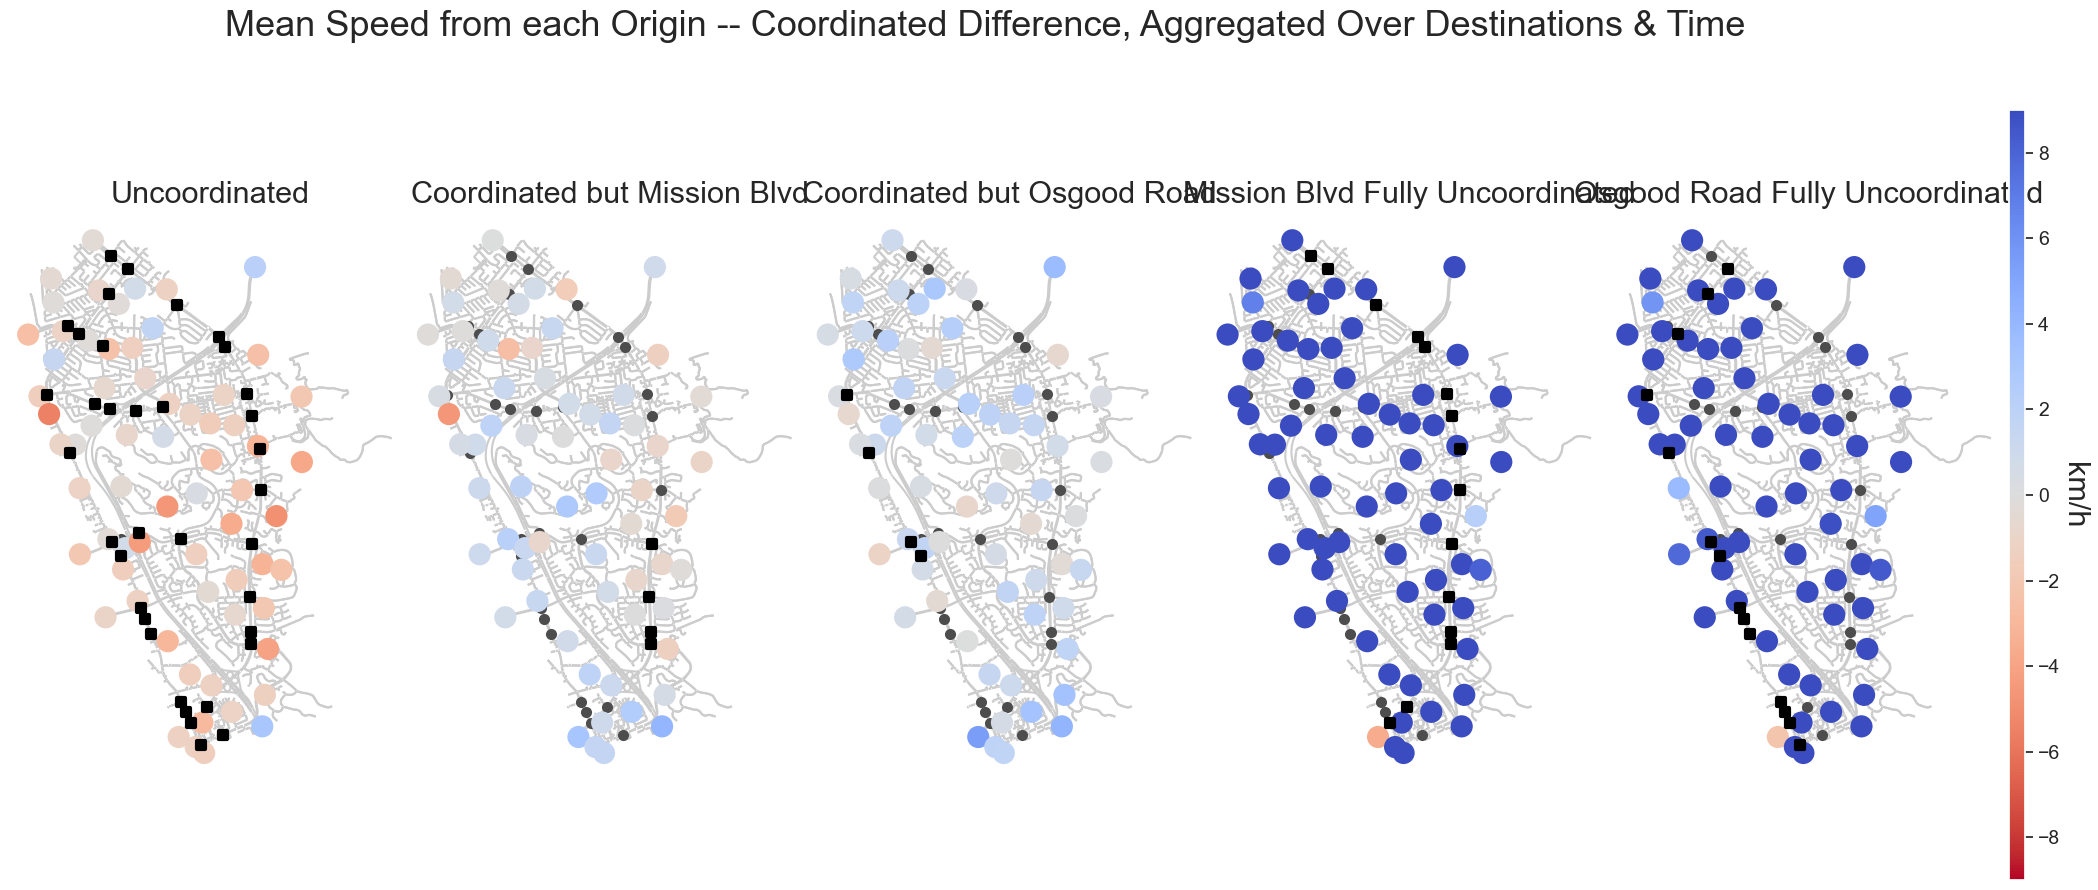

Mean Travel Time
Metric: ttime (s) | Uncoordinated: 411.0690006243823 | Fully Coordinated: 398.46143887661856
Metric: ttime (s) | Coordinated but Mission Blvd: 389.97623369723914 | Fully Coordinated: 398.46143887661856
Metric: ttime (s) | Coordinated but Osgood Road: 368.0131797587156 | Fully Coordinated: 398.46143887661856
Metric: ttime (s) | Mission Blvd Fully Uncoordinated: 490.5851238629155 | Fully Coordinated: 398.46143887661856
Metric: ttime (s) | Osgood Road Fully Uncoordinated: 542.503523661105 | Fully Coordinated: 398.46143887661856


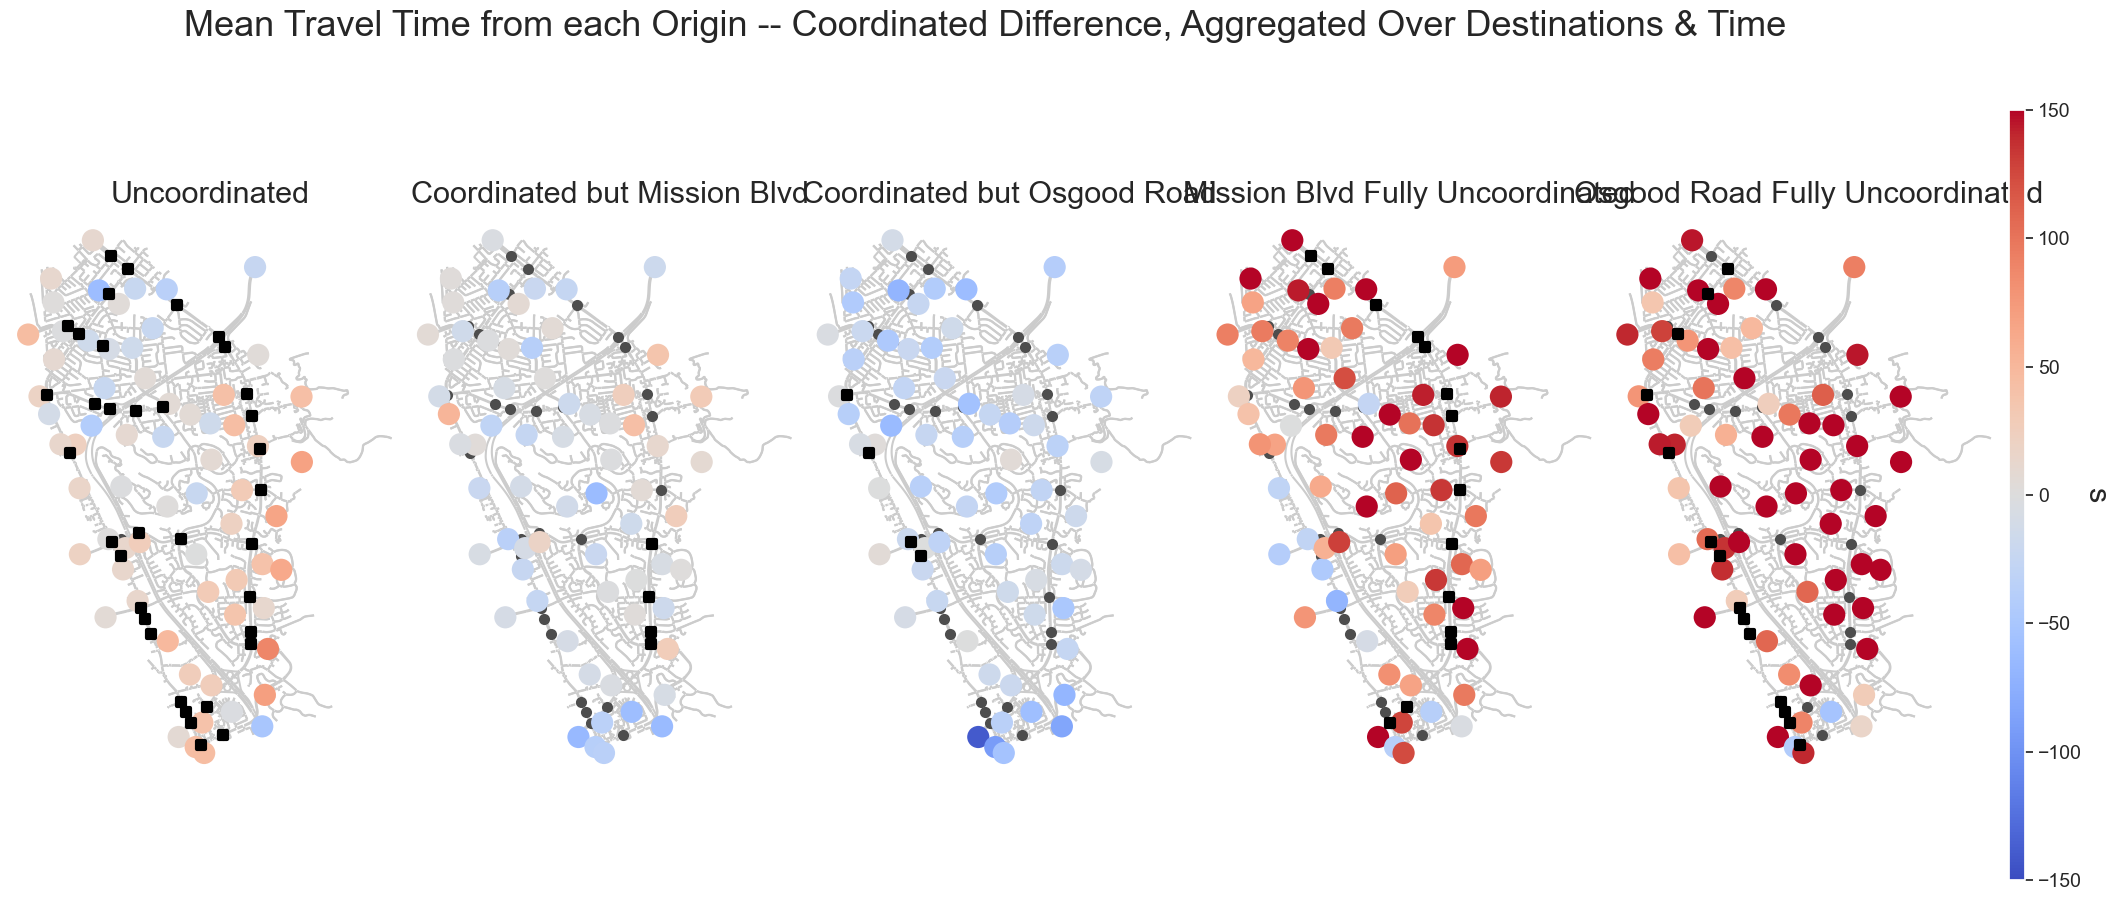

Mean Delay Time
Metric: dtime (s) | Uncoordinated: 183.50679288360695 | Fully Coordinated: 171.93358147919238
Metric: dtime (s) | Coordinated but Mission Blvd: 166.0913098312606 | Fully Coordinated: 171.93358147919238
Metric: dtime (s) | Coordinated but Osgood Road: 150.26627575431618 | Fully Coordinated: 171.93358147919238
Metric: dtime (s) | Mission Blvd Fully Uncoordinated: 185.01027343372348 | Fully Coordinated: 171.93358147919238
Metric: dtime (s) | Osgood Road Fully Uncoordinated: 233.21375835619864 | Fully Coordinated: 171.93358147919238


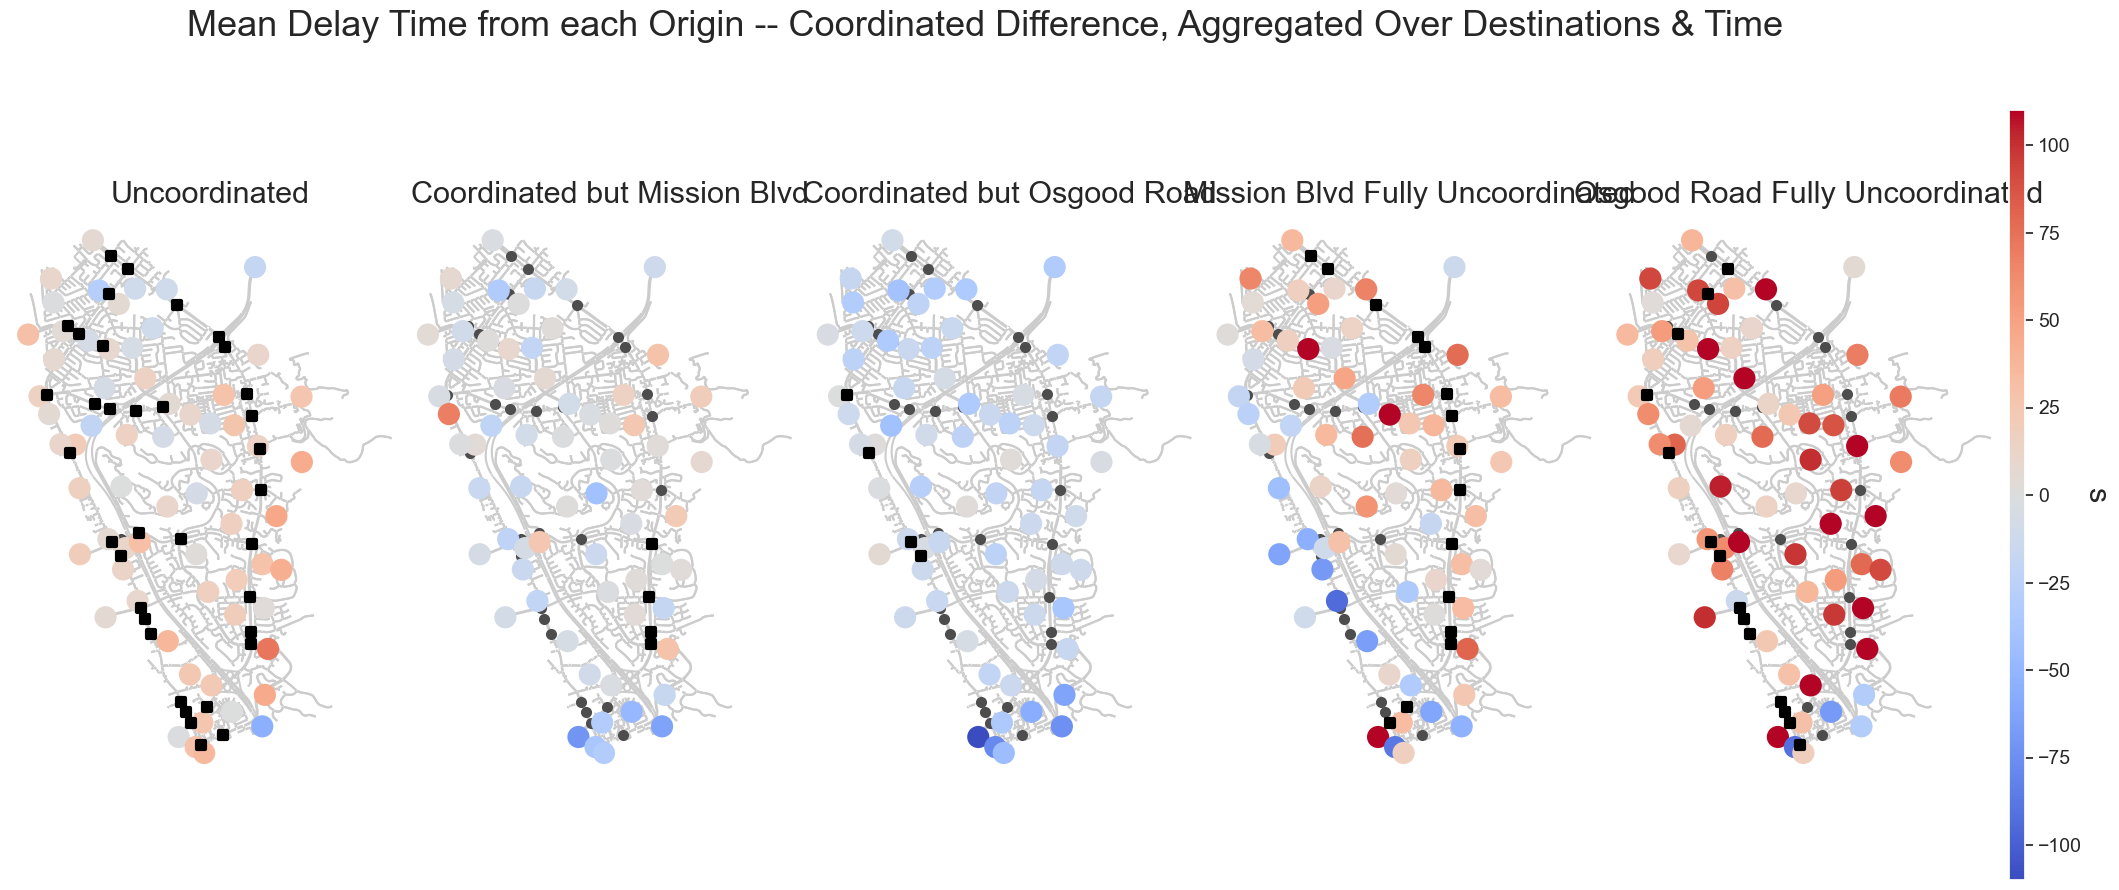

Mean Travel Distance
Metric: mean_dist (km) | Uncoordinated: 3.755252321219801 | Fully Coordinated: 3.7431433886747434
Metric: mean_dist (km) | Coordinated but Mission Blvd: 3.7625593167580935 | Fully Coordinated: 3.7431433886747434
Metric: mean_dist (km) | Coordinated but Osgood Road: 3.6851911613229626 | Fully Coordinated: 3.7431433886747434
Metric: mean_dist (km) | Mission Blvd Fully Uncoordinated: 5.993402855016897 | Fully Coordinated: 3.7431433886747434
Metric: mean_dist (km) | Osgood Road Fully Uncoordinated: 6.070351946484195 | Fully Coordinated: 3.7431433886747434


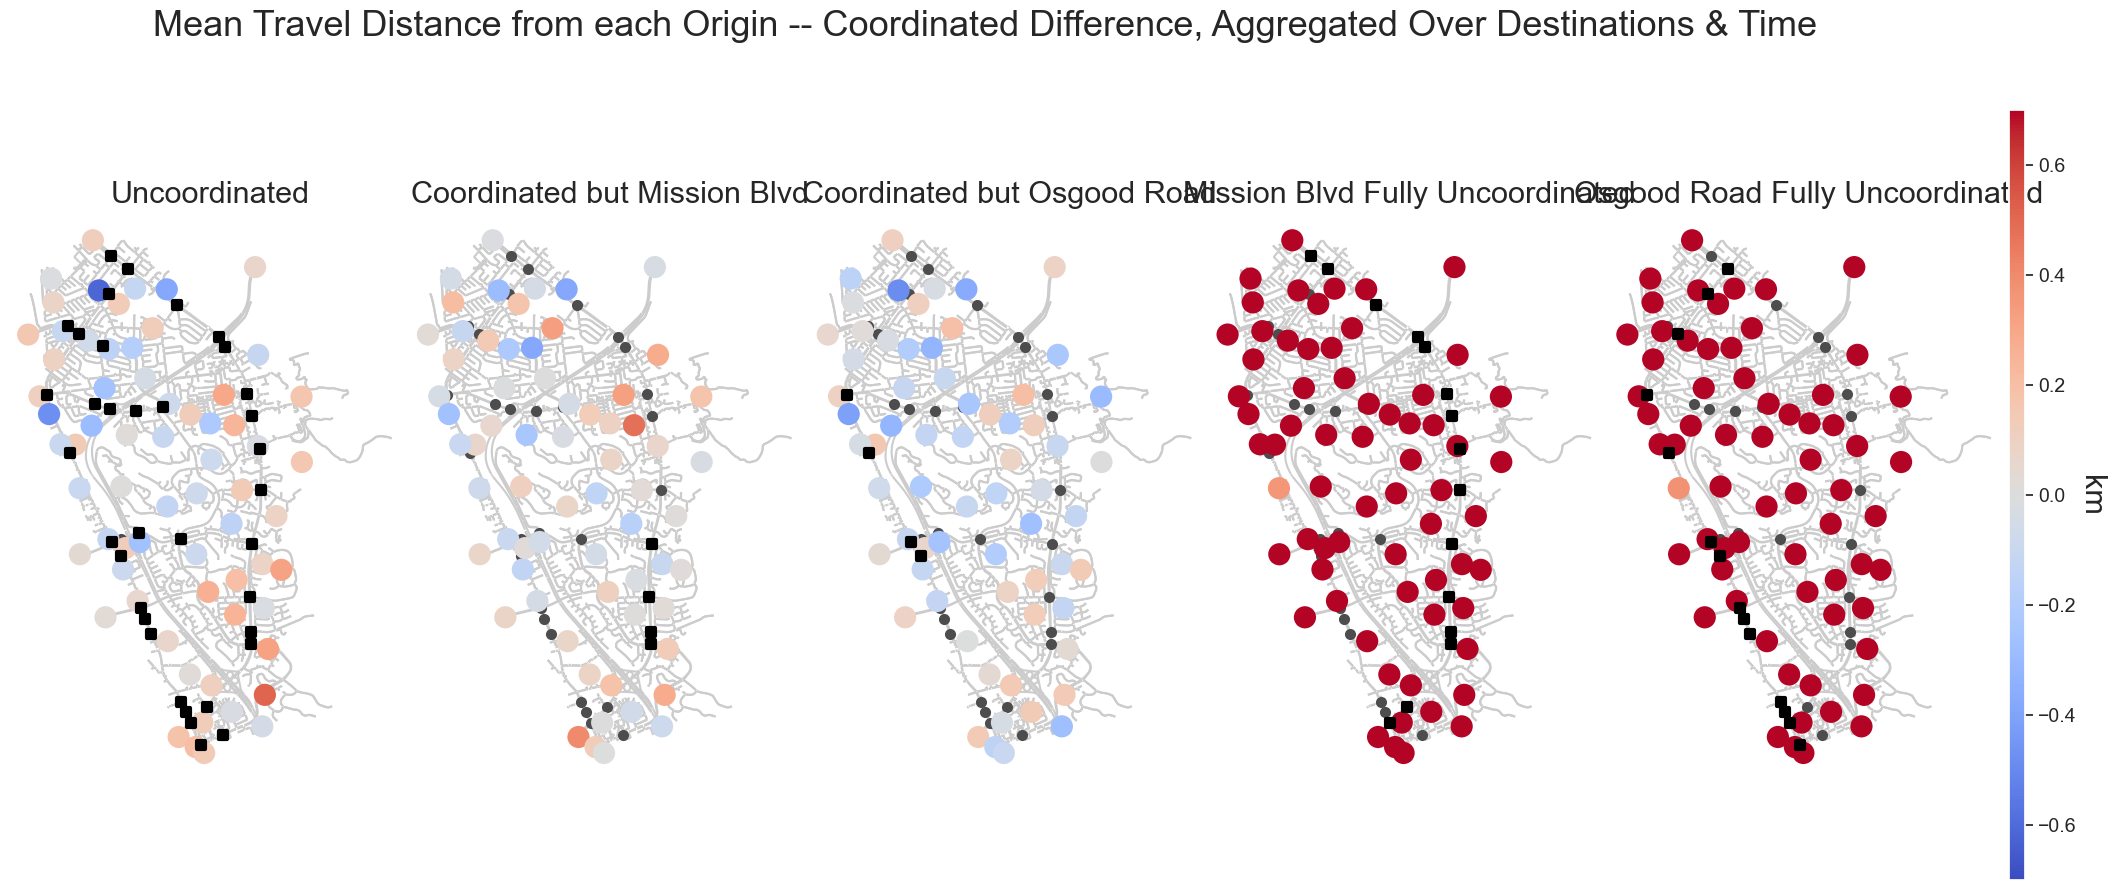

In [ ]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def od_plot(metric, which, compare_to):
    vmin, vmax = None, None
    cmap = 'coolwarm'
    if metric == 'speed':
        vmin, vmax = -9, 9
        cmap = 'coolwarm_r'
    if metric == 'ttime':
        vmin, vmax = -150, 150
    if metric == 'dtime':
        vmin, vmax = -110, 110
    if metric == 'mean_dist':
        vmin, vmax = -0.7, 0.7
    metric = od_columns_compare[metric]
    print(metric.desc)
    
    fig, axs = plt.subplots(1, len(which) + 1, figsize=(4*len(which) + 6, 10), gridspec_kw={'width_ratios': [50]*len(which)+[2]})
    fig.suptitle(f'{metric.desc} from each Origin -- Coordinated Difference, Aggregated Over Destinations & Time', size=26)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cb = ColorbarBase(axs[-1], cmap=cmap, norm=norm, orientation='vertical')
    axs[-1].tick_params(labelsize=14)
    axs[-1].set_ylabel(metric.unit, rotation=270, size=22, labelpad=20)

    desc = unpacked_databases_od_mean[compare_to]['desc']
    compare_database = unpacked_databases_od_mean[compare_to]['database']

    for i in range(len(which)):
        ax = axs[i]
        desc = unpacked_databases_od_mean[which[i]]['desc']
        database = unpacked_databases_od_mean[which[i]]['database']
        database = database.join(compare_database, 
            lsuffix='_to_compare', rsuffix='_compare_to').dropna().rename(columns={'geometry_to_compare': 'geometry'})

        database['difference'] = database[f'{metric.name}_to_compare'] - database[f'{metric.name}_compare_to']
        affected_nodes = node_geo_combined[node_geo_combined['id'].isin(databases[which[i]]['uncoordinated_nodes'])]
        
        print(f'Metric: metric.__str__() |', \
            f'{desc}:', database[f'{metric.name}_to_compare'].mean(),
            '| Fully Coordinated:', database[f'{metric.name}_compare_to'].mean())
        
        sections.plot(ax=ax, color='0.8', zorder=0)
        node_geo_combined.plot(ax=ax, color='0.3', lw=2, zorder=1)
        if affected_nodes.shape[0]:
            affected_nodes.plot(ax=ax, color='black', lw=3, zorder=3, marker='s')
        database.plot(ax=ax, column='difference', cmap=cmap, lw=10, vmin=vmin, vmax=vmax, zorder=2)
        ax.set_title(desc, size=22)
        ax.axis('off')

    plt.subplots_adjust(wspace=0)
    save_fig(f'od-{metric.name}-aggregated-combined.png')
    plt.close()

for k in ['speed', 'ttime', 'dtime', 'mean_dist']:
    od_plot(k, to_plot[:-1], to_plot[-1])

### Specific o

Mean speed from each origin to all other destinations, aggregated over time

In [ ]:
unpacked_databases_od_from = unpack_databases('MICENT_O')

for k, v in unpacked_databases_od_from.items():
    desc, df = v['desc'], v['database']
    df = preprocess_od(df)
    df = df.merge(df[['oid', 'eid']].drop_duplicates('oid'), how='left', left_on='destination', right_on='oid', suffixes=['_o', '_d'])
    df.dropna(inplace=True)
    unpacked_databases_od_from[k]['database'] = df

unpacked_databases_od_from

{'fully_uncoordinated': {'desc': 'System Fully Uncoordinated',
  'database':            oid_o   eid_o  destination      speed       ttime       dtime  \
  0      151634377   int_0    151635727  92.354351  257.477739   24.204354   
  1      151634377   int_0    151635733  44.388216  317.837200  178.763933   
  2      151634377   int_0    151635745  41.809689  148.246362   66.308671   
  4      151634402   int_1    151635727  51.018652  621.714604  210.039434   
  5      151634402   int_1    151635733  44.971804  510.089946  170.778886   
  ...          ...     ...          ...        ...         ...         ...   
  13380  151635745  ext_10    151635583  39.035977  176.064612   44.026035   
  13381  151635745  ext_10    151635600  39.247670  272.716084  103.902120   
  13382  151635745  ext_10    151635648  55.183013   23.320849    3.579845   
  13383  151635745  ext_10    151635666  38.882711  193.086533   75.910481   
  13384  151635745  ext_10    151635689  38.088003  313.202431  121

In [ ]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def specific_o_d_plot(origin, metric, which, mode=1, show_color_bar=True):
    """
    Plots `metric` across the network for all vehicles with origin `origin`,
    where each dot on the resulting graph represents the value of the metric
    aggregated over all time steps for vehicles with destination at that dot.

    There are two modes:
    `mode` = 'standard': Plots all entries in `which`
    `mode` = 'compare': Uses `which[-1]` as a "comparison" scenario, to 
                        which all other entries in `which` are compared 
                        via difference
    """

    def isolate_origin(name):
        desc = unpacked_databases_od_from[name]['desc']
        database = unpacked_databases_od_from[name]['database']
        database = database[database['eid_o']==origin].groupby('eid_d').mean().reset_index()
        database = database.merge(centroids[['eid', 'geometry']], left_on='eid_d', right_on='eid')
        database = gpd.GeoDataFrame(database[['eid', metric.name, 'geometry']])
        return desc, database

    plot_params = {
        'speed': {
            'standard': {'cmap': 'afmhot', 'vmin': 0, 'vmax': 90},
            'compare': {'cmap': 'coolwarm_r', 'vmin': -6, 'vmax': 6},
        },
        'ttime': {
            'standard': {'cmap': 'afmhot_r', 'vmin': 0, 'vmax': 1200},
            'compare': {'cmap': 'coolwarm', 'vmin': -100, 'vmax': 100},
        },
        'dtime': {
            'standard': {'cmap': 'afmhot_r', 'vmin': 0, 'vmax': 600},
            'compare': {'cmap': 'coolwarm', 'vmin': -60, 'vmax': 60},
        },
        'mean_dist': {
            'standard': {'cmap': 'afmhot_r', 'vmin': 0, 'vmax': 15},
            'compare': {'cmap': 'coolwarm', 'vmin': -1, 'vmax': 1},
        },
    }

    cmap, vmin, vmax = plot_params[metric][mode].values()
    origin_geo = centroids[centroids['eid']==origin]['geometry'].iloc[0]
    origin_geo = gpd.GeoDataFrame({'geometry': [origin_geo]})
    metric = od_columns_compare[metric]
    print(f'{metric.desc} from {origin}')
    if mode == 'compare':
        compare_to_desc, compare_to_database = isolate_origin(which[-1])
        which = which[:-1]

    if show_color_bar:
        fig, axs = plt.subplots(1, len(which) + 1, figsize=(4.5*len(which)+4, 9), gridspec_kw={'width_ratios': [50]*len(which)+[2]})
        fig.suptitle(f'{metric.desc} - {compare_to_desc} Difference from Specific Origin, Aggregated Over Time', size=26)
        norm = Normalize(vmin=vmin, vmax=vmax)
        cb = ColorbarBase(axs[-1], cmap=cmap, norm=norm, orientation='vertical')
        axs[-1].tick_params(labelsize=14)
        axs[-1].set_ylabel(metric.unit, rotation=270, size=22, labelpad=20)
    else:
        fig, axs = plt.subplots(1, len(which), figsize=(4.5*len(which)+4, 9), gridspec_kw={'width_ratios': [50]*len(which)})

    for i in range(len(which)):
        ax = axs[i]
        desc, database = isolate_origin(which[i])
        if mode == 'compare':
            database = database.merge(compare_to_database, on=['eid', 'geometry'], suffixes=['_to_compare', '_compare_to'])
            # kind of bad, but just setting [metric.name] so that the plot command is cleaner later
            database[metric.name] = database[metric.name + '_to_compare'] - database[metric.name + '_compare_to']

        affected_nodes = node_geo_city[node_geo_city['id'].isin(databases[which[i]]['uncoordinated_nodes'])]
        sections.plot(ax=ax, color='0.8', zorder=0)
        node_geo_city.plot(ax=ax, color='0.3', lw=2, zorder=1)
        if affected_nodes.shape[0]:
            affected_nodes.plot(ax=ax, color='black', lw=3, zorder=3, marker='s')
        database.plot(ax=ax, column=metric.name, cmap=cmap, lw=10, vmin=vmin, vmax=vmax, zorder=2)
        origin_geo.plot(ax=ax, color='green', lw=10, zorder=3)
        print(database)
        print(f"{desc} | Mean: {database[metric.name + '_to_compare'].mean()},",
              f"Standard Deviation: {database[metric.name + '_to_compare'].std()}")
        ax.set_title(desc, size=23)
        # ax.set_title(desc, size=21)
        ax.axis('off')
    if mode == 'compare':
        print(f"{compare_to_desc} | Mean: {compare_to_database[metric.name].mean()},",
              f"Standard Deviation: {compare_to_database[metric.name].std()}")

    plt.subplots_adjust(wspace=0)
    save_fig(f'od/{metric.name}/{mode}-{origin}-combined.png')
    plt.close()

for origin in ['ext_9', 'ext_4', 'ext_1', 'ext_6']:   # northeast, southeast, southwest, west
    for k in ['speed', 'ttime', 'dtime', 'mean_dist']:
        specific_o_d_plot(origin, k, to_plot, 'compare')

Mean Speed from ext_9
       eid  speed_to_compare                           geometry  \
0    ext_1         48.961764  POINT (-13573357.287 4507368.344)   
1    ext_2         35.931757  POINT (-13573042.528 4507181.778)   
2    ext_4         84.723652  POINT (-13571810.274 4507565.394)   
3    ext_5         34.038877  POINT (-13574710.931 4509583.600)   
4    ext_6         57.275975  POINT (-13575185.233 4510750.740)   
5    int_0         49.342375  POINT (-13573642.679 4512924.678)   
6    int_1         32.769871  POINT (-13575676.027 4515411.360)   
7   int_11         41.269370  POINT (-13573577.591 4515653.766)   
8   int_12         35.556029  POINT (-13575266.503 4512778.827)   
9   int_16         19.787843  POINT (-13572772.167 4513172.839)   
10  int_17         34.802815  POINT (-13574833.032 4515633.650)   
11  int_18         47.712455  POINT (-13572379.425 4511314.599)   
12  int_19         40.709314  POINT (-13574658.581 4511030.046)   
13   int_2         29.691851  POINT (-13

<a id='trajectory'></a>
# Trajectories

In [ ]:
uncoordinated_trajectory_query = pd.read_sql('SELECT * FROM MIVEHTRAJECTORY', uncoordinated_con)
uncoordinated_trajectory_df = pd.DataFrame(uncoordinated_trajectory_query)

uncoordinated_trajectory_df.head()

In [ ]:
uncoordinated_trajectory_df

In [ ]:
uncoordinated_detailed_trajectory_query = pd.read_sql('SELECT * FROM MIVEHDETAILEDTRAJECTORY', uncoordinated_con)
uncoordinated_detailed_trajectory_df = pd.DataFrame(uncoordinated_detailed_trajectory_query)

uncoordinated_detailed_trajectory_df.head()

In [ ]:
uncoordinated_trajectory_df.head()

In [ ]:
coordinated_trajectory_query = pd.read_sql('SELECT * FROM MIVEHTRAJECTORY', coordinated_con)
coordinated_trajectory_df = pd.DataFrame(coordinated_trajectory_query)

coordinated_trajectory_df.head()

In [ ]:
coordinated_detailed_trajectory_query = pd.read_sql('SELECT * FROM MIVEHDETAILEDTRAJECTORY', coordinated_con)
coordinated_detailed_trajectory_df = pd.DataFrame(coordinated_detailed_trajectory_query)

coordinated_detailed_trajectory_df.head()

In [ ]:
def od_demand(df):
    return df.groupby(['origin', 'destination']).size().reset_index(name='freq').sort_values(by='freq', ascending=False)

od_demand(uncoordinated_trajectory_df)

In [ ]:
od_demand(coordinated_trajectory_df)

In [ ]:
dfs_traj = {
    'uncoordinated': uncoordinated_detailed_trajectory_df.merge(uncoordinated_trajectory_df, how='left', on='oid'),
    'coordinated': coordinated_detailed_trajectory_df.merge(coordinated_trajectory_df, how='left', on='oid')
}

top_pairs_oid = [
    (151635727, 151635742),
    (151635742, 151635727),
    (151635742, 151635718),
    (151635718, 151635742),
    (151635727, 151635718),
    (151635718, 151635727),
]

dfs_traj_top = {}

def astype_per_column(df, columns, dtype):
    for col in columns:
        df[col] = df[col].astype(dtype)

for k in dfs_traj:
    for p in top_pairs_oid:
        o_oid, d_oid = p
        o_eid = od_df[od_df['oid']==o_oid]['eid_x'].unique()[0]
        d_eid = od_df[od_df['oid']==d_oid]['eid_x'].unique()[0]
        key = f'{o_eid}_{d_eid}_{k}'
        dfs_traj_top[key] = dfs_traj[k][(dfs_traj[k]['origin']==o_oid) & (dfs_traj[k]['destination']==d_oid)]
        astype_per_column(dfs_traj_top[key], ['xCoord', 'yCoord'], float)

dfs_traj_top['ext_4_ext_9_uncoordinated'].head()


In [ ]:
for k, df in dfs_traj_top.items():
    dfs_traj_top[k]['geometry'] = df[['xCoord', 'yCoord']].apply(lambda *args: Point(*args), axis=1)
    print(dfs_traj_top[k].head())

# dfs_traj_top['ext_4_ext_9_uncoordinated'].head()

In [ ]:
node_data = od_df[['eid_x', 'geometry_o']].copy()
node_data = gpd.GeoDataFrame(node_data, geometry='geometry_o')
node_data = node_data.to_crs('EPSG:3857').drop_duplicates()
node_data

In [ ]:
class ODPlot:
    def __init__(self, origin, destination, sample_every_nth, alpha):
        self.origin = origin
        self.destination = destination
        self.sample_every_nth = sample_every_nth
        self.alpha = alpha
    
    def __repr__(self):
        return f'{self.origin}_{self.destination}'

popular_ods = [
    ODPlot('ext_4', 'ext_9', 80, 0.1),
    ODPlot('ext_9', 'ext_4', 80, 0.1),
    ODPlot('ext_9', 'ext_1', 40, 0.1),
    ODPlot('ext_1', 'ext_9', 40, 0.1),
    ODPlot('ext_4', 'ext_1', 10, 0.1),
    ODPlot('ext_1', 'ext_4', 10, 0.1)
]

"""
ODPlot('ext_4', 'ext_9', 10, 0.5),
ODPlot('ext_9', 'ext_4', 30, 0.4),
ODPlot('ext_9', 'ext_1', 60, 0.2),
ODPlot('ext_1', 'ext_9', 50, 0.1),
ODPlot('ext_4', 'ext_1', 15, 0.3),
ODPlot('ext_1', 'ext_4', 15, 0.5)
"""

def point_noise(p, radius):
    dx = np.random.uniform(-radius, radius)
    dy = np.random.uniform(-radius, radius)
    return Point(p.x + dx, p.y + dy)

def plot_routes(data, ax, type, od):
    ax.set_title(type, size=22)
    ax.axis('off')
    data = gpd.GeoDataFrame(data, geometry='geometry').iloc[::od.sample_every_nth, :]
    data.crs = "EPSG:32610"
    data = data.to_crs('EPSG:3857')
    data['geometry'] = data['geometry'].apply(lambda p : point_noise(p, 70))
    origin = node_data[node_data['eid_x']==od.origin]
    destination = node_data[node_data['eid_x']==od.destination]['geometry_o']

    frame.plot(ax=ax, color='0.8', zorder=0)
    data.plot(ax=ax, lw=0.1, alpha=od.alpha, zorder=1)
    origin.plot(ax=ax, color='black', lw=3, zorder=2)
    destination.plot(ax=ax, color='red', lw=3, zorder=2)

for i in range(6):
    od = popular_ods[i]
    fig, axs = plt.subplots(1, 2, figsize=(14, 12), squeeze=False)
    plot_routes(dfs_traj_top[f'{str(od)}_uncoordinated'], axs[0][0], uncoordinated_description, od)
    plot_routes(dfs_traj_top[f'{str(od)}_coordinated'], axs[0][1], coordinated_description, od)
    fig.suptitle(f'Routes {od}', size=26)
    plt.subplots_adjust(wspace=0)
    save_fig(f'routes_{od}.png')
    plt.show()
